# Capstone Project - NBFC Foreclosure

#### Import the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import missingno as msno

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier

from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, roc_auc_score, roc_curve

import warnings
warnings.filterwarnings('ignore')

#### Reading and viewing the data and the data dictionary

In [2]:
df = pd.read_excel('NBFC Loan Transaction Data.xlsx')
data_dict = pd.read_excel('NBFC_Foreclosure_Data_dictionary.xlsx')

In [3]:
pd.set_option('display.max_columns', 10)
df.head(10)

,AGREEMENTID,AUTHORIZATIONDATE,BALANCE_EXCESS,BALANCE_TENURE,CITY,...,SCHEMEID,NPA_IN_LAST_MONTH,NPA_IN_CURRENT_MONTH,MOB,FORECLOSURE
0,11220001,2010-08-29,0.000000,0,MUMBAI,...,10901100.0,NaN,NaN,45,1
1,11220002,2010-09-15,0.000000,99,MUMBAI,...,10901100.0,NaN,NaN,38,1
2,11220006,2010-11-02,0.000000,231,MUMBAI,...,10901101.0,NaN,NaN,81,1
3,11220008,2010-10-06,0.000000,0,THANE,...,10901100.0,NaN,NaN,91,1
4,11220010,2010-10-26,0.000000,215,MUMBAI,...,10901101.0,NaN,NaN,90,1
5,11220011,2010-10-28,0.000000,137,THANE,...,10901100.0,NaN,NaN,98,0
6,11220012,2010-11-05,0.000000,294,MUMBAI,...,10901100.0,NaN,NaN,97,0
7,11220014,2010-12-24,0.000000,276,MUMBAI,...,10901100.0,NaN,NaN,52,1
8,11220016,2010-12-16,0.000000,145,THANE,...,10901101.0,NaN,NaN,74,1
9,11220017,2010-11-25,9988.419361,291,THANE,...,10901116.0,NaN,NaN,97,0


In [4]:
data_dict 

,Col_name,Description
0,AGREEMENTID,Agreement ID of the loan account ( a customer ...
1,AUTHORIZATIONDATE,Authorization date of the loan
2,BALANCE_EXCESS,Balance of excess amount
3,BALANCE_TENURE,Remaining tenure
4,CITY,City of origination
5,COMPLETED_TENURE,Completed tenure
6,CURRENT_INTEREST_RATE,Current rate of interest on the loan. Renamed ...
7,CURRENT_INTEREST_RATE_MAX,Maximum value of the CURRENT ROI across transa...
8,CURRENT_INTEREST_RATE_MIN,Minimum value of the CURRENT ROI across transa...
9,CURRENT_INTEREST_RATE_CHANGES,Number of times the CURRENT ROI has changed


#### Exploratory Data Analysis

In [5]:
df['AUTHORIZATIONDATE'].min(), df['AUTHORIZATIONDATE'].max()

(Timestamp('2010-08-29 00:00:00'), Timestamp('2018-12-31 00:00:00'))

In [6]:
df.duplicated().sum()

0

In [7]:
print(f'There are {df.shape[0]} rows and {df.shape[1]} columns in the dataset')

There are 20012 rows and 53 columns in the dataset


##### Descriptive stats of the variables

In [8]:
round(df.describe(), 2).T

,count,mean,std,min,25%,50%,75%,max
AGREEMENTID,20012.0,11236645.38,9626.44,11220001.00,11228326.75,11236613.50,11244963.25,1.125335e+07
BALANCE_EXCESS,20012.0,78995.98,1348636.32,0.00,0.00,0.00,57.42,7.555600e+07
BALANCE_TENURE,20012.0,172.82,64.00,0.00,136.00,174.00,216.00,6.740000e+02
COMPLETED_TENURE,20012.0,17.27,16.49,0.00,6.00,12.00,25.00,9.800000e+01
CURRENT_INTEREST_RATE,20012.0,14.78,2.49,9.90,12.80,14.55,16.23,2.510000e+01
CURRENT_INTEREST_RATE_MAX,20012.0,14.90,2.48,10.43,13.11,14.67,16.54,3.746000e+01
CURRENT_INTEREST_RATE_MIN,20012.0,14.30,2.68,-5.06,12.42,13.73,16.17,2.403000e+01
CURRENT_INTEREST_RATE_CHANGES,20012.0,0.76,1.13,0.00,0.00,0.00,2.00,9.000000e+00
CURRENT_TENOR,20012.0,190.09,58.56,6.00,166.00,180.00,228.00,7.130000e+02
CUSTOMERID,19731.0,12017409.59,9490.08,12001000.00,12009208.00,12017404.00,12025618.00,1.203390e+07


##### Observations

1. As we can see from the “count” column from the descriptive table above, there is an indication of missing values in the dataset
2. The different variables in the dataset contain values that are in varied ranges
3. The minimum value in “DIFF_AUTH_INT_DATE” variable indicates that the interest start date could be prior to authorization date in some cases
4. The average loan amount is 5897355 while the median is 5233436
5. Current interest rate minimum goes down as low as -5% 
6. The average original interest rate is 14.4% and maximum is seen to be close to 28%
7. The highest original tenor is of 300 periods while the lowest is just 14, with an average of 45
8. Below we can see in the variable info table above, most of the variables are of numeric nature, 3 are timestamps and 4 are of string type.
9. A lot of null values can be noticed in the “NPA_IN_LAST_MONTH” and “NPA_IN_CURRENT_MONTH” column


##### Variable Info

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20012 entries, 0 to 20011
Data columns (total 53 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   AGREEMENTID                          20012 non-null  int64         
 1   AUTHORIZATIONDATE                    20012 non-null  datetime64[ns]
 2   BALANCE_EXCESS                       20012 non-null  float64       
 3   BALANCE_TENURE                       20012 non-null  int64         
 4   CITY                                 20012 non-null  object        
 5   COMPLETED_TENURE                     20012 non-null  int64         
 6   CURRENT_INTEREST_RATE                20012 non-null  float64       
 7   CURRENT_INTEREST_RATE_MAX            20012 non-null  float64       
 8   CURRENT_INTEREST_RATE_MIN            20012 non-null  float64       
 9   CURRENT_INTEREST_RATE_CHANGES        20012 non-null  int64         
 10  CURRENT_TE

##### Missing Values

In [10]:
df.isna().sum().sort_values(ascending = False)

NPA_IN_CURRENT_MONTH                   19893
NPA_IN_LAST_MONTH                      19893
CUSTOMERID                               281
SCHEMEID                                 281
LAST_RECEIPT_AMOUNT                      247
MAX_EMI_AMOUNT                            89
MIN_EMI_AMOUNT                            89
DIFF_EMI_AMOUNT_MAX_MIN                   89
LAST_RECEIPT_DATE                         75
LATEST_TRANSACTION_MONTH                  75
DIFF_CURRENT_INTEREST_RATE_MAX_MIN         0
EMI_AMOUNT                                 0
DUEDAY                                     0
DPD                                        0
DIFF_ORIGINAL_CURRENT_TENOR                0
DIFF_ORIGINAL_CURRENT_INTEREST_RATE        0
FORECLOSURE                                0
DIFF_AUTH_INT_DATE                         0
EMI_OS_AMOUNT                              0
CURRENT_TENOR                              0
CURRENT_INTEREST_RATE_CHANGES              0
CURRENT_INTEREST_RATE_MIN                  0
CURRENT_IN

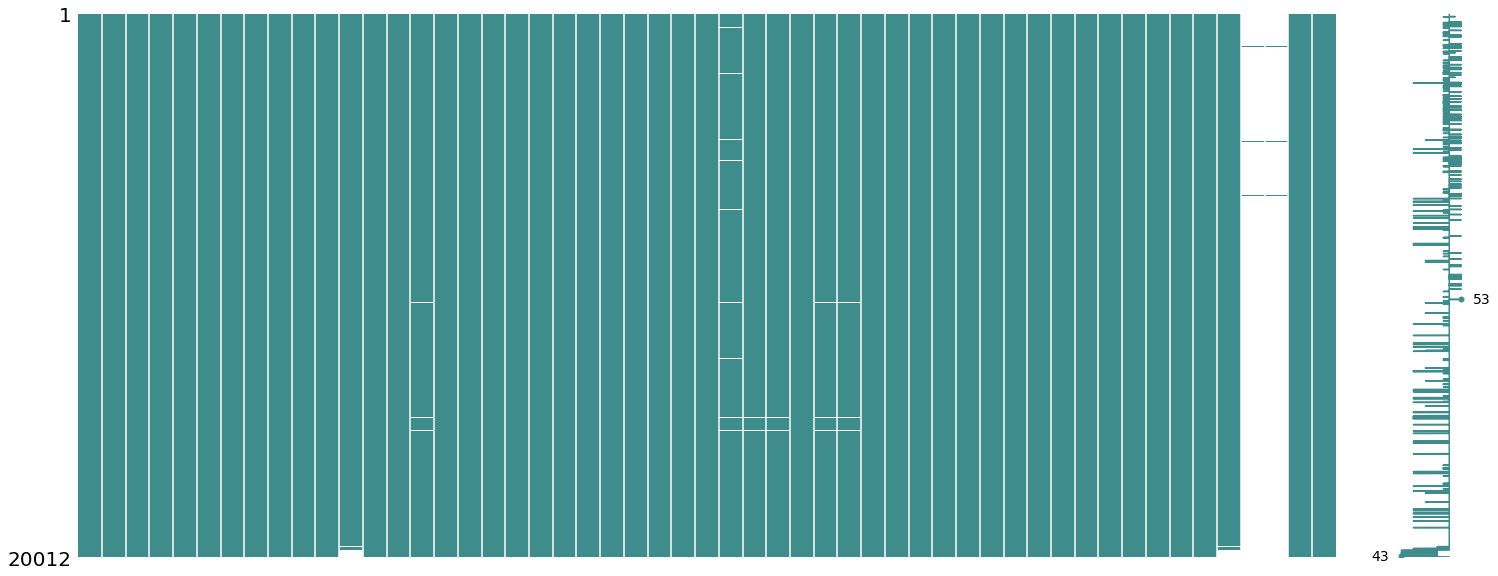

In [11]:
msno.matrix(df, color = (0.25, 0.55, 0.55))

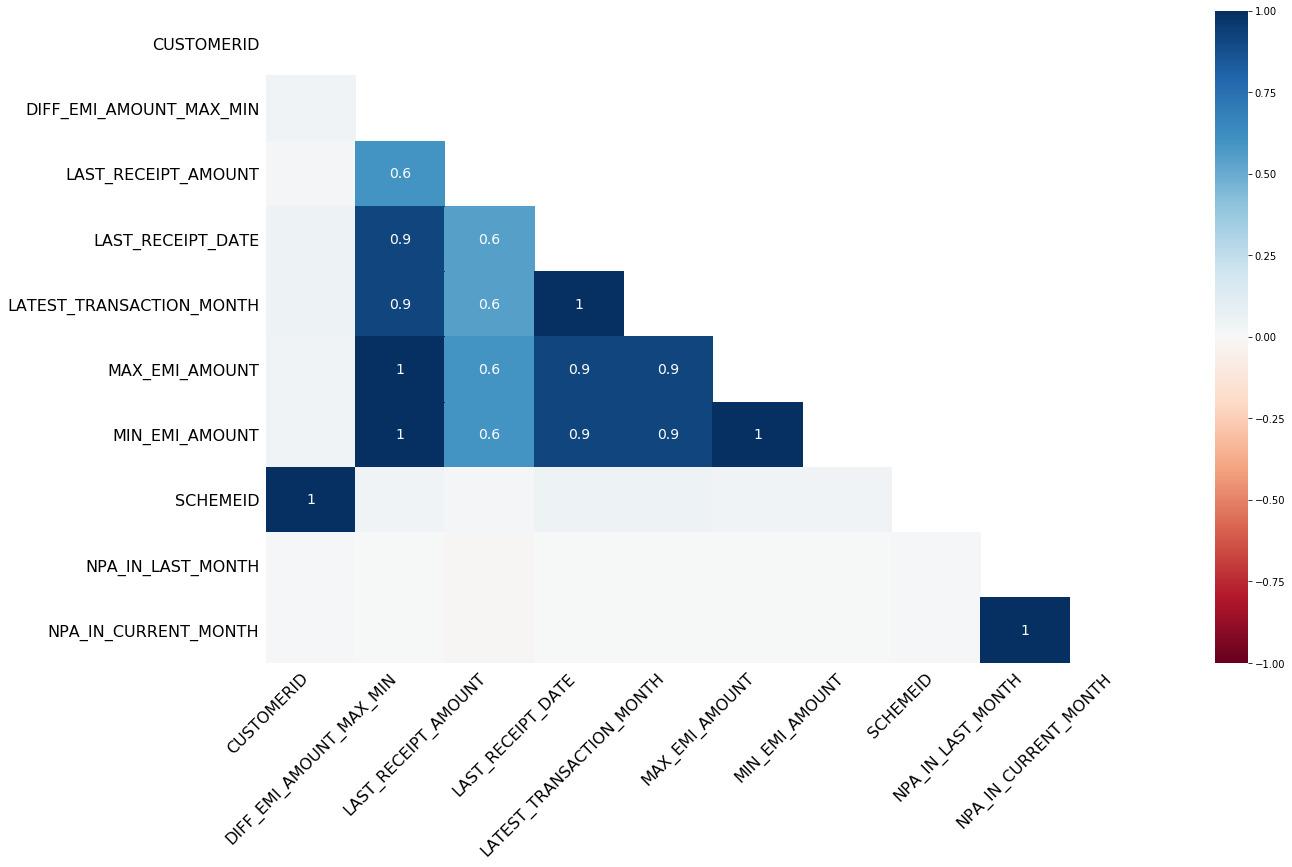

In [12]:
msno.heatmap(df)

##### Percentage of missing values

In [13]:
round(df.isna().sum() / len(df), 4).sort_values(ascending = False)

NPA_IN_CURRENT_MONTH                   0.9941
NPA_IN_LAST_MONTH                      0.9941
CUSTOMERID                             0.0140
SCHEMEID                               0.0140
LAST_RECEIPT_AMOUNT                    0.0123
MAX_EMI_AMOUNT                         0.0044
MIN_EMI_AMOUNT                         0.0044
DIFF_EMI_AMOUNT_MAX_MIN                0.0044
LAST_RECEIPT_DATE                      0.0037
LATEST_TRANSACTION_MONTH               0.0037
DIFF_CURRENT_INTEREST_RATE_MAX_MIN     0.0000
EMI_AMOUNT                             0.0000
DUEDAY                                 0.0000
DPD                                    0.0000
DIFF_ORIGINAL_CURRENT_TENOR            0.0000
DIFF_ORIGINAL_CURRENT_INTEREST_RATE    0.0000
FORECLOSURE                            0.0000
DIFF_AUTH_INT_DATE                     0.0000
EMI_OS_AMOUNT                          0.0000
CURRENT_TENOR                          0.0000
CURRENT_INTEREST_RATE_CHANGES          0.0000
CURRENT_INTEREST_RATE_MIN         

##### Unique value count

In [14]:
print('Unique values in the dataset:\n')

for i in df.columns:
    print('_' * 50)
    print(i + ':', df[i].nunique(), 'unique values')
    print(df[i].value_counts())

Unique values in the dataset:

__________________________________________________
AGREEMENTID: 20012 unique values
11241471    1
11246198    1
11229806    1
11227759    1
11250288    1
           ..
11251039    1
11228512    1
11230561    1
11224418    1
11239424    1
Name: AGREEMENTID, Length: 20012, dtype: int64
__________________________________________________
AUTHORIZATIONDATE: 1694 unique values
2018-03-31    528
2018-06-30    484
2018-08-31    456
2018-05-31    435
2018-02-28    435
             ... 
2011-10-21      1
2018-02-13      1
2013-10-23      1
2012-12-24      1
2012-02-02      1
Name: AUTHORIZATIONDATE, Length: 1694, dtype: int64
__________________________________________________
BALANCE_EXCESS: 3130 unique values
0.000000        12568
260.609136       1055
1.104276          584
0.441710          581
1303.045680       185
                ...  
8194.169630         1
47481.659448        1
41807.889360        1
333.137984          1
1268.813124         1
Name: BALANCE_EXC

MIN_EMI_AMOUNT: 6455 unique values
118.00      6049
115.00      2391
5900.00      361
570.00       319
562.00       317
            ... 
2906.00        1
187.83         1
422.34         1
1166.47        1
28167.00       1
Name: MIN_EMI_AMOUNT, Length: 6455, dtype: int64
__________________________________________________
MONTHOPENING: 19060 unique values
3.753240e+06    33
3.002592e+06    27
1.501296e+06    25
2.251944e+06    17
2.402073e+06    14
                ..
8.016814e+05     1
1.116281e+06     1
4.954276e+07     1
1.471783e+06     1
1.527343e+06     1
Name: MONTHOPENING, Length: 19060, dtype: int64
__________________________________________________
NET_DISBURSED_AMT: 8901 unique values
1.501296e+06    612
3.002592e+06    473
2.251944e+06    348
3.753240e+06    331
1.801555e+06    232
               ... 
1.403325e+07      1
4.942135e+06      1
4.080645e+06      1
5.319685e+07      1
3.997951e+06      1
Name: NET_DISBURSED_AMT, Length: 8901, dtype: int64
__________________________

#### Univariate Analysis

In [15]:
# separating numeric and categorical data

df_num = df.select_dtypes(include = 'number')
df_cat = df.select_dtypes(exclude = 'number')

##### Distribution Plot

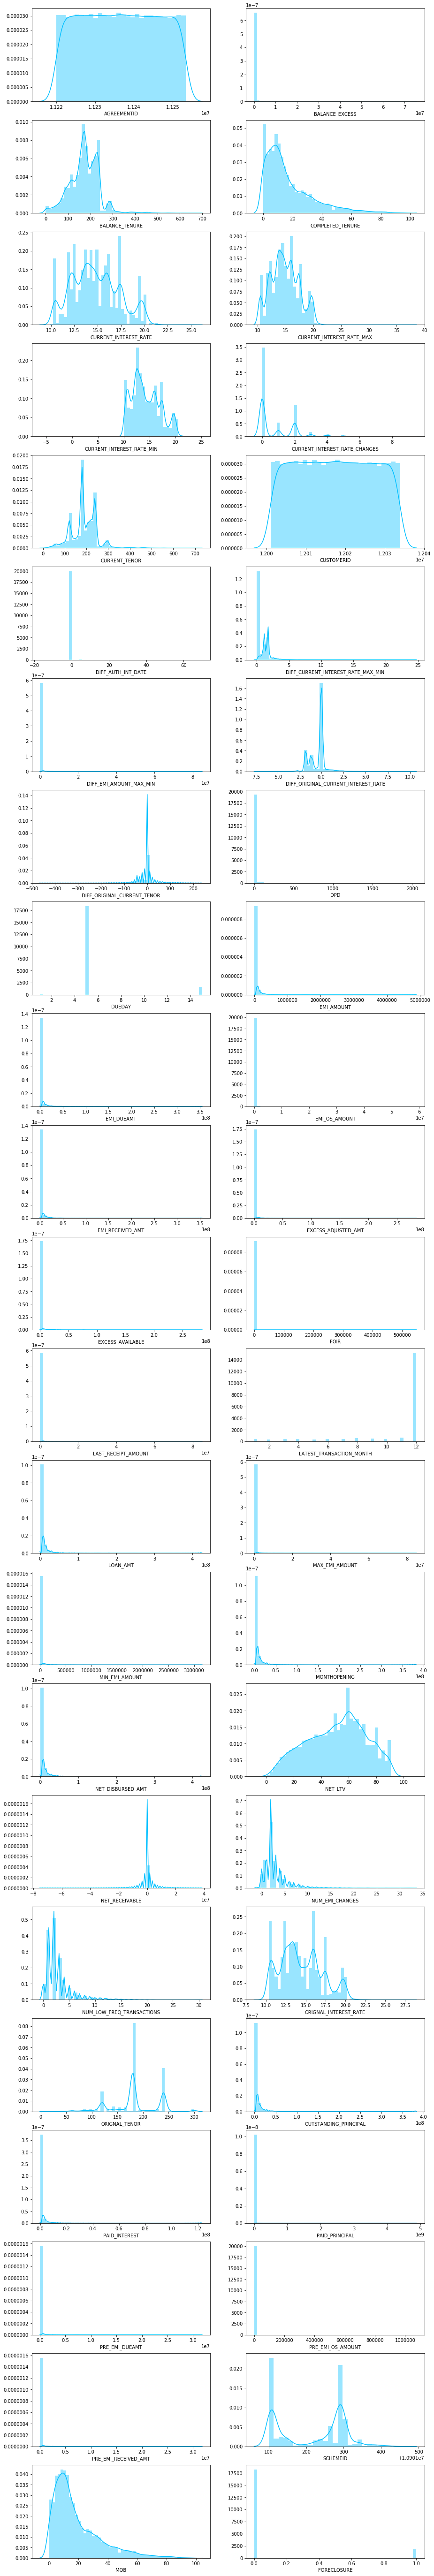

In [16]:
# distibution of numeric data

fig, ax = plt.subplots(figsize = (15, 100), nrows = 23, ncols = 2)

for i, col in enumerate(df_num.columns):
    try:
        sns.distplot(df_num[col], ax = ax[i//2, i%2], color = 'deepskyblue', hist = True)
    except:
        sns.distplot(df_num[col], ax = ax[i//2, i%2], kde = False, color = 'deepskyblue')

In [17]:
# skewness in the numeric variables

round(df.skew().sort_values(ascending = False), 2)

FOIR                                   141.46
PAID_PRINCIPAL                         139.43
DIFF_AUTH_INT_DATE                      94.53
PRE_EMI_OS_AMOUNT                       74.46
LAST_RECEIPT_AMOUNT                     67.90
EMI_OS_AMOUNT                           55.96
DIFF_EMI_AMOUNT_MAX_MIN                 46.40
MAX_EMI_AMOUNT                          45.97
PRE_EMI_RECEIVED_AMT                    43.62
PRE_EMI_DUEAMT                          43.42
EXCESS_ADJUSTED_AMT                     41.57
EXCESS_AVAILABLE                        36.12
BALANCE_EXCESS                          34.31
MIN_EMI_AMOUNT                          33.19
EMI_RECEIVED_AMT                        16.18
EMI_DUEAMT                              15.83
DPD                                     15.50
EMI_AMOUNT                              13.34
PAID_INTEREST                           13.21
OUTSTANDING_PRINCIPAL                   11.67
MONTHOPENING                            11.20
NET_DISBURSED_AMT                 

##### Observations

1. None of the variables seem to be normally distributed
2. Several variables like “PAID_PRINCIPAL”, “EMI_AMOUNT”, “FOIR” etc. seem to be severely right skewed
3. Several variables like “NET_RECEIVABLE” and “LATEST_TRANSACTION_MONTH” are moderately left skewed
4. “ORIGNAL_INTEREST_RATE”, “CURRENT_INTEREST_RATE” “CURRENT_TENOR” etc. have a multimodal distribution
5. Most of the variables with differences such as “DIFF_ORIGINAL_CURRENT_INTEREST_RATE”, “DIFF_CURRENT_INTEREST_RATE_MAX_MIN”, “DIFF_ORIGINAL_CURRENT_TENOR” etc. have the greatest mode at/around 0. 


##### Boxplot

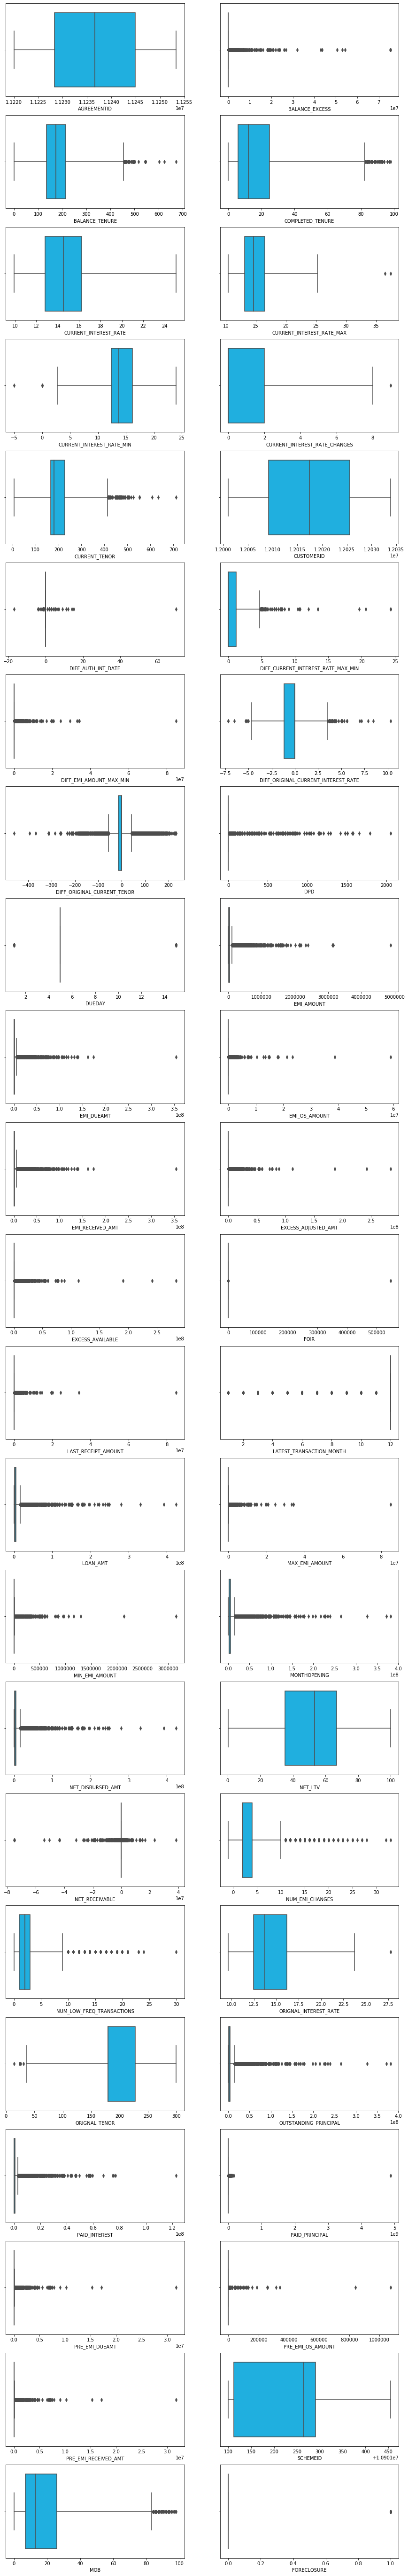

In [18]:
# boxplot of numeric data

fig, ax = plt.subplots(figsize = (15, 100)
                       , nrows = 23, ncols = 2)

for i, col in enumerate(df_num.columns):
    sns.boxplot(df_num[col], ax = ax[i//2, i%2], whis = 3, color = 'deepskyblue')

In [19]:
# outlier analysis - statistical

q1 = df.quantile(0.25)
q3 = df.quantile(0.75)
IQR = q3 - q1
upper_range = q3 + (IQR*1.5)
lower_range = q1 - (IQR*1.5)
extreme_upper_range = q3 + (IQR*3)
extreme_lower_range = q1 - (IQR*3)

In [20]:
pd.DataFrame(((df_num < extreme_lower_range) | (df_num > extreme_upper_range)).sum(), 
             columns = ['No. of Outliers']).sort_values(by = 'No. of Outliers', ascending = False)

,No. of Outliers
NET_RECEIVABLE,5860
LATEST_TRANSACTION_MONTH,4734
BALANCE_EXCESS,4462
EXCESS_ADJUSTED_AMT,4419
EXCESS_AVAILABLE,4392
DIFF_EMI_AMOUNT_MAX_MIN,2081
MAX_EMI_AMOUNT,2056
MIN_EMI_AMOUNT,1809
FORECLOSURE,1795
PRE_EMI_RECEIVED_AMT,1760


In [21]:
pd.DataFrame(((df_num < extreme_lower_range) | (df_num > extreme_upper_range)).sum(), 
             columns = ['No. of Outliers']).sort_values(by = 'No. of Outliers', ascending = False) / len(df)

,No. of Outliers
NET_RECEIVABLE,0.292824
LATEST_TRANSACTION_MONTH,0.236558
BALANCE_EXCESS,0.222966
EXCESS_ADJUSTED_AMT,0.220818
EXCESS_AVAILABLE,0.219468
DIFF_EMI_AMOUNT_MAX_MIN,0.103988
MAX_EMI_AMOUNT,0.102738
MIN_EMI_AMOUNT,0.090396
FORECLOSURE,0.089696
PRE_EMI_RECEIVED_AMT,0.087947


##### Observations:
1. From the boxplots below, we can see that several variables contain outliers. 
2. Over 10% of the data in variables such as net receivables, balance excess, max EMI amount etc. are outliers
3. Several variables such as balance excess, max EMI amount, current interest rate max, etc. have data points that are much farther away from their natural clusters. Such variables will have to be studied further.


##### Countplot

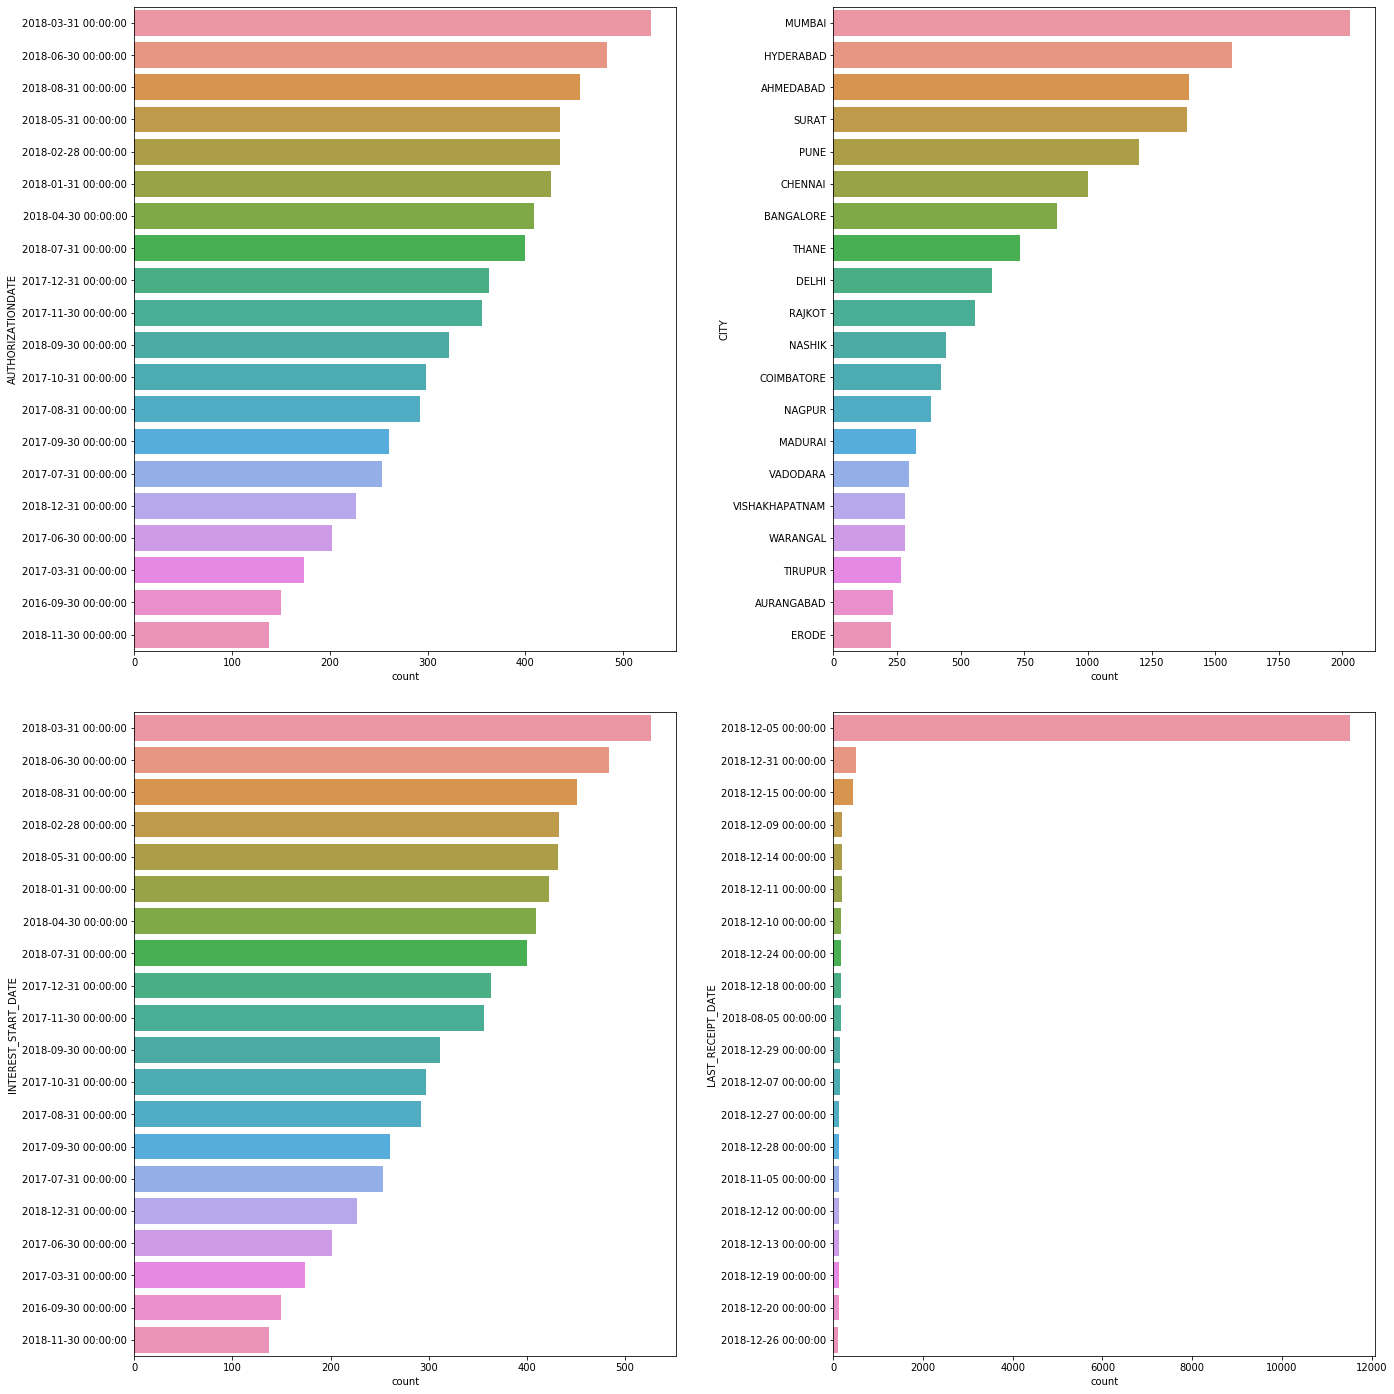

In [22]:
# distibution of categorical data - top 20

fig, ax = plt.subplots(figsize = (20, 20), nrows = 2, ncols = 2)

for i, col in enumerate(df_cat.columns[:4]):
    sns.countplot(y = df_cat[col], ax = ax[i//2, i%2], order = df_cat[col].value_counts().index[:20])
    plt.tight_layout(pad = 3.0)
    
plt.show()

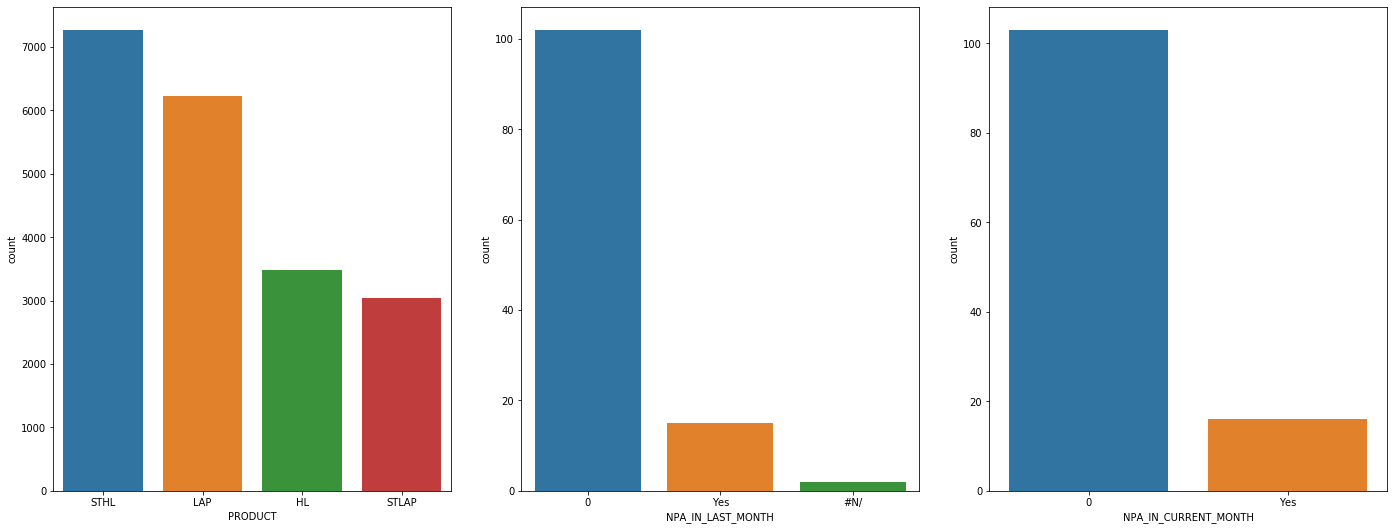

In [23]:
# distibution of categorical data

fig, ax = plt.subplots(figsize = (20, 8), nrows = 1, ncols = 3)

for i, col in enumerate(df_cat.columns[4:]):
    sns.countplot(df_cat[col], ax = ax[i], order = df_cat[col].value_counts().index)
    plt.tight_layout(pad = 3.0)

plt.show()

##### Observations
1. The end dates in the months seem to have the highest number of loans authorized
2. The highest number of loans were authorized on March 31, 2018 followed by June 30, 2018. 
3. Most of the loans originate from Mumbai, followed by Hyderabad and Ahmedabad
4. Interest start date is very closely associated with the authorization date and tends to follow a similar pattern stated above
5. December 5, 2018 has seen an unusual number of payments received
6. STHL is the most popular loan product with over 7000 loans under this label, followed by LAP. STLAP is the least popular in the lot
7. 0 NPA in last and current month with a count of little over 100. However, there are a lot of missing values in these two variables


#### Bivariate Analysis

##### Correlation Heatmap

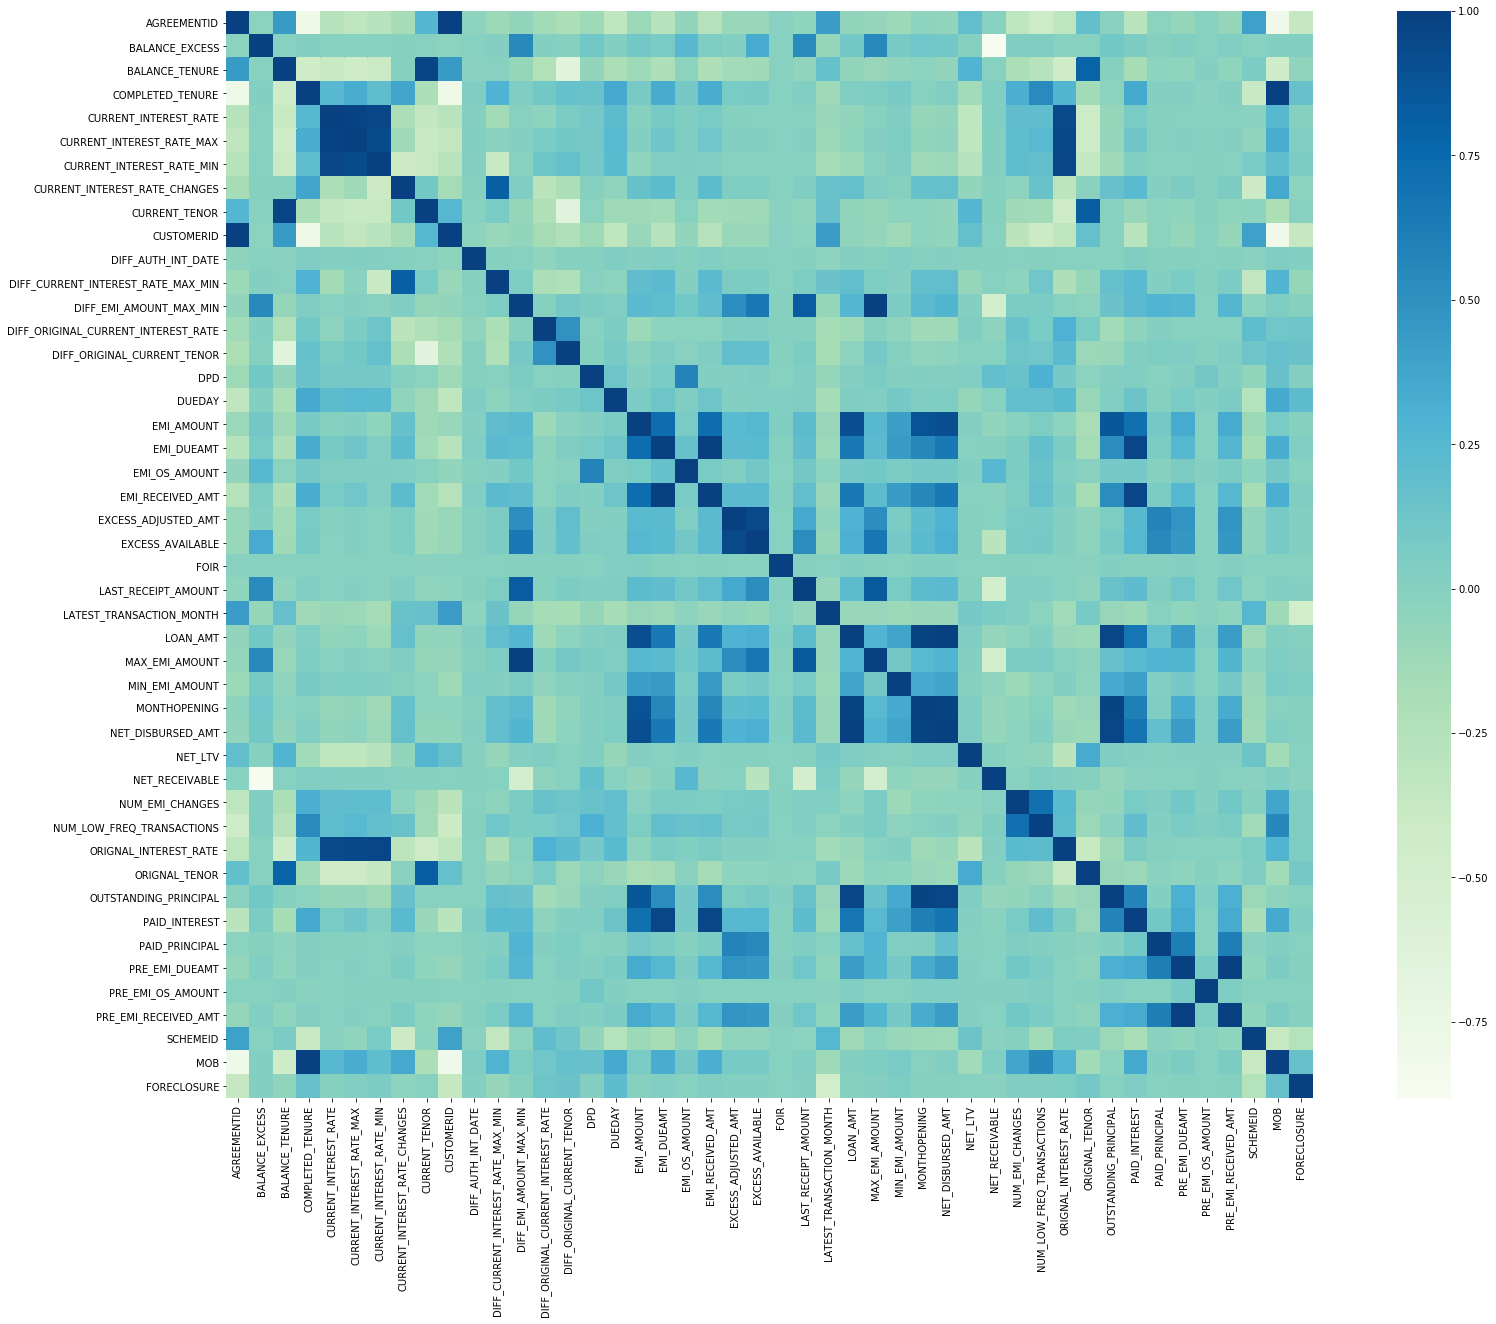

In [24]:
plt.figure(figsize = (30, 20))

sns.heatmap(df.corr(), square = True, annot_kws = {'size': 1.2}, cmap = 'GnBu')

##### Observations
1. Since a lot of the variables are derived, a strong relationship is seen between the original and the derived variables, such as Net Receivable with Balance Excess, Diff_original_current_tenor with balance tenor etc.
2. Completed tenure has a very strong correlation with MOB


In [25]:
# absolute correlation with target variable

abs(df.corr()['FORECLOSURE']).sort_values(ascending = False)

FORECLOSURE                            1.000000
LATEST_TRANSACTION_MONTH               0.464067
CUSTOMERID                             0.364344
AGREEMENTID                            0.364058
SCHEMEID                               0.255963
DUEDAY                                 0.207742
MOB                                    0.161123
COMPLETED_TENURE                       0.159146
DIFF_ORIGINAL_CURRENT_TENOR            0.142767
DIFF_ORIGINAL_CURRENT_INTEREST_RATE    0.131511
ORIGNAL_TENOR                          0.089323
DIFF_CURRENT_INTEREST_RATE_MAX_MIN     0.073862
BALANCE_TENURE                         0.053532
CURRENT_INTEREST_RATE_MIN              0.052700
ORIGNAL_INTEREST_RATE                  0.048652
MIN_EMI_AMOUNT                         0.048556
PAID_INTEREST                          0.043619
NUM_LOW_FREQ_TRANSACTIONS              0.032469
CURRENT_INTEREST_RATE_CHANGES          0.032034
NUM_EMI_CHANGES                        0.031655
EMI_RECEIVED_AMT                       0

##### Bi/Multi-variate Analysis with Target Variable 

In [26]:
# two sets created - one with no foreclosure another with foreclosures only

df_nofc = df[df['FORECLOSURE'] == 0]
df_fc = df[df['FORECLOSURE'] == 1]

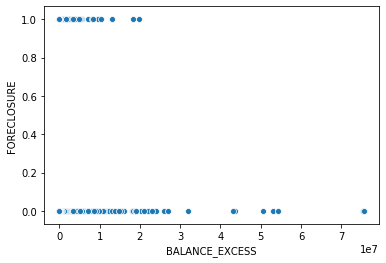

In [27]:
sns.scatterplot(x = df['BALANCE_EXCESS'], y = df['FORECLOSURE'])

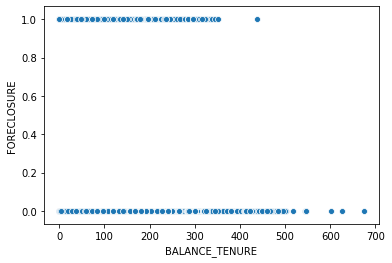

In [28]:
sns.scatterplot(x = df['BALANCE_TENURE'], y = df['FORECLOSURE'])

In [29]:
df.groupby('PRODUCT')['FORECLOSURE'].sum().sort_values(ascending = False)

PRODUCT
HL       990
STHL     803
LAP        2
STLAP      0
Name: FORECLOSURE, dtype: int64

Text(0, 0.5, 'Foreclosures')

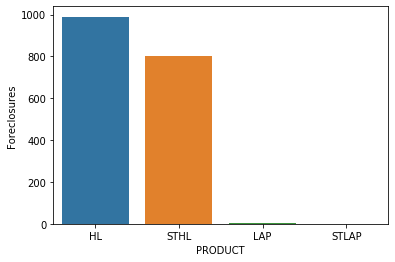

In [30]:
sns.countplot(x = df_fc['PRODUCT'], order = df.groupby('PRODUCT')['FORECLOSURE'].sum().sort_values(ascending = False).index)
plt.ylabel('Foreclosures')

1. Loan product LAP has only 2 foreclosures out of 6000+ records
2. Product STLAP has 0 foreclosures

In [31]:
df.groupby('ORIGNAL_INTEREST_RATE')['FORECLOSURE'].sum().sort_values(ascending = False)

ORIGNAL_INTEREST_RATE
17.479728    428
13.421934    287
13.109796    229
13.734072    130
14.046210    102
            ... 
14.857769      0
14.795341      0
14.782856      0
14.770370      0
9.651307       0
Name: FORECLOSURE, Length: 199, dtype: int64

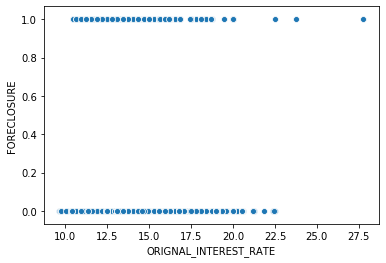

In [32]:
sns.scatterplot(x = df['ORIGNAL_INTEREST_RATE'], y = df['FORECLOSURE'])

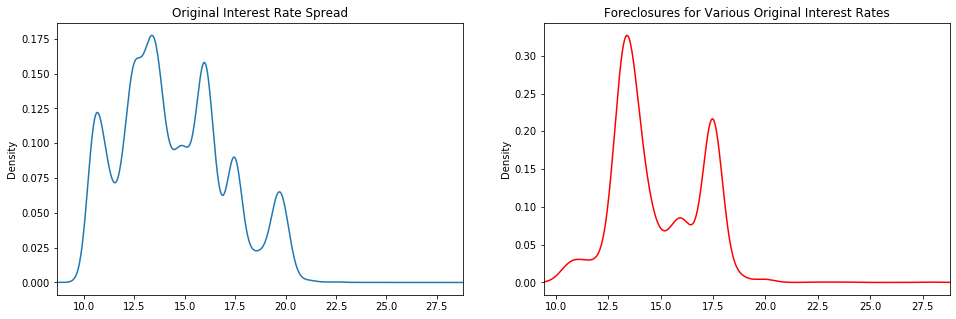

In [33]:
ax, fig = plt.subplots(figsize = (16, 5), nrows = 1, ncols = 2)

plt.subplot(1,2,1)
df['ORIGNAL_INTEREST_RATE'].plot(kind = 'kde')
plt.title('Original Interest Rate Spread')
plt.xlim(df['ORIGNAL_INTEREST_RATE'].min()-1, df['ORIGNAL_INTEREST_RATE'].max()+1)

plt.subplot(1,2,2)
df_fc['ORIGNAL_INTEREST_RATE'].plot(kind = 'kde', color = 'red')
plt.title('Foreclosures for Various Original Interest Rates')
plt.xlim(df_fc['ORIGNAL_INTEREST_RATE'].min()-1, df_fc['ORIGNAL_INTEREST_RATE'].max()+1)

plt.show()

Foreclosures are high for customers whose original interest rate is around 17 and 13%

In [ ]:
ax, fig = plt.subplots(figsize = (16, 5), nrows = 1, ncols = 2)

plt.subplot(1,2,1)
sns.countplot(y = df['CITY'], order = df['CITY'].value_counts().sort_values(ascending = False).index[:15])
plt.title('Number of Loans by City')

plt.subplot(1,2,2)
sns.countplot(y = df_fc['CITY'], order = df.groupby('CITY')['FORECLOSURE'].sum().sort_values(ascending = False).index[:15])
plt.title('Number of Foreclosures by City')

plt.show()

In [35]:
df.groupby('CITY')['FORECLOSURE'].sum().sort_values(ascending = False)

CITY
MUMBAI         353
HYDERABAD      165
PUNE           151
CHENNAI        109
AHMEDABAD       90
              ... 
NAVELIM          0
NARMADA          0
NANDURBAR        0
NALGONDA         0
24 PARGANAS      0
Name: FORECLOSURE, Length: 272, dtype: int64

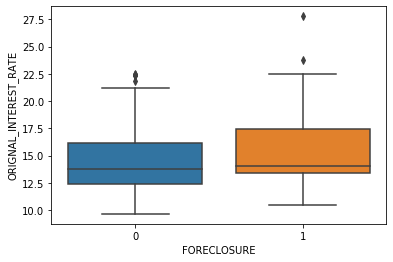

In [36]:
sns.boxplot(x = df['FORECLOSURE'], y = df['ORIGNAL_INTEREST_RATE'])

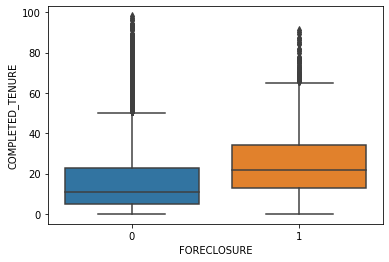

In [37]:
sns.boxplot(x = df['FORECLOSURE'], y = df['COMPLETED_TENURE'])

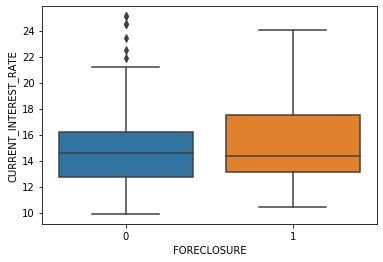

In [38]:
sns.boxplot(x = df['FORECLOSURE'], y = df['CURRENT_INTEREST_RATE'])

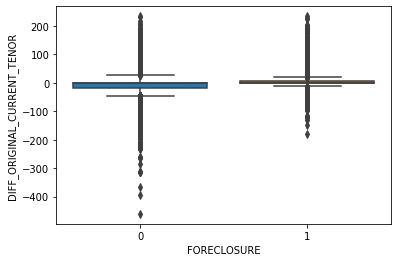

In [39]:
sns.boxplot(x = df['FORECLOSURE'], y = df['DIFF_ORIGINAL_CURRENT_TENOR'])

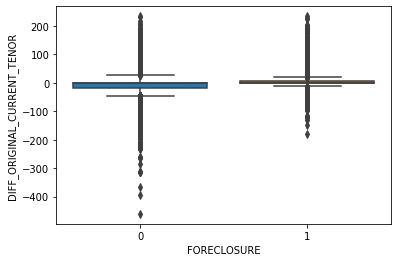

In [40]:
sns.boxplot(x = df['FORECLOSURE'], y = df['DIFF_ORIGINAL_CURRENT_TENOR'])

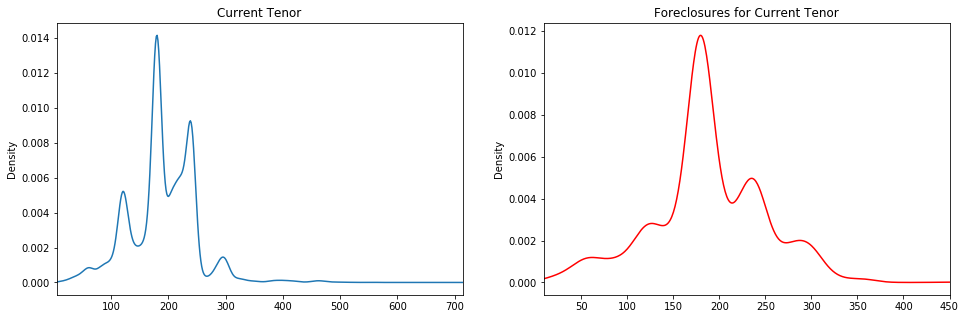

In [41]:
ax, fig = plt.subplots(figsize = (16, 5), nrows = 1, ncols = 2)

plt.subplot(1,2,1)
df['CURRENT_TENOR'].plot(kind = 'kde')
plt.title('Current Tenor')
plt.xlim(df['CURRENT_TENOR'].min()-1, df['CURRENT_TENOR'].max()+1)

plt.subplot(1,2,2)
df_fc['CURRENT_TENOR'].plot(kind = 'kde', color = 'red')
plt.title('Foreclosures for Current Tenor')
plt.xlim(df_fc['CURRENT_TENOR'].min()-1, df_fc['CURRENT_TENOR'].max()+1)

plt.show()

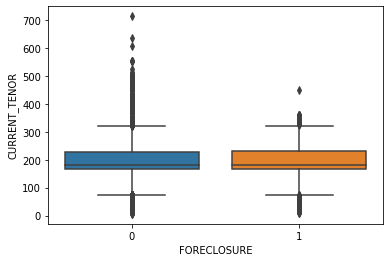

In [42]:
sns.boxplot(x = df['FORECLOSURE'], y = df['CURRENT_TENOR'])

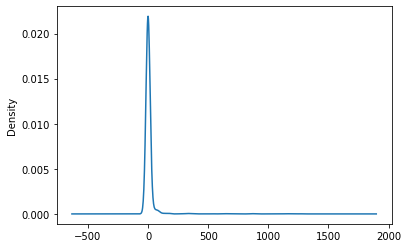

In [43]:
df_fc['DPD'].plot(kind = 'kde')

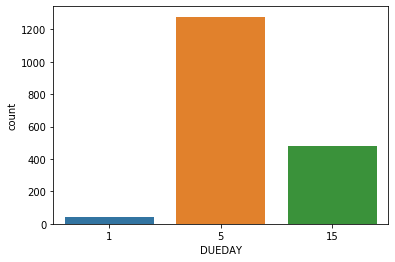

In [44]:
sns.countplot(df_fc['DUEDAY'])

Customers whose due day is on 5th of the month foreclose the most out of all

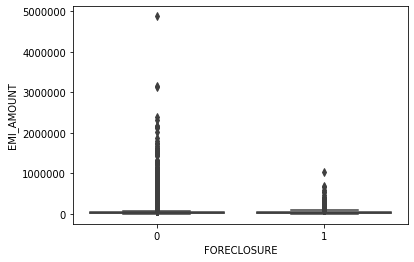

In [45]:
sns.boxplot(x = df['FORECLOSURE'], y = df['EMI_AMOUNT'])

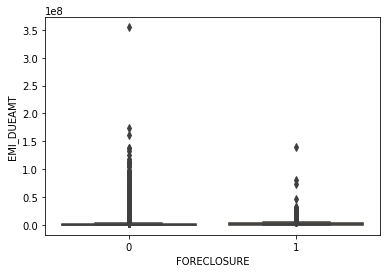

In [46]:
sns.boxplot(x = df['FORECLOSURE'], y = df['EMI_DUEAMT'])

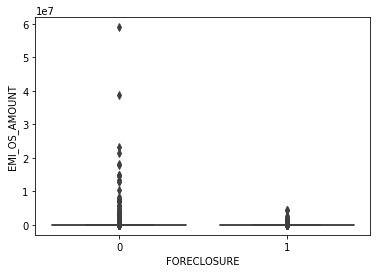

In [47]:
sns.boxplot(x = df['FORECLOSURE'], y = df['EMI_OS_AMOUNT'])

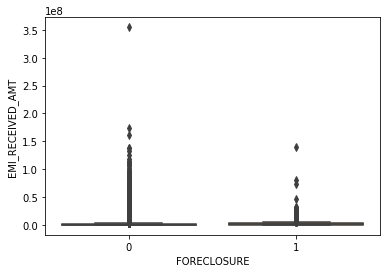

In [48]:
sns.boxplot(x = df['FORECLOSURE'], y = df['EMI_RECEIVED_AMT'])

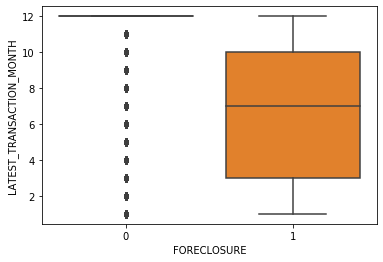

In [49]:
sns.boxplot(x = df['FORECLOSURE'], y = df['LATEST_TRANSACTION_MONTH'])

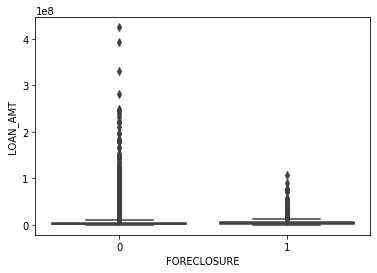

In [50]:
sns.boxplot(x = df['FORECLOSURE'], y = df['LOAN_AMT'])

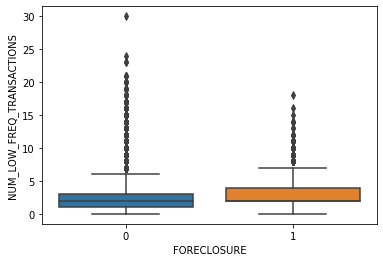

In [51]:
sns.boxplot(x = df['FORECLOSURE'], y = df['NUM_LOW_FREQ_TRANSACTIONS'])

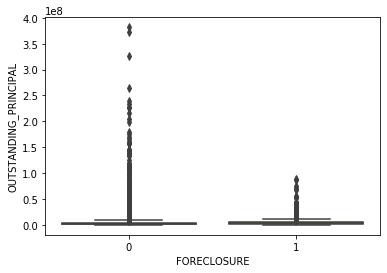

In [52]:
sns.boxplot(x = df['FORECLOSURE'], y = df['OUTSTANDING_PRINCIPAL'])

In [53]:
schemeid_pivot = pd.pivot_table(df, values = 'FORECLOSURE', index = 'SCHEMEID', aggfunc = 'sum').sort_values(by = 'FORECLOSURE', ascending = False)
schemeid_pivot

,FORECLOSURE
SCHEMEID,
10901104.0,775
10901112.0,462
10901291.0,56
10901142.0,52
10901251.0,50
...,...
10901224.0,0
10901225.0,0
10901226.0,0


In [54]:
schemeid_pivot['CUMSUM_%'] = np.cumsum(schemeid_pivot) / schemeid_pivot['FORECLOSURE'].sum()

In [55]:
schemeid_pivot['CUMSUM_%']

SCHEMEID
10901104.0    0.431755
10901112.0    0.689136
10901291.0    0.720334
10901142.0    0.749304
10901251.0    0.777159
                ...   
10901224.0    1.000000
10901225.0    1.000000
10901226.0    1.000000
10901227.0    1.000000
10901455.0    1.000000
Name: CUMSUM_%, Length: 235, dtype: float64

Just 2 scheme IDs (10901104 & 10901112) out of 236 accounts for 69% of foreclosures

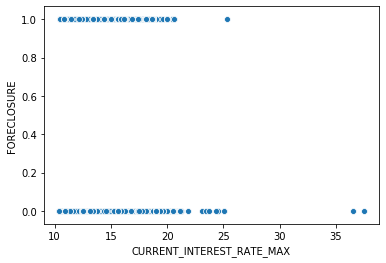

In [56]:
sns.scatterplot(x = df['CURRENT_INTEREST_RATE_MAX'], y = df['FORECLOSURE'])

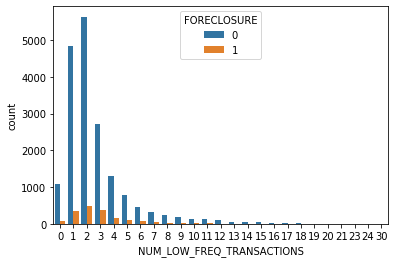

In [57]:
sns.countplot(x = df['NUM_LOW_FREQ_TRANSACTIONS'], hue = df['FORECLOSURE'])

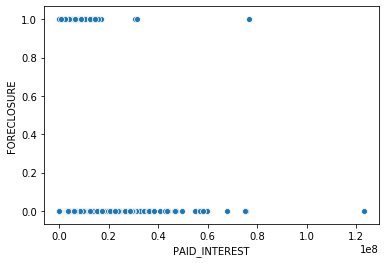

In [58]:
sns.scatterplot(x = df['PAID_INTEREST'], y = df['FORECLOSURE'])

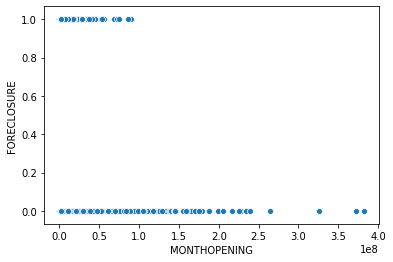

In [59]:
sns.scatterplot(df['MONTHOPENING'], y = df['FORECLOSURE'])

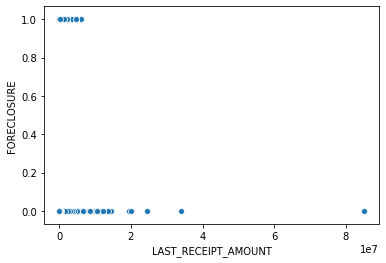

In [60]:
sns.scatterplot(df['LAST_RECEIPT_AMOUNT'], y = df['FORECLOSURE'])

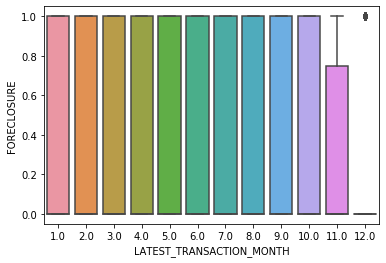

In [61]:
sns.boxplot(x = df['LATEST_TRANSACTION_MONTH'], y = df['FORECLOSURE'])

In [62]:
df['AUTHORIZATIONDATE'].nunique()

1694

In [63]:
df['ISMONTHEND'] = df['AUTHORIZATIONDATE'].dt.is_month_end

In [64]:
monthend_fc = df.groupby(['ISMONTHEND'])['FORECLOSURE'].sum().sort_values(ascending = False)
monthend_fc

ISMONTHEND
False    1084
True      711
Name: FORECLOSURE, dtype: int64

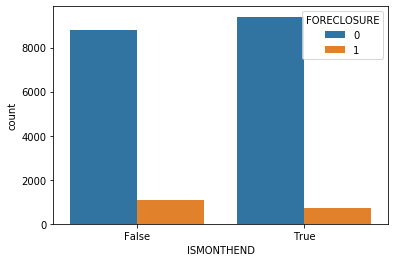

In [65]:
sns.countplot(df['ISMONTHEND'], hue = df['FORECLOSURE'])

Most loans are given out on a month end.

In [66]:
authdate_fc = df.groupby(['AUTHORIZATIONDATE'])['FORECLOSURE'].sum().sort_values(ascending = False)
authdate_fc

AUTHORIZATIONDATE
2014-03-31    28
2015-03-31    26
2013-03-31    23
2015-07-31    23
2015-10-31    19
              ..
2017-02-14     0
2017-02-15     0
2017-02-17     0
2017-02-21     0
2018-12-31     0
Name: FORECLOSURE, Length: 1694, dtype: int64

In [67]:
df['ISMONTHEND2'] = df['INTEREST_START_DATE'].dt.is_month_end

In [68]:
monthend_fc = df.groupby(['ISMONTHEND2'])['FORECLOSURE'].sum().sort_values(ascending = False)
monthend_fc

ISMONTHEND2
False    1092
True      703
Name: FORECLOSURE, dtype: int64

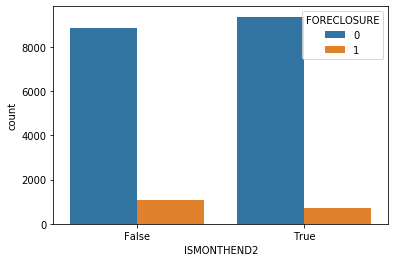

In [69]:
sns.countplot(df['ISMONTHEND2'], hue = df['FORECLOSURE'])

Most loans are given out on a month end.

In [70]:
authdate_fc = df.groupby(['INTEREST_START_DATE'])['FORECLOSURE'].sum().sort_values(ascending = False)
authdate_fc

INTEREST_START_DATE
2014-03-31    28
2015-03-31    26
2013-03-31    23
2015-07-31    23
2015-10-31    19
              ..
2017-02-15     0
2014-06-28     0
2017-02-17     0
2017-02-21     0
2018-12-31     0
Name: FORECLOSURE, Length: 1699, dtype: int64

In [71]:
df.drop(['ISMONTHEND', 'ISMONTHEND2'], axis = 1, inplace = True)

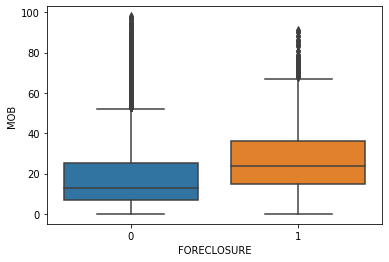

In [72]:
sns.boxplot(x = df['FORECLOSURE'], y = df['MOB'])

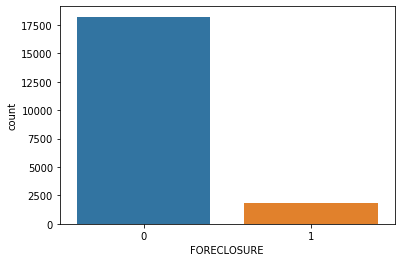

In [73]:
sns.countplot(df['FORECLOSURE'])

In [74]:
df['CITY'].nunique()

272

In [75]:
# Some same city names identified to have been spelt differently or spelt in colloquial way
# Replacing such duplicates to contain just one of the spellings

#  'THIRUVALLUR', 
#  'TIRUVALLUR',

#  'THIRUVANAMALAI',
#  'TIRUVANNAMALAI', 
    
#  'THIRUVARUR'    
#  'TIRUVALLUR',
    
#  'THOOTHUKKUDI',
#  'TUTICORIN'

#  'TIRUCHIRAPPALLI',
#  'TRICHY',
    
#  'VIJAYWADA'
#  'VIJAYAWADA',
    
#  'VILLUPPURAM',
#  'VILLUPURAM',
    
    
df['CITY'].replace(['THIRUVALLUR', 'THIRUVANAMALAI', 'THIRUVARUR', 'THOOTHUKKUDI', 'TIRUCHIRAPPALLI', 'VIJAYWADA', 'VILLUPPURAM'],
                   ['TIRUVALLUR', 'TIRUVANNAMALAI', 'TIRUVALLUR', 'TUTICORIN', 'TRICHY', 'VIJAYAWADA', 'VILLUPURAM'], inplace = True)

In [76]:
df['CITY'].nunique()

265

#### Removal of unwanted variables

In [77]:
df['AGREEMENTID'].duplicated().sum()

0

In [78]:
df['CUSTOMERID'].duplicated().sum() #the 280 duplicate values are missing values so technically there are no repeating IDs

280

In [79]:
df.drop(['NPA_IN_CURRENT_MONTH', 'NPA_IN_LAST_MONTH', 'AGREEMENTID', 'CUSTOMERID'], axis = 1, inplace = True)

#### Outlier treatment

Every variable was given individual attention prior deciding to treat outliers in them. In this case, a lot of variables are dependent on each other and using capping/flooring method or mean/median/mode imputation etc. of a single datapoint might hamper the integrity and the functional relationship between variables. Thus, through a detailed study of the visuals from the boxplots and records in the dataset and exercising judgement, only the extreme data points/records were eliminated/dropped. Here, extreme datapoints refer to datapoints which are much farther away from the general cluster of points in a variable. These are unnatural and may hamper the generalization capability of the algorithms. In total, 50 records were dropped which is just about 0.25% of the original records.

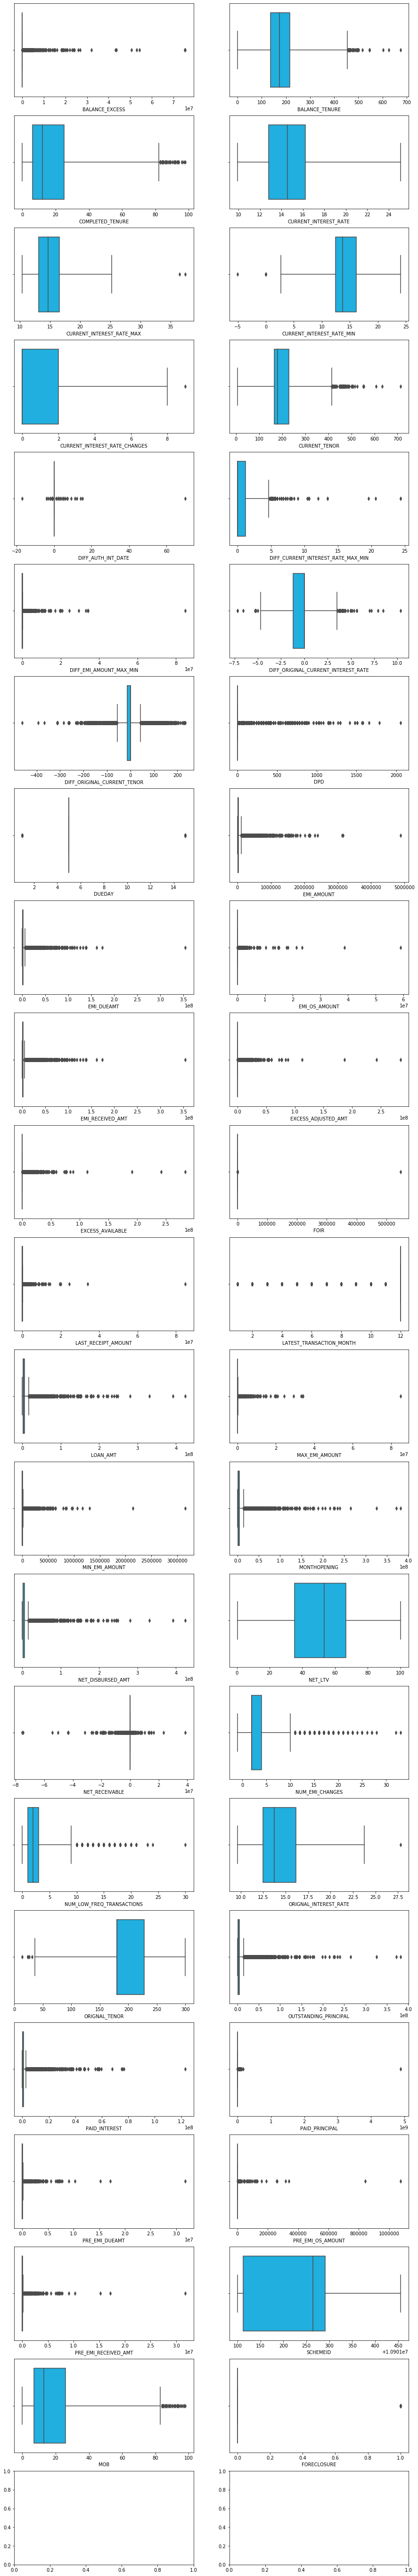

In [80]:
# boxplot of numeric data

df_num = df.select_dtypes(include = 'number')
df_cat = df.select_dtypes(exclude = 'number')

fig, ax = plt.subplots(figsize = (15, 100), nrows = 23, ncols = 2)

for i, col in enumerate(df_num.columns):
    sns.boxplot(df_num[col], ax = ax[i//2, i%2], whis = 3, color = 'deepskyblue')

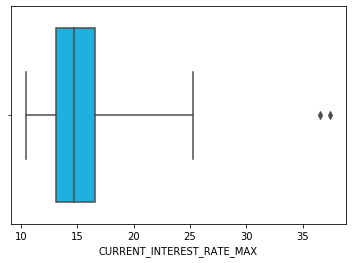

In [81]:
sns.boxplot(df['CURRENT_INTEREST_RATE_MAX'], whis = 3, color = 'deepskyblue')

In [82]:
df[df['CURRENT_INTEREST_RATE_MAX'] > extreme_upper_range['CURRENT_INTEREST_RATE_MAX']]

,AUTHORIZATIONDATE,BALANCE_EXCESS,BALANCE_TENURE,CITY,COMPLETED_TENURE,...,PRE_EMI_RECEIVED_AMT,PRODUCT,SCHEMEID,MOB,FORECLOSURE
8509,2017-04-30,129.200292,202,PUNE,17,...,3.490815e+05,LAP,10901255.0,20,0
9481,2017-07-31,3157.345939,135,NASHIK,14,...,2.422092e+06,LAP,10901221.0,17,0


In [83]:
df.drop(df[df['CURRENT_INTEREST_RATE_MAX'] > extreme_upper_range['CURRENT_INTEREST_RATE_MAX']].index, inplace = True)

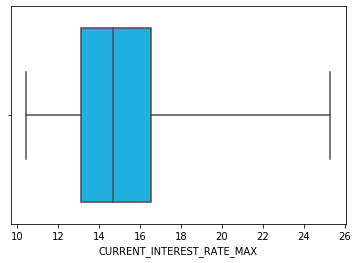

In [84]:
sns.boxplot(df['CURRENT_INTEREST_RATE_MAX'], whis = 3, color = 'deepskyblue')

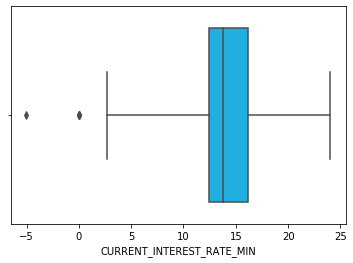

In [85]:
sns.boxplot(df['CURRENT_INTEREST_RATE_MIN'], whis = 3, color = 'deepskyblue')

In [86]:
df[df['CURRENT_INTEREST_RATE_MIN'] < 0]

,AUTHORIZATIONDATE,BALANCE_EXCESS,BALANCE_TENURE,CITY,COMPLETED_TENURE,...,PRE_EMI_RECEIVED_AMT,PRODUCT,SCHEMEID,MOB,FORECLOSURE
3489,2015-03-23,2.009782,18,SURAT,31,...,743301.426912,LAP,10901168.0,32,0


In [87]:
df.drop(df[df['CURRENT_INTEREST_RATE_MIN'] < 0].index, inplace = True)

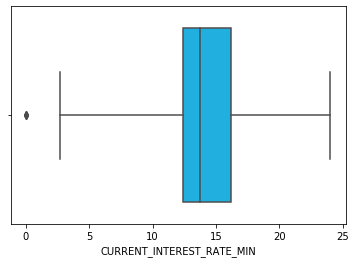

In [88]:
sns.boxplot(df['CURRENT_INTEREST_RATE_MIN'], whis = 3, color = 'deepskyblue')

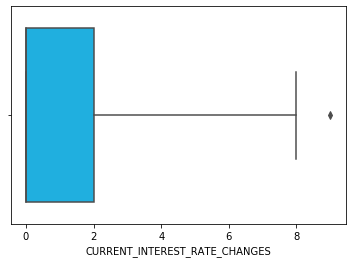

In [89]:
sns.boxplot(df['CURRENT_INTEREST_RATE_CHANGES'], whis = 3, color = 'deepskyblue')

In [90]:
df[df['CURRENT_INTEREST_RATE_CHANGES'] > extreme_upper_range['CURRENT_INTEREST_RATE_CHANGES']]

,AUTHORIZATIONDATE,BALANCE_EXCESS,BALANCE_TENURE,CITY,COMPLETED_TENURE,...,PRE_EMI_RECEIVED_AMT,PRODUCT,SCHEMEID,MOB,FORECLOSURE
2781,2014-09-30,0.0,57,MUMBAI,50,...,18311.104632,HL,10901104.0,51,0


In [91]:
df.drop(df[df['CURRENT_INTEREST_RATE_CHANGES'] > extreme_upper_range['CURRENT_INTEREST_RATE_CHANGES']].index, inplace = True)

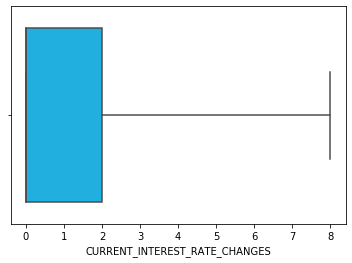

In [92]:
sns.boxplot(df['CURRENT_INTEREST_RATE_CHANGES'], whis = 3, color = 'deepskyblue')

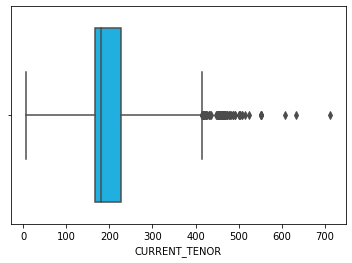

In [93]:
sns.boxplot(df['CURRENT_TENOR'], whis = 3, color = 'deepskyblue')

In [94]:
pd.set_option('display.max_columns', 100)
df[df['CURRENT_TENOR'] > 550]

,AUTHORIZATIONDATE,BALANCE_EXCESS,BALANCE_TENURE,CITY,COMPLETED_TENURE,CURRENT_INTEREST_RATE,CURRENT_INTEREST_RATE_MAX,CURRENT_INTEREST_RATE_MIN,CURRENT_INTEREST_RATE_CHANGES,CURRENT_TENOR,DIFF_AUTH_INT_DATE,DIFF_CURRENT_INTEREST_RATE_MAX_MIN,DIFF_EMI_AMOUNT_MAX_MIN,DIFF_ORIGINAL_CURRENT_INTEREST_RATE,DIFF_ORIGINAL_CURRENT_TENOR,DPD,DUEDAY,EMI_AMOUNT,EMI_DUEAMT,EMI_OS_AMOUNT,EMI_RECEIVED_AMT,EXCESS_ADJUSTED_AMT,EXCESS_AVAILABLE,FOIR,INTEREST_START_DATE,LAST_RECEIPT_AMOUNT,LAST_RECEIPT_DATE,LATEST_TRANSACTION_MONTH,LOAN_AMT,MAX_EMI_AMOUNT,MIN_EMI_AMOUNT,MONTHOPENING,NET_DISBURSED_AMT,NET_LTV,NET_RECEIVABLE,NUM_EMI_CHANGES,NUM_LOW_FREQ_TRANSACTIONS,ORIGNAL_INTEREST_RATE,ORIGNAL_TENOR,OUTSTANDING_PRINCIPAL,PAID_INTEREST,PAID_PRINCIPAL,PRE_EMI_DUEAMT,PRE_EMI_OS_AMOUNT,PRE_EMI_RECEIVED_AMT,PRODUCT,SCHEMEID,MOB,FORECLOSURE
4250,2015-08-24,0.000000,674,DELHI,39,16.168748,16.168748,14.046210,5,713,0,2.122538,161681.0,-1.810400,-461,0,5,162251.0,1.397525e+07,0.0,1.397525e+07,0.000000,0.000000,0.59,2015-08-24,162251.0,2018-12-10,12.0,2.311996e+07,162251.0,570.0,2.255539e+07,2.311996e+07,70.23,0.000000,3,12,14.358348,252,2.255539e+07,9.023950e+06,564560.784294,130379.658768,0.0,130379.658768,HL,10901104.0,40,0
13189,2018-02-28,0.000000,625,DELHI,9,13.172224,13.172224,10.737547,3,634,0,2.434676,87736.0,-2.434676,-394,0,5,87854.0,1.746271e+06,0.0,1.746271e+06,0.000000,0.000000,0.82,2018-02-28,87854.0,2018-12-05,12.0,1.508802e+07,87854.0,118.0,1.493854e+07,1.508802e+07,41.02,0.000000,2,1,10.737547,240,1.493854e+07,1.055594e+06,149482.521510,26513.666760,0.0,26513.666760,HL,10901104.0,10,0
15166,2018-04-30,0.000000,545,WARANGAL,7,15.482045,15.482045,13.734072,2,552,0,1.747973,25615.0,-1.747973,-312,0,5,25733.0,3.978287e+05,0.0,3.978287e+05,0.000000,0.000000,0.57,2018-04-30,25733.0,2018-12-05,12.0,3.742730e+06,25733.0,118.0,3.724781e+06,3.742730e+06,41.40,0.000000,2,1,13.734072,240,3.724781e+06,2.581989e+05,17949.492585,8412.374568,0.0,8412.374568,LAP,10901106.0,8,0
15317,2018-04-30,0.000000,545,AHMEDABAD,7,15.482045,15.482045,13.734072,2,552,0,1.747973,8724.0,-1.747973,-312,0,5,8960.0,1.385204e+05,0.0,1.385204e+05,521.218272,521.218272,0.81,2018-04-30,8960.0,2018-12-05,12.0,1.303125e+06,8960.0,236.0,1.296875e+06,1.303125e+06,23.99,0.000000,1,2,13.734072,240,1.296875e+06,8.990360e+04,6249.894415,2930.748504,0.0,2930.748504,LAP,10901113.0,8,0
15406,2018-04-30,116262.594384,546,WARANGAL,7,15.482045,15.482045,13.734072,2,553,0,1.747973,26203.0,-1.747973,-313,0,5,26321.0,4.069191e+05,0.0,4.069191e+05,0.000000,116262.594384,0.55,2018-04-30,26321.0,2018-12-05,12.0,3.828304e+06,26321.0,118.0,3.809948e+06,3.828304e+06,49.78,-116262.594384,1,3,13.734072,240,3.809948e+06,2.641020e+05,18356.343747,8604.518592,0.0,8604.518592,LAP,10901106.0,8,0
15774,2018-05-28,0.000000,602,CHENNAI,6,15.482045,15.482045,13.734072,2,608,0,1.747973,47248.0,-1.747973,-368,0,15,47366.0,6.276616e+05,0.0,6.276616e+05,260.609136,260.609136,0.55,2018-05-28,47366.0,2018-12-15,12.0,6.889200e+06,47366.0,118.0,6.867350e+06,6.889200e+06,50.36,0.000000,2,1,13.734072,240,6.867350e+06,4.427036e+05,21849.859073,55741.643928,0.0,55741.643928,LAP,10901106.0,7,0
16161,2018-05-31,0.000000,546,HYDERABAD,6,15.482045,15.482045,13.734072,2,552,0,1.747973,31880.0,-1.747973,-312,0,5,31998.0,4.240155e+05,0.0,4.240155e+05,0.000000,0.000000,0.53,2018-05-31,31998.0,2018-12-05,12.0,4.654017e+06,31998.0,118.0,4.631753e+06,4.654017e+06,57.68,0.000000,2,2,13.734072,240,4.631753e+06,2.730782e+05,22264.216714,10461.910824,0.0,10461.910824,LAP,10901106.0,7,0
16196,2018-05-31,0.000000,546,HYDERABAD,6,15.482045,15.482045,13.734072,2,552,0,1.747973,47363.0,-1.747973,-312,0,5,47481.0,6.291855e+05,0.0,6.291855e+05,0.000000,0.000000,0.74,2018-05-31,47481.0,2018-12-05,12.0,6.905961e+06,47481.0,118.0,6.872917e+06,6.905961e+06,51.69,0.000000,1,2,13.734072,240,6.872917e+06,4.052057e+05,33043.520558,15521.703456,0.0,15521.703456,LAP,10901106.0,7,0


In [95]:
df.drop(df[df['CURRENT_TENOR'] > 550].index, inplace = True)

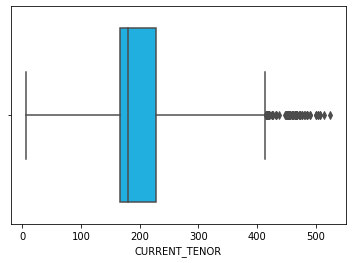

In [96]:
sns.boxplot(df['CURRENT_TENOR'], whis = 3, color = 'deepskyblue')

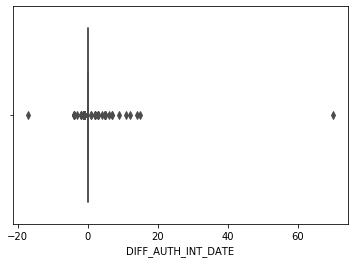

In [97]:
sns.boxplot(df['DIFF_AUTH_INT_DATE'], whis = 3, color = 'deepskyblue')

In [98]:
df[(df['DIFF_AUTH_INT_DATE'] == df['DIFF_AUTH_INT_DATE'].max()) | (df['DIFF_AUTH_INT_DATE'] == df['DIFF_AUTH_INT_DATE'].min())]

,AUTHORIZATIONDATE,BALANCE_EXCESS,BALANCE_TENURE,CITY,COMPLETED_TENURE,CURRENT_INTEREST_RATE,CURRENT_INTEREST_RATE_MAX,CURRENT_INTEREST_RATE_MIN,CURRENT_INTEREST_RATE_CHANGES,CURRENT_TENOR,DIFF_AUTH_INT_DATE,DIFF_CURRENT_INTEREST_RATE_MAX_MIN,DIFF_EMI_AMOUNT_MAX_MIN,DIFF_ORIGINAL_CURRENT_INTEREST_RATE,DIFF_ORIGINAL_CURRENT_TENOR,DPD,DUEDAY,EMI_AMOUNT,EMI_DUEAMT,EMI_OS_AMOUNT,EMI_RECEIVED_AMT,EXCESS_ADJUSTED_AMT,EXCESS_AVAILABLE,FOIR,INTEREST_START_DATE,LAST_RECEIPT_AMOUNT,LAST_RECEIPT_DATE,LATEST_TRANSACTION_MONTH,LOAN_AMT,MAX_EMI_AMOUNT,MIN_EMI_AMOUNT,MONTHOPENING,NET_DISBURSED_AMT,NET_LTV,NET_RECEIVABLE,NUM_EMI_CHANGES,NUM_LOW_FREQ_TRANSACTIONS,ORIGNAL_INTEREST_RATE,ORIGNAL_TENOR,OUTSTANDING_PRINCIPAL,PAID_INTEREST,PAID_PRINCIPAL,PRE_EMI_DUEAMT,PRE_EMI_OS_AMOUNT,PRE_EMI_RECEIVED_AMT,PRODUCT,SCHEMEID,MOB,FORECLOSURE
7,2010-12-24,0.0,276,MUMBAI,52,13.421934,13.734072,13.421934,1,328,-17,0.312138,0.0,-2.809242,-28,0,1,210232.0,2.301301e+07,464308.304064,2.254871e+07,464308.304064,464308.304064,0.60,2010-12-07,210232.0,2015-04-01,4.0,3.296034e+07,210232.0,210232.0,3.225103e+07,3.296034e+07,87.75,464308.304064,0,1,10.612692,300,3.225103e+07,1.477209e+07,7.093083e+05,225932.661048,0.0,225932.661048,HL,10901100.0,52,1
40,2011-02-28,0.0,1,MUMBAI,32,18.416142,18.416142,18.416142,0,33,70,0.000000,0.0,-3.433518,87,0,15,118466.0,8.372426e+06,0.000000,8.372426e+06,0.000000,0.000000,0.37,2011-05-09,118466.0,2014-01-15,1.0,1.291114e+07,118466.0,118466.0,9.758198e+06,1.291114e+07,60.80,0.000000,0,0,14.982624,120,7.483960e+04,2.607553e+06,1.283630e+07,101827.498512,0.0,101827.498512,LAP,10901117.0,32,0


In [99]:
df.drop(df[(df['DIFF_AUTH_INT_DATE'] == df['DIFF_AUTH_INT_DATE'].max()) | (df['DIFF_AUTH_INT_DATE'] == df['DIFF_AUTH_INT_DATE'].min())].index, inplace = True)

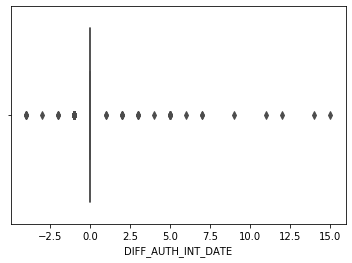

In [100]:
sns.boxplot(df['DIFF_AUTH_INT_DATE'], whis = 3, color = 'deepskyblue')

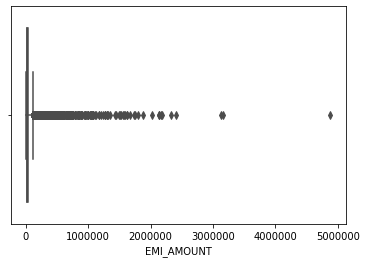

In [101]:
sns.boxplot(df['EMI_AMOUNT'], whis = 3, color = 'deepskyblue')

In [102]:
df[df['EMI_AMOUNT'] > 3000000]

,AUTHORIZATIONDATE,BALANCE_EXCESS,BALANCE_TENURE,CITY,COMPLETED_TENURE,CURRENT_INTEREST_RATE,CURRENT_INTEREST_RATE_MAX,CURRENT_INTEREST_RATE_MIN,CURRENT_INTEREST_RATE_CHANGES,CURRENT_TENOR,DIFF_AUTH_INT_DATE,DIFF_CURRENT_INTEREST_RATE_MAX_MIN,DIFF_EMI_AMOUNT_MAX_MIN,DIFF_ORIGINAL_CURRENT_INTEREST_RATE,DIFF_ORIGINAL_CURRENT_TENOR,DPD,DUEDAY,EMI_AMOUNT,EMI_DUEAMT,EMI_OS_AMOUNT,EMI_RECEIVED_AMT,EXCESS_ADJUSTED_AMT,EXCESS_AVAILABLE,FOIR,INTEREST_START_DATE,LAST_RECEIPT_AMOUNT,LAST_RECEIPT_DATE,LATEST_TRANSACTION_MONTH,LOAN_AMT,MAX_EMI_AMOUNT,MIN_EMI_AMOUNT,MONTHOPENING,NET_DISBURSED_AMT,NET_LTV,NET_RECEIVABLE,NUM_EMI_CHANGES,NUM_LOW_FREQ_TRANSACTIONS,ORIGNAL_INTEREST_RATE,ORIGNAL_TENOR,OUTSTANDING_PRINCIPAL,PAID_INTEREST,PAID_PRINCIPAL,PRE_EMI_DUEAMT,PRE_EMI_OS_AMOUNT,PRE_EMI_RECEIVED_AMT,PRODUCT,SCHEMEID,MOB,FORECLOSURE
9537,2017-07-31,2.091696e+07,137,PUNE,7,12.797658,12.797658,12.797658,0,144,0,0.000000,6313930.0,0.000000,0,0,5,3156965.0,4.880625e+07,0.0,4.880625e+07,0.000000,2.091696e+07,2.14,2017-07-31,3156965.0,2018-03-09,3.0,3.918382e+08,9470895.0,3156965.0,3.818367e+08,3.918382e+08,63.85,-2.091696e+07,1,3,12.797658,144,3.818367e+08,2.373311e+07,1.000149e+07,820616.206776,0.0,820616.206776,LAP,10901105.0,8,0
9591,2017-08-31,0.000000e+00,74,CHENNAI,15,15.794183,15.794183,14.046210,2,89,0,1.747973,4879007.0,-1.747973,-5,0,5,4879479.0,1.616487e+08,0.0,1.616487e+08,975903.915000,9.759039e+05,0.68,2017-08-31,4879479.0,2018-12-09,12.0,4.245665e+08,4879479.0,472.0,3.723008e+08,4.245665e+08,60.43,0.000000e+00,3,3,14.046210,84,3.723008e+08,5.828081e+07,5.226570e+07,975903.915000,0.0,975903.915000,LAP,10901103.0,16,0
14606,2018-03-31,1.382691e+07,79,PUNE,7,14.545631,14.545631,12.797658,2,86,0,1.747973,3209375.0,-1.747973,-2,0,5,3130304.0,4.874386e+07,0.0,4.874386e+07,141752.796062,1.396867e+07,0.00,2018-03-31,64200.0,2018-11-22,11.0,2.808924e+08,3209493.0,118.0,2.647643e+08,2.808924e+08,49.37,-1.382691e+07,4,3,12.797658,84,2.647643e+08,1.740610e+07,1.612814e+07,588265.493616,0.0,588265.493616,LAP,10901190.0,8,0


In [103]:
df.drop(df[df['EMI_AMOUNT'] > 3000000].index, inplace = True)

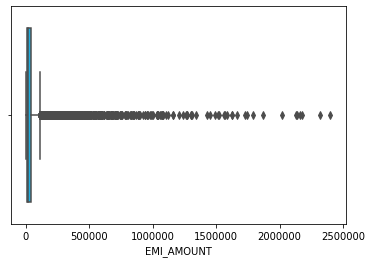

In [104]:
sns.boxplot(df['EMI_AMOUNT'], whis = 3, color = 'deepskyblue')

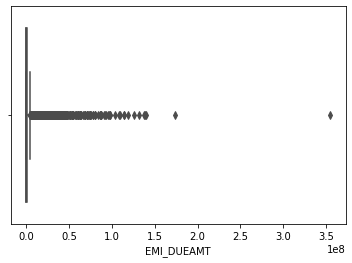

In [105]:
sns.boxplot(df['EMI_DUEAMT'], whis = 3, color = 'deepskyblue')

In [106]:
df[df['EMI_DUEAMT'] > 150000000]

,AUTHORIZATIONDATE,BALANCE_EXCESS,BALANCE_TENURE,CITY,COMPLETED_TENURE,CURRENT_INTEREST_RATE,CURRENT_INTEREST_RATE_MAX,CURRENT_INTEREST_RATE_MIN,CURRENT_INTEREST_RATE_CHANGES,CURRENT_TENOR,DIFF_AUTH_INT_DATE,DIFF_CURRENT_INTEREST_RATE_MAX_MIN,DIFF_EMI_AMOUNT_MAX_MIN,DIFF_ORIGINAL_CURRENT_INTEREST_RATE,DIFF_ORIGINAL_CURRENT_TENOR,DPD,DUEDAY,EMI_AMOUNT,EMI_DUEAMT,EMI_OS_AMOUNT,EMI_RECEIVED_AMT,EXCESS_ADJUSTED_AMT,EXCESS_AVAILABLE,FOIR,INTEREST_START_DATE,LAST_RECEIPT_AMOUNT,LAST_RECEIPT_DATE,LATEST_TRANSACTION_MONTH,LOAN_AMT,MAX_EMI_AMOUNT,MIN_EMI_AMOUNT,MONTHOPENING,NET_DISBURSED_AMT,NET_LTV,NET_RECEIVABLE,NUM_EMI_CHANGES,NUM_LOW_FREQ_TRANSACTIONS,ORIGNAL_INTEREST_RATE,ORIGNAL_TENOR,OUTSTANDING_PRINCIPAL,PAID_INTEREST,PAID_PRINCIPAL,PRE_EMI_DUEAMT,PRE_EMI_OS_AMOUNT,PRE_EMI_RECEIVED_AMT,PRODUCT,SCHEMEID,MOB,FORECLOSURE
536,2012-04-20,17.668416,70,AHMEDABAD,42,16.855452,16.855452,16.855452,0,112,0,0.000000,900000.0,-0.936414,-4,0,15,1873228.0,1.737591e+08,0.0,1.737591e+08,452768.619864,452786.28828,0.00,2012-04-20,1873196.0,2015-11-26,11.0,180155496.0,1873228.0,973228.0,1.356801e+08,180155496.0,55.24,-17.668416,4,10,15.919038,108,1.356801e+08,7.492595e+07,4.447543e+07,1.891921e+06,0.0,1.891921e+06,LAP,10901105.0,43,0
717,2012-08-17,0.000000,12,MUMBAI,75,24.534047,24.534047,23.347922,2,87,0,1.186124,0.0,-2.122538,-3,0,15,2140832.0,3.546104e+08,0.0,3.546104e+08,0.000000,0.00000,0.39,2012-08-17,2140832.0,2018-12-15,12.0,153132171.6,2140832.0,2140832.0,3.362941e+07,153132171.6,42.72,0.000000,0,3,22.411508,84,3.362941e+07,1.230362e+08,1.195028e+08,1.064772e+06,0.0,1.064772e+06,LAP,10901185.0,76,0


In [107]:
df.drop(df[df['EMI_DUEAMT'] > 150000000].index, inplace = True)

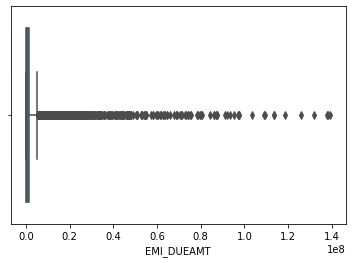

In [108]:
sns.boxplot(df['EMI_DUEAMT'], whis = 3, color = 'deepskyblue')

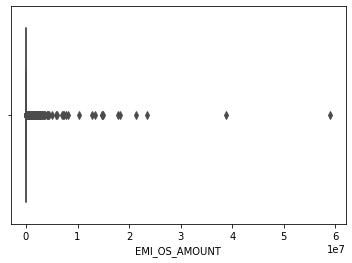

In [109]:
sns.boxplot(df['EMI_OS_AMOUNT'], whis = 3, color = 'deepskyblue')

In [110]:
df[df['EMI_OS_AMOUNT'] > 30000000]

,AUTHORIZATIONDATE,BALANCE_EXCESS,BALANCE_TENURE,CITY,COMPLETED_TENURE,CURRENT_INTEREST_RATE,CURRENT_INTEREST_RATE_MAX,CURRENT_INTEREST_RATE_MIN,CURRENT_INTEREST_RATE_CHANGES,CURRENT_TENOR,DIFF_AUTH_INT_DATE,DIFF_CURRENT_INTEREST_RATE_MAX_MIN,DIFF_EMI_AMOUNT_MAX_MIN,DIFF_ORIGINAL_CURRENT_INTEREST_RATE,DIFF_ORIGINAL_CURRENT_TENOR,DPD,DUEDAY,EMI_AMOUNT,EMI_DUEAMT,EMI_OS_AMOUNT,EMI_RECEIVED_AMT,EXCESS_ADJUSTED_AMT,EXCESS_AVAILABLE,FOIR,INTEREST_START_DATE,LAST_RECEIPT_AMOUNT,LAST_RECEIPT_DATE,LATEST_TRANSACTION_MONTH,LOAN_AMT,MAX_EMI_AMOUNT,MIN_EMI_AMOUNT,MONTHOPENING,NET_DISBURSED_AMT,NET_LTV,NET_RECEIVABLE,NUM_EMI_CHANGES,NUM_LOW_FREQ_TRANSACTIONS,ORIGNAL_INTEREST_RATE,ORIGNAL_TENOR,OUTSTANDING_PRINCIPAL,PAID_INTEREST,PAID_PRINCIPAL,PRE_EMI_DUEAMT,PRE_EMI_OS_AMOUNT,PRE_EMI_RECEIVED_AMT,PRODUCT,SCHEMEID,MOB,FORECLOSURE
801,2012-09-29,20351806.68,140,GHAZIABAD,69,17.979149,17.979149,17.479728,1,209,0,0.499421,5052000.0,-1.435835,-29,1579,5,513000.00,7.832500e+07,5.899531e+07,1.932969e+07,8.061215e+06,2.841302e+07,0.59,2012-09-29,5565000.0,2018-08-08,8.0,60201961.58,5565000.0,513000.0,5.844666e+07,60201961.58,51.29,3.864350e+07,4,9,16.543314,180,5.844666e+07,1.208053e+07,1.755300e+06,1.024163e+06,0.0,1.024163e+06,LAP,10901177.0,71,0
1106,2013-03-07,22085520.00,238,GHAZIABAD,69,14.608058,14.608058,13.421934,4,307,0,1.186124,4999439.0,-1.498262,-67,1790,5,134003.56,4.564296e+07,3.873209e+07,6.910877e+06,0.000000e+00,2.208552e+07,0.53,2013-03-07,5000000.0,2018-12-27,12.0,45038874.00,5000000.0,561.0,4.452053e+07,45038874.00,49.51,1.664657e+07,4,11,13.109796,240,4.452053e+07,4.179425e+06,5.183449e+05,0.000000e+00,0.0,0.000000e+00,HL,10901142.0,69,0


In [111]:
df.drop(df[df['EMI_OS_AMOUNT'] > 30000000].index, inplace = True)

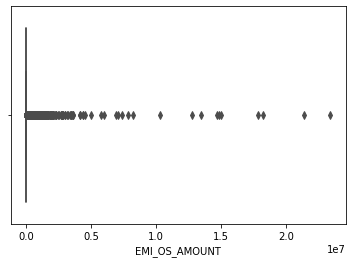

In [112]:
sns.boxplot(df['EMI_OS_AMOUNT'], whis = 3, color = 'deepskyblue')

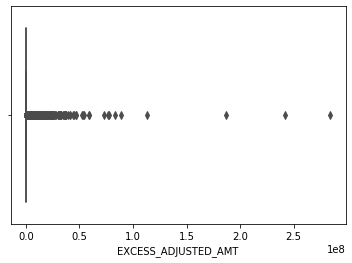

In [113]:
sns.boxplot(df['EXCESS_ADJUSTED_AMT'], whis = 3, color = 'deepskyblue')

In [114]:
df[df['EXCESS_ADJUSTED_AMT'] > 100000000]

,AUTHORIZATIONDATE,BALANCE_EXCESS,BALANCE_TENURE,CITY,COMPLETED_TENURE,CURRENT_INTEREST_RATE,CURRENT_INTEREST_RATE_MAX,CURRENT_INTEREST_RATE_MIN,CURRENT_INTEREST_RATE_CHANGES,CURRENT_TENOR,DIFF_AUTH_INT_DATE,DIFF_CURRENT_INTEREST_RATE_MAX_MIN,DIFF_EMI_AMOUNT_MAX_MIN,DIFF_ORIGINAL_CURRENT_INTEREST_RATE,DIFF_ORIGINAL_CURRENT_TENOR,DPD,DUEDAY,EMI_AMOUNT,EMI_DUEAMT,EMI_OS_AMOUNT,EMI_RECEIVED_AMT,EXCESS_ADJUSTED_AMT,EXCESS_AVAILABLE,FOIR,INTEREST_START_DATE,LAST_RECEIPT_AMOUNT,LAST_RECEIPT_DATE,LATEST_TRANSACTION_MONTH,LOAN_AMT,MAX_EMI_AMOUNT,MIN_EMI_AMOUNT,MONTHOPENING,NET_DISBURSED_AMT,NET_LTV,NET_RECEIVABLE,NUM_EMI_CHANGES,NUM_LOW_FREQ_TRANSACTIONS,ORIGNAL_INTEREST_RATE,ORIGNAL_TENOR,OUTSTANDING_PRINCIPAL,PAID_INTEREST,PAID_PRINCIPAL,PRE_EMI_DUEAMT,PRE_EMI_OS_AMOUNT,PRE_EMI_RECEIVED_AMT,PRODUCT,SCHEMEID,MOB,FORECLOSURE
641,2012-10-31,4.096888e+06,1,BANGALORE,33,14.670486,18.104004,14.670486,3,34,0,3.433518,84968249.90,1.248552,146,0,15,1203442.0,8.595399e+07,0.0,8.595399e+07,1.867143e+08,1.908112e+08,0.60,2012-10-31,84968811.9,2015-10-30,10.0,135116622.0,84968811.9,562.00,1.229708e+08,1.351166e+08,48.87,-4.096888e+06,6,4,15.919038,180,1.501296e+01,4.954889e+07,1.351166e+08,4.135006e+06,0.0,4.135006e+06,LAP,10901103.0,36,0
3668,2015-05-06,4.417104e-01,36,MUMBAI,0,13.921355,14.670486,13.921355,1,36,0,0.749131,33113161.45,0.749131,144,0,5,684919.0,0.000000e+00,0.0,0.000000e+00,2.841642e+08,2.841642e+08,0.23,2015-05-06,242513.0,2016-12-20,12.0,244711215.4,33113241.0,79.55,1.501296e+05,2.444110e+08,54.95,-4.417104e-01,14,6,14.670486,180,1.501296e+05,2.159979e+07,4.885217e+09,3.177540e+07,0.0,3.177540e+07,LAP,10901103.0,19,0
4349,2015-08-31,0.000000e+00,48,PUNE,12,18.478570,18.478570,18.478570,0,60,0,0.000000,3394380.00,0.000000,0,0,5,1490095.0,3.127325e+07,0.0,3.127325e+07,1.127483e+08,1.127483e+08,0.81,2015-08-31,386459.0,2016-10-05,10.0,105090706.0,3500000.0,105620.00,9.448650e+07,1.050907e+08,42.48,0.000000e+00,6,7,18.478570,60,2.092301e+07,1.182167e+07,8.416770e+07,1.717388e+06,0.0,1.717388e+06,LAP,10901222.0,14,0
5426,2016-03-10,1.104276e+00,6,GURGAON,3,13.546789,13.546789,13.546789,0,9,0,0.000000,1642713.00,0.000000,111,0,5,1070082.0,1.088481e+07,0.0,1.088481e+07,2.421836e+08,2.421836e+08,0.82,2016-03-10,NaN,2016-10-31,10.0,180155496.0,1642828.0,115.00,1.776203e+08,1.801555e+08,29.69,-1.104276e+00,5,1,13.546789,120,1.299247e+07,1.101510e+07,1.671630e+08,9.048957e+06,0.0,9.048957e+06,LAP,10901260.0,7,0


In [115]:
df.drop(df[df['EXCESS_ADJUSTED_AMT'] > 100000000].index, inplace = True)

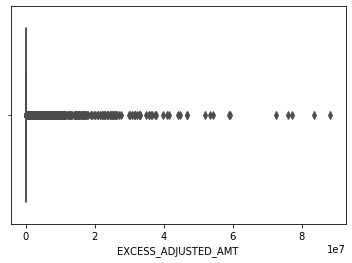

In [116]:
sns.boxplot(df['EXCESS_ADJUSTED_AMT'], whis = 3, color = 'deepskyblue')

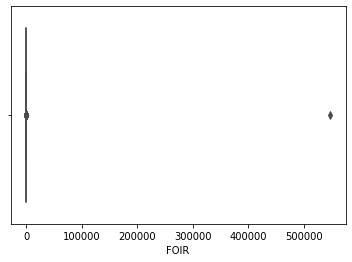

In [117]:
sns.boxplot(df['FOIR'], whis = 3, color = 'deepskyblue')

In [118]:
df[(df['FOIR'] > 225000) | (df['FOIR'] < 0)]

,AUTHORIZATIONDATE,BALANCE_EXCESS,BALANCE_TENURE,CITY,COMPLETED_TENURE,CURRENT_INTEREST_RATE,CURRENT_INTEREST_RATE_MAX,CURRENT_INTEREST_RATE_MIN,CURRENT_INTEREST_RATE_CHANGES,CURRENT_TENOR,DIFF_AUTH_INT_DATE,DIFF_CURRENT_INTEREST_RATE_MAX_MIN,DIFF_EMI_AMOUNT_MAX_MIN,DIFF_ORIGINAL_CURRENT_INTEREST_RATE,DIFF_ORIGINAL_CURRENT_TENOR,DPD,DUEDAY,EMI_AMOUNT,EMI_DUEAMT,EMI_OS_AMOUNT,EMI_RECEIVED_AMT,EXCESS_ADJUSTED_AMT,EXCESS_AVAILABLE,FOIR,INTEREST_START_DATE,LAST_RECEIPT_AMOUNT,LAST_RECEIPT_DATE,LATEST_TRANSACTION_MONTH,LOAN_AMT,MAX_EMI_AMOUNT,MIN_EMI_AMOUNT,MONTHOPENING,NET_DISBURSED_AMT,NET_LTV,NET_RECEIVABLE,NUM_EMI_CHANGES,NUM_LOW_FREQ_TRANSACTIONS,ORIGNAL_INTEREST_RATE,ORIGNAL_TENOR,OUTSTANDING_PRINCIPAL,PAID_INTEREST,PAID_PRINCIPAL,PRE_EMI_DUEAMT,PRE_EMI_OS_AMOUNT,PRE_EMI_RECEIVED_AMT,PRODUCT,SCHEMEID,MOB,FORECLOSURE
2927,2014-10-31,0.0,53,HYDERABAD,7,14.358348,14.358348,14.358348,0,60,0,0.0,541998.0,0.0,0,0,15,547616.0,8.466069e+06,0.0,8.466069e+06,69916.196921,69916.196921,547616.00,2014-10-31,547616.0,2015-08-15,8.0,3.738227e+07,547616.0,5618.0,3.404019e+07,3.738227e+07,29.67,0.0,5,1,14.358348,60,3.404019e+07,2.924676e+06,3.342071e+06,6.830080e+05,0.0,6.830080e+05,LAP,10901186.0,10,0
8055,2017-03-09,0.0,87,DELHI,10,13.297079,13.297079,13.297079,0,97,0,0.0,1241507.0,0.0,-1,0,5,1241622.0,2.742187e+07,0.0,2.742187e+07,0.000000,0.000000,-170.33,2017-03-09,1241622.0,2018-02-09,2.0,1.201037e+08,1241622.0,115.0,1.117960e+08,1.201037e+08,51.38,0.0,2,2,13.297079,96,1.117960e+08,1.123282e+07,8.307626e+06,1.324025e+06,0.0,1.324025e+06,LAP,10901121.0,11,0


In [119]:
df.drop(df[(df['FOIR'] > 225000) | (df['FOIR'] < 0)].index, inplace = True)

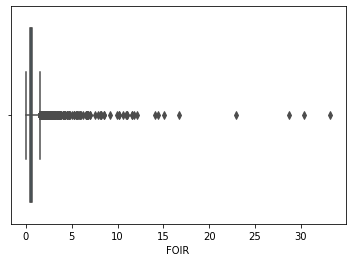

In [120]:
sns.boxplot(df['FOIR'], whis = 3, color = 'deepskyblue')

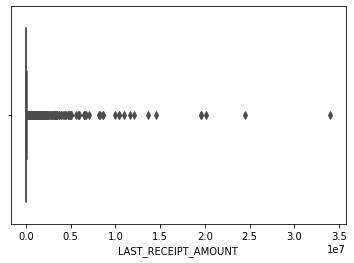

In [121]:
sns.boxplot(df['LAST_RECEIPT_AMOUNT'], whis = 3, color = 'deepskyblue')

In [122]:
df[df['LAST_RECEIPT_AMOUNT'] > 15000000]

,AUTHORIZATIONDATE,BALANCE_EXCESS,BALANCE_TENURE,CITY,COMPLETED_TENURE,CURRENT_INTEREST_RATE,CURRENT_INTEREST_RATE_MAX,CURRENT_INTEREST_RATE_MIN,CURRENT_INTEREST_RATE_CHANGES,CURRENT_TENOR,DIFF_AUTH_INT_DATE,DIFF_CURRENT_INTEREST_RATE_MAX_MIN,DIFF_EMI_AMOUNT_MAX_MIN,DIFF_ORIGINAL_CURRENT_INTEREST_RATE,DIFF_ORIGINAL_CURRENT_TENOR,DPD,DUEDAY,EMI_AMOUNT,EMI_DUEAMT,EMI_OS_AMOUNT,EMI_RECEIVED_AMT,EXCESS_ADJUSTED_AMT,EXCESS_AVAILABLE,FOIR,INTEREST_START_DATE,LAST_RECEIPT_AMOUNT,LAST_RECEIPT_DATE,LATEST_TRANSACTION_MONTH,LOAN_AMT,MAX_EMI_AMOUNT,MIN_EMI_AMOUNT,MONTHOPENING,NET_DISBURSED_AMT,NET_LTV,NET_RECEIVABLE,NUM_EMI_CHANGES,NUM_LOW_FREQ_TRANSACTIONS,ORIGNAL_INTEREST_RATE,ORIGNAL_TENOR,OUTSTANDING_PRINCIPAL,PAID_INTEREST,PAID_PRINCIPAL,PRE_EMI_DUEAMT,PRE_EMI_OS_AMOUNT,PRE_EMI_RECEIVED_AMT,PRODUCT,SCHEMEID,MOB,FORECLOSURE
6439,2016-07-30,7.534554e+07,115,BANGALORE,16,12.485520,14.982624,12.485520,1,131,0,2.497104,34007500.0,2.497104,1,0,15,497242.0,1.693641e+07,0.0,1.693641e+07,0.0000,7.534554e+07,0.58,2016-07-30,34015000.0,2018-01-31,1.0,5.457763e+07,34015000.0,7500.0,5.092889e+07,5.457763e+07,51.90,-7.534554e+07,5,5,14.982624,132,5.092889e+07,8.681985e+06,3.648739e+06,1.203279e+06,0.0,1.203279e+06,LAP,10901242.0,18,0
6616,2016-08-31,4.362212e+07,151,MUMBAI,16,12.485520,13.421934,12.485520,1,167,0,0.936414,19612611.0,0.936414,13,0,5,224190.0,7.922164e+06,0.0,7.922164e+06,13030.4568,4.363515e+07,1.28,2016-08-31,19618511.0,2018-02-28,2.0,3.002592e+07,19618511.0,5900.0,2.878941e+07,3.002592e+07,58.59,-4.362212e+07,4,3,13.421934,180,2.878941e+07,4.424451e+06,1.236506e+06,4.056536e+05,0.0,4.056536e+05,LAP,10901284.0,18,0
8506,2017-04-30,4.310605e+07,174,DELHI,15,13.921355,13.921355,13.421934,1,189,0,0.499421,19487782.0,-0.499421,-9,0,5,225289.0,7.463437e+06,0.0,7.463437e+06,0.0000,4.310605e+07,0.20,2017-04-30,19517790.0,2018-08-28,8.0,3.017304e+07,19517790.0,30008.0,2.909877e+07,3.017304e+07,64.38,-4.310605e+07,2,2,13.421934,180,2.909877e+07,4.044161e+06,1.074272e+06,6.627423e+04,0.0,6.627423e+04,LAP,10901254.0,16,0
13782,2018-02-28,5.053915e+07,186,NOIDA,4,12.672803,12.672803,12.173382,1,190,0,0.499421,20114180.0,-0.499421,-10,0,5,6000.0,2.030825e+06,0.0,2.030825e+06,0.0000,5.053915e+07,0.61,2018-02-28,20120180.0,2018-08-25,8.0,3.257812e+07,20120180.0,6000.0,3.226472e+07,3.257812e+07,55.57,-5.053915e+07,6,3,12.173382,180,3.226472e+07,1.301990e+06,3.134030e+05,3.455743e+05,0.0,3.455743e+05,LAP,10901269.0,6,0
14727,2018-03-31,5.426117e+07,282,NOIDA,7,15.045052,15.045052,12.048527,3,289,0,2.996525,24416163.0,-2.996525,-109,0,5,260164.0,4.022100e+06,0.0,4.022100e+06,0.0000,5.426117e+07,0.30,2018-03-31,24449268.0,2018-11-30,11.0,3.708201e+07,24449268.0,33105.0,3.656660e+07,3.708201e+07,62.47,-5.426117e+07,2,1,12.048527,180,3.656660e+07,2.268372e+06,5.154099e+05,7.311411e+04,0.0,7.311411e+04,LAP,10901367.0,8,0


In [123]:
df.drop(df[df['LAST_RECEIPT_AMOUNT'] > 15000000].index, inplace = True)

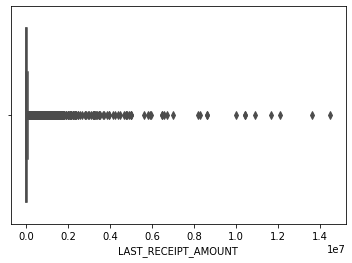

In [124]:
sns.boxplot(df['LAST_RECEIPT_AMOUNT'], whis = 3, color = 'deepskyblue')

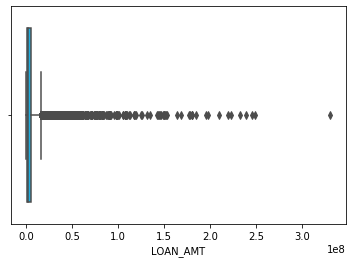

In [125]:
sns.boxplot(df['LOAN_AMT'], whis = 3, color = 'deepskyblue')

In [126]:
df[df['LOAN_AMT'] > 300000000]

,AUTHORIZATIONDATE,BALANCE_EXCESS,BALANCE_TENURE,CITY,COMPLETED_TENURE,CURRENT_INTEREST_RATE,CURRENT_INTEREST_RATE_MAX,CURRENT_INTEREST_RATE_MIN,CURRENT_INTEREST_RATE_CHANGES,CURRENT_TENOR,DIFF_AUTH_INT_DATE,DIFF_CURRENT_INTEREST_RATE_MAX_MIN,DIFF_EMI_AMOUNT_MAX_MIN,DIFF_ORIGINAL_CURRENT_INTEREST_RATE,DIFF_ORIGINAL_CURRENT_TENOR,DPD,DUEDAY,EMI_AMOUNT,EMI_DUEAMT,EMI_OS_AMOUNT,EMI_RECEIVED_AMT,EXCESS_ADJUSTED_AMT,EXCESS_AVAILABLE,FOIR,INTEREST_START_DATE,LAST_RECEIPT_AMOUNT,LAST_RECEIPT_DATE,LATEST_TRANSACTION_MONTH,LOAN_AMT,MAX_EMI_AMOUNT,MIN_EMI_AMOUNT,MONTHOPENING,NET_DISBURSED_AMT,NET_LTV,NET_RECEIVABLE,NUM_EMI_CHANGES,NUM_LOW_FREQ_TRANSACTIONS,ORIGNAL_INTEREST_RATE,ORIGNAL_TENOR,OUTSTANDING_PRINCIPAL,PAID_INTEREST,PAID_PRINCIPAL,PRE_EMI_DUEAMT,PRE_EMI_OS_AMOUNT,PRE_EMI_RECEIVED_AMT,PRODUCT,SCHEMEID,MOB,FORECLOSURE
14888,2018-03-31,260.609136,216,MUMBAI,7,13.7965,13.7965,12.048527,2,223,0,1.747973,2320788.0,-1.747973,-43,0,5,2320906.0,3.588089e+07,0.0,3.588089e+07,0.0,260.609136,0.72,2018-03-31,2320906.0,2018-12-05,12.0,3.308063e+08,2320906.0,118.0,3.260506e+08,3.308063e+08,30.56,-260.609136,2,2,12.048527,180,3.260506e+08,2.240762e+07,4.755757e+06,4.079074e+06,0.0,4.079074e+06,LAP,10901103.0,9,0


In [127]:
df.drop(df[df['LOAN_AMT'] > 300000000].index, inplace = True)

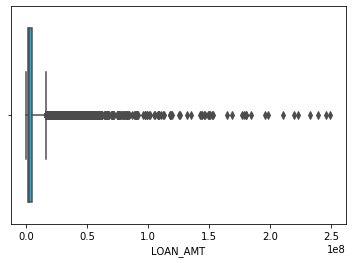

In [128]:
sns.boxplot(df['LOAN_AMT'], whis = 3, color = 'deepskyblue')

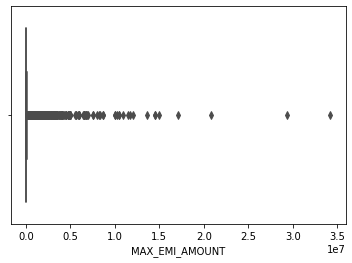

In [129]:
sns.boxplot(df['MAX_EMI_AMOUNT'], whis = 3, color = 'deepskyblue')

In [130]:
df[df['MAX_EMI_AMOUNT'] > 22500000]

,AUTHORIZATIONDATE,BALANCE_EXCESS,BALANCE_TENURE,CITY,COMPLETED_TENURE,CURRENT_INTEREST_RATE,CURRENT_INTEREST_RATE_MAX,CURRENT_INTEREST_RATE_MIN,CURRENT_INTEREST_RATE_CHANGES,CURRENT_TENOR,DIFF_AUTH_INT_DATE,DIFF_CURRENT_INTEREST_RATE_MAX_MIN,DIFF_EMI_AMOUNT_MAX_MIN,DIFF_ORIGINAL_CURRENT_INTEREST_RATE,DIFF_ORIGINAL_CURRENT_TENOR,DPD,DUEDAY,EMI_AMOUNT,EMI_DUEAMT,EMI_OS_AMOUNT,EMI_RECEIVED_AMT,EXCESS_ADJUSTED_AMT,EXCESS_AVAILABLE,FOIR,INTEREST_START_DATE,LAST_RECEIPT_AMOUNT,LAST_RECEIPT_DATE,LATEST_TRANSACTION_MONTH,LOAN_AMT,MAX_EMI_AMOUNT,MIN_EMI_AMOUNT,MONTHOPENING,NET_DISBURSED_AMT,NET_LTV,NET_RECEIVABLE,NUM_EMI_CHANGES,NUM_LOW_FREQ_TRANSACTIONS,ORIGNAL_INTEREST_RATE,ORIGNAL_TENOR,OUTSTANDING_PRINCIPAL,PAID_INTEREST,PAID_PRINCIPAL,PRE_EMI_DUEAMT,PRE_EMI_OS_AMOUNT,PRE_EMI_RECEIVED_AMT,PRODUCT,SCHEMEID,MOB,FORECLOSURE
927,2012-12-28,0.000000e+00,193,MUMBAI,11,17.479728,17.479728,17.479728,0,204,0,0.000000,29276616.6,-0.936414,-24,26,5,36466.0,8.859076e+05,79295.851008,8.066118e+05,0.0,0.000000e+00,1.00,2012-12-28,37028.0,2014-01-20,1.0,4.271187e+06,29313082.6,36466.0,4.197105e+06,4.271187e+06,34.87,7.929585e+04,2,2,16.543314,180,4.197105e+06,5.202801e+05,74081.441251,67751.749704,0.0,67751.749704,LAP,10901126.0,13,0
13176,2018-01-31,7.555600e+07,258,BANGALORE,6,12.984941,12.984941,12.485520,1,264,0,0.499421,34210532.0,-0.499421,-24,26,5,329084.0,4.360795e+06,726799.126368,3.633996e+06,0.0,7.555600e+07,0.63,2018-01-31,329084.0,2018-08-05,8.0,5.119597e+07,34210650.0,118.0,5.085548e+07,5.119597e+07,39.23,-7.482920e+07,2,5,12.485520,240,5.085548e+07,2.200874e+06,340493.887440,104603.648376,0.0,104603.648376,LAP,10901242.0,7,0


In [131]:
df.drop(df[df['MAX_EMI_AMOUNT'] > 22500000].index, inplace = True)

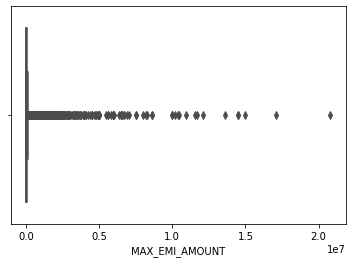

In [132]:
sns.boxplot(df['MAX_EMI_AMOUNT'], whis = 3, color = 'deepskyblue')

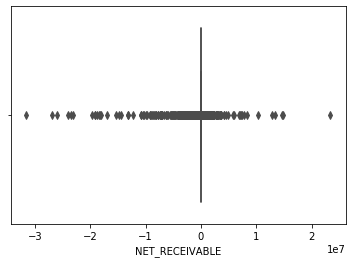

In [133]:
sns.boxplot(df['NET_RECEIVABLE'], whis = 3, color = 'deepskyblue')

In [134]:
df[df['NET_RECEIVABLE'] > 20000000]

,AUTHORIZATIONDATE,BALANCE_EXCESS,BALANCE_TENURE,CITY,COMPLETED_TENURE,CURRENT_INTEREST_RATE,CURRENT_INTEREST_RATE_MAX,CURRENT_INTEREST_RATE_MIN,CURRENT_INTEREST_RATE_CHANGES,CURRENT_TENOR,DIFF_AUTH_INT_DATE,DIFF_CURRENT_INTEREST_RATE_MAX_MIN,DIFF_EMI_AMOUNT_MAX_MIN,DIFF_ORIGINAL_CURRENT_INTEREST_RATE,DIFF_ORIGINAL_CURRENT_TENOR,DPD,DUEDAY,EMI_AMOUNT,EMI_DUEAMT,EMI_OS_AMOUNT,EMI_RECEIVED_AMT,EXCESS_ADJUSTED_AMT,EXCESS_AVAILABLE,FOIR,INTEREST_START_DATE,LAST_RECEIPT_AMOUNT,LAST_RECEIPT_DATE,LATEST_TRANSACTION_MONTH,LOAN_AMT,MAX_EMI_AMOUNT,MIN_EMI_AMOUNT,MONTHOPENING,NET_DISBURSED_AMT,NET_LTV,NET_RECEIVABLE,NUM_EMI_CHANGES,NUM_LOW_FREQ_TRANSACTIONS,ORIGNAL_INTEREST_RATE,ORIGNAL_TENOR,OUTSTANDING_PRINCIPAL,PAID_INTEREST,PAID_PRINCIPAL,PRE_EMI_DUEAMT,PRE_EMI_OS_AMOUNT,PRE_EMI_RECEIVED_AMT,PRODUCT,SCHEMEID,MOB,FORECLOSURE
107,2011-07-18,1.545986,0,MUMBAI,75,17.16759,17.16759,17.16759,0,75,0,0.0,10069901.7,-2.184966,69,2054,15,177312.0,2.926507e+07,2.339103e+07,5.874042e+06,2.257629e+07,2.257629e+07,1.12,2011-07-18,NaN,2017-12-15,12.0,20267493.3,10222213.7,152312.0,1.950191e+07,20267493.3,68.97,2.339103e+07,2,18,14.982624,144,4.155347e+06,3.588654e+06,1.611215e+07,531461.536176,0.0,531461.536176,LAP,10901121.0,85,0


In [135]:
df.drop(df[df['NET_RECEIVABLE'] > 20000000].index, inplace = True)

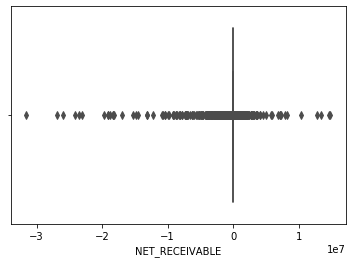

In [136]:
sns.boxplot(df['NET_RECEIVABLE'], whis = 3, color = 'deepskyblue')

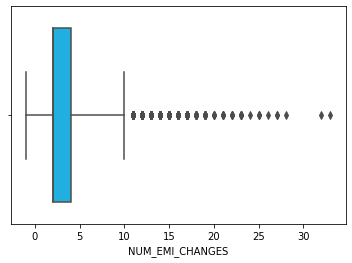

In [137]:
sns.boxplot(df['NUM_EMI_CHANGES'], whis = 3, color = 'deepskyblue')

In [138]:
df[df['NUM_EMI_CHANGES'] > 30]

,AUTHORIZATIONDATE,BALANCE_EXCESS,BALANCE_TENURE,CITY,COMPLETED_TENURE,CURRENT_INTEREST_RATE,CURRENT_INTEREST_RATE_MAX,CURRENT_INTEREST_RATE_MIN,CURRENT_INTEREST_RATE_CHANGES,CURRENT_TENOR,DIFF_AUTH_INT_DATE,DIFF_CURRENT_INTEREST_RATE_MAX_MIN,DIFF_EMI_AMOUNT_MAX_MIN,DIFF_ORIGINAL_CURRENT_INTEREST_RATE,DIFF_ORIGINAL_CURRENT_TENOR,DPD,DUEDAY,EMI_AMOUNT,EMI_DUEAMT,EMI_OS_AMOUNT,EMI_RECEIVED_AMT,EXCESS_ADJUSTED_AMT,EXCESS_AVAILABLE,FOIR,INTEREST_START_DATE,LAST_RECEIPT_AMOUNT,LAST_RECEIPT_DATE,LATEST_TRANSACTION_MONTH,LOAN_AMT,MAX_EMI_AMOUNT,MIN_EMI_AMOUNT,MONTHOPENING,NET_DISBURSED_AMT,NET_LTV,NET_RECEIVABLE,NUM_EMI_CHANGES,NUM_LOW_FREQ_TRANSACTIONS,ORIGNAL_INTEREST_RATE,ORIGNAL_TENOR,OUTSTANDING_PRINCIPAL,PAID_INTEREST,PAID_PRINCIPAL,PRE_EMI_DUEAMT,PRE_EMI_OS_AMOUNT,PRE_EMI_RECEIVED_AMT,PRODUCT,SCHEMEID,MOB,FORECLOSURE
898,2012-11-30,2.031868,57,CHENNAI,72,19.602266,19.602266,18.416142,2,129,0,1.186124,337876.00,-2.122538,-9,87,5,279480.0,4.444172e+07,1.823858e+06,4.261786e+07,622595.225904,622597.257772,0.72,2012-11-30,280000.0,2018-12-24,12.0,27023324.4,350000.0,12124.00,1.726251e+07,27023324.4,64.90,1.823856e+06,33,14,17.479728,120,1.726251e+07,1.926185e+07,9.760816e+06,77299.320000,0.0,77299.320000,LAP,10901185.0,73,0
2200,2014-03-28,0.000000,67,MADURAI,54,19.976832,19.976832,19.976832,0,121,0,0.000000,69896.74,0.000000,-1,77,15,33503.0,3.995628e+06,2.016209e+05,3.794007e+06,9755.395039,9755.395039,0.47,2014-03-28,33510.0,2018-12-31,12.0,3002591.6,70000.0,103.26,2.259821e+06,3002591.6,47.76,2.016209e+05,32,16,19.976832,120,2.259821e+06,1.901971e+06,7.427706e+05,96663.903936,0.0,96663.903936,STLAP,10901154.0,57,0


In [139]:
df.drop(df[df['NUM_EMI_CHANGES'] > 30].index, inplace = True)

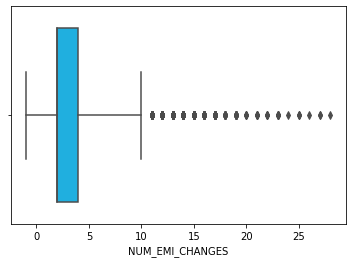

In [140]:
sns.boxplot(df['NUM_EMI_CHANGES'], whis = 3, color = 'deepskyblue')

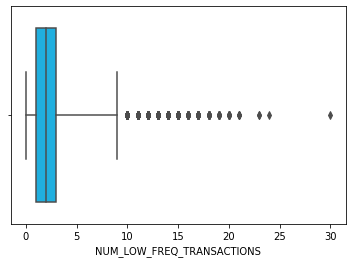

In [141]:
sns.boxplot(df['NUM_LOW_FREQ_TRANSACTIONS'], whis = 3, color = 'deepskyblue')

In [142]:
df[df['NUM_LOW_FREQ_TRANSACTIONS'] > 25]

,AUTHORIZATIONDATE,BALANCE_EXCESS,BALANCE_TENURE,CITY,COMPLETED_TENURE,CURRENT_INTEREST_RATE,CURRENT_INTEREST_RATE_MAX,CURRENT_INTEREST_RATE_MIN,CURRENT_INTEREST_RATE_CHANGES,CURRENT_TENOR,DIFF_AUTH_INT_DATE,DIFF_CURRENT_INTEREST_RATE_MAX_MIN,DIFF_EMI_AMOUNT_MAX_MIN,DIFF_ORIGINAL_CURRENT_INTEREST_RATE,DIFF_ORIGINAL_CURRENT_TENOR,DPD,DUEDAY,EMI_AMOUNT,EMI_DUEAMT,EMI_OS_AMOUNT,EMI_RECEIVED_AMT,EXCESS_ADJUSTED_AMT,EXCESS_AVAILABLE,FOIR,INTEREST_START_DATE,LAST_RECEIPT_AMOUNT,LAST_RECEIPT_DATE,LATEST_TRANSACTION_MONTH,LOAN_AMT,MAX_EMI_AMOUNT,MIN_EMI_AMOUNT,MONTHOPENING,NET_DISBURSED_AMT,NET_LTV,NET_RECEIVABLE,NUM_EMI_CHANGES,NUM_LOW_FREQ_TRANSACTIONS,ORIGNAL_INTEREST_RATE,ORIGNAL_TENOR,OUTSTANDING_PRINCIPAL,PAID_INTEREST,PAID_PRINCIPAL,PRE_EMI_DUEAMT,PRE_EMI_OS_AMOUNT,PRE_EMI_RECEIVED_AMT,PRODUCT,SCHEMEID,MOB,FORECLOSURE
1043,2013-02-27,0.022086,0,DELHI,46,14.982624,17.479728,14.982624,2,46,0,2.497104,399788.49,1.56069,74,0,5,39658.0,3.980692e+06,0.0,3.980692e+06,3.510842e+06,3.510842e+06,0.46,2013-02-27,17789.0,2017-01-05,1.0,3948407.954,400000.0,211.51,2327008.49,3948407.954,17.23,-0.022086,5,30,16.543314,120,0.0,1.093254e+06,3948407.954,12827.270016,0.0,12827.270016,LAP,10901182.0,64,0


In [143]:
df.drop(df[df['NUM_LOW_FREQ_TRANSACTIONS'] > 25].index, inplace = True)

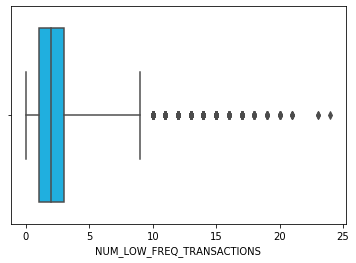

In [144]:
sns.boxplot(df['NUM_LOW_FREQ_TRANSACTIONS'], whis = 3, color = 'deepskyblue')

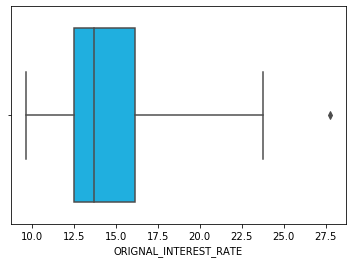

In [145]:
sns.boxplot(df['ORIGNAL_INTEREST_RATE'], whis = 3, color = 'deepskyblue')

In [146]:
df[df['ORIGNAL_INTEREST_RATE'] > 25]

,AUTHORIZATIONDATE,BALANCE_EXCESS,BALANCE_TENURE,CITY,COMPLETED_TENURE,CURRENT_INTEREST_RATE,CURRENT_INTEREST_RATE_MAX,CURRENT_INTEREST_RATE_MIN,CURRENT_INTEREST_RATE_CHANGES,CURRENT_TENOR,DIFF_AUTH_INT_DATE,DIFF_CURRENT_INTEREST_RATE_MAX_MIN,DIFF_EMI_AMOUNT_MAX_MIN,DIFF_ORIGINAL_CURRENT_INTEREST_RATE,DIFF_ORIGINAL_CURRENT_TENOR,DPD,DUEDAY,EMI_AMOUNT,EMI_DUEAMT,EMI_OS_AMOUNT,EMI_RECEIVED_AMT,EXCESS_ADJUSTED_AMT,EXCESS_AVAILABLE,FOIR,INTEREST_START_DATE,LAST_RECEIPT_AMOUNT,LAST_RECEIPT_DATE,LATEST_TRANSACTION_MONTH,LOAN_AMT,MAX_EMI_AMOUNT,MIN_EMI_AMOUNT,MONTHOPENING,NET_DISBURSED_AMT,NET_LTV,NET_RECEIVABLE,NUM_EMI_CHANGES,NUM_LOW_FREQ_TRANSACTIONS,ORIGNAL_INTEREST_RATE,ORIGNAL_TENOR,OUTSTANDING_PRINCIPAL,PAID_INTEREST,PAID_PRINCIPAL,PRE_EMI_DUEAMT,PRE_EMI_OS_AMOUNT,PRE_EMI_RECEIVED_AMT,PRODUCT,SCHEMEID,MOB,FORECLOSURE
2683,2014-08-11,0.0,209,DELHI,19,20.601108,20.601108,13.421934,1,228,0,7.179174,79429.0,7.179174,0,0,5,159766.0,6.704179e+06,0.0,6.704179e+06,0.0,0.0,0.89,2014-08-11,159766.0,2016-04-05,4.0,23270084.9,159766.0,80337.0,2.262297e+07,23270084.9,70.45,0.0,2,2,27.780282,228,2.262297e+07,4.083870e+06,647112.536449,255555.969024,0.0,255555.969024,HL,10901165.0,20,1


In [147]:
df.drop(df[df['ORIGNAL_INTEREST_RATE'] > 25].index, inplace = True)

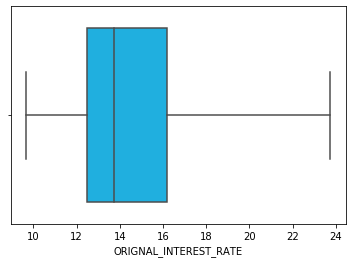

In [148]:
sns.boxplot(df['ORIGNAL_INTEREST_RATE'], whis = 3, color = 'deepskyblue')

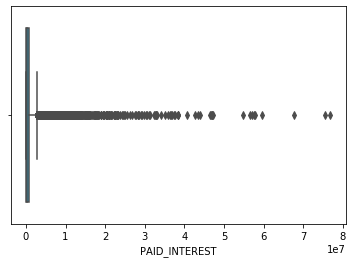

In [149]:
sns.boxplot(df['PAID_INTEREST'], whis = 3, color = 'deepskyblue')

In [150]:
df[df['PAID_INTEREST'] > 60000000]

,AUTHORIZATIONDATE,BALANCE_EXCESS,BALANCE_TENURE,CITY,COMPLETED_TENURE,CURRENT_INTEREST_RATE,CURRENT_INTEREST_RATE_MAX,CURRENT_INTEREST_RATE_MIN,CURRENT_INTEREST_RATE_CHANGES,CURRENT_TENOR,DIFF_AUTH_INT_DATE,DIFF_CURRENT_INTEREST_RATE_MAX_MIN,DIFF_EMI_AMOUNT_MAX_MIN,DIFF_ORIGINAL_CURRENT_INTEREST_RATE,DIFF_ORIGINAL_CURRENT_TENOR,DPD,DUEDAY,EMI_AMOUNT,EMI_DUEAMT,EMI_OS_AMOUNT,EMI_RECEIVED_AMT,EXCESS_ADJUSTED_AMT,EXCESS_AVAILABLE,FOIR,INTEREST_START_DATE,LAST_RECEIPT_AMOUNT,LAST_RECEIPT_DATE,LATEST_TRANSACTION_MONTH,LOAN_AMT,MAX_EMI_AMOUNT,MIN_EMI_AMOUNT,MONTHOPENING,NET_DISBURSED_AMT,NET_LTV,NET_RECEIVABLE,NUM_EMI_CHANGES,NUM_LOW_FREQ_TRANSACTIONS,ORIGNAL_INTEREST_RATE,ORIGNAL_TENOR,OUTSTANDING_PRINCIPAL,PAID_INTEREST,PAID_PRINCIPAL,PRE_EMI_DUEAMT,PRE_EMI_OS_AMOUNT,PRE_EMI_RECEIVED_AMT,PRODUCT,SCHEMEID,MOB,FORECLOSURE
95,2011-07-05,0.00000,112,MUMBAI,89,14.233493,16.543314,12.485520,5,201,0,4.057794,691568.48,0.124855,-21,0,5,700914.0,1.377724e+08,0.0,1.377724e+08,1.678310e+06,1.678310e+06,0.42,2011-07-05,700914.0,2018-12-05,12.0,9.007775e+07,700914.0,9345.52,7.201123e+07,9.007775e+07,61.53,0.00000,3,8,14.358348,180,7.201123e+07,7.558633e+07,1.806652e+07,0.000000e+00,0.0,0.000000e+00,LAP,10901115.0,89,0
998,2013-02-27,0.44171,80,MUMBAI,61,12.485520,20.413825,12.485520,3,141,0,7.928305,1034282.00,6.991891,39,0,5,1034300.0,1.393426e+08,0.0,1.393426e+08,0.000000e+00,4.417104e-01,0.45,2013-02-27,1034300.0,2018-04-05,4.0,1.077647e+08,1034862.0,580.00,8.960644e+07,1.077647e+08,52.23,-0.44171,3,4,19.477411,180,8.960644e+07,7.684216e+07,1.815824e+07,4.121843e+05,0.0,4.121843e+05,HL,10901104.0,62,1
3673,2015-06-22,0.00000,88,NOIDA,35,14.545631,16.231176,12.797658,4,123,0,3.433518,1871726.00,0.436993,-3,0,5,1743930.0,1.382293e+08,0.0,1.382293e+08,0.000000e+00,0.000000e+00,2.06,2015-06-22,1800544.0,2018-12-29,12.0,1.959191e+08,1872296.0,570.00,1.593336e+08,1.959191e+08,25.62,0.00000,8,8,14.982624,120,1.593336e+08,6.773704e+07,3.658546e+07,1.523925e+07,0.0,1.523925e+07,LAP,10901105.0,42,0


In [151]:
df.drop(df[df['PAID_INTEREST'] > 60000000].index, inplace = True)

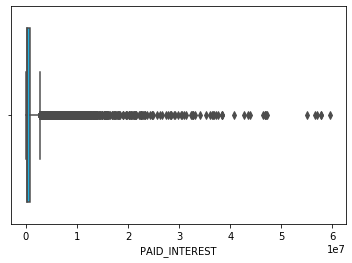

In [152]:
sns.boxplot(df['PAID_INTEREST'], whis = 3, color = 'deepskyblue')

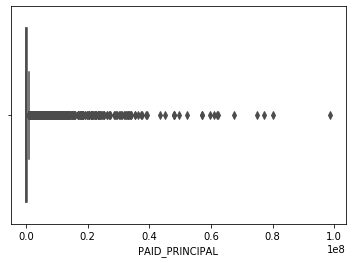

In [153]:
sns.boxplot(df['PAID_PRINCIPAL'], whis = 3, color = 'deepskyblue')

In [154]:
df[df['PAID_PRINCIPAL'] > 90000000]

,AUTHORIZATIONDATE,BALANCE_EXCESS,BALANCE_TENURE,CITY,COMPLETED_TENURE,CURRENT_INTEREST_RATE,CURRENT_INTEREST_RATE_MAX,CURRENT_INTEREST_RATE_MIN,CURRENT_INTEREST_RATE_CHANGES,CURRENT_TENOR,DIFF_AUTH_INT_DATE,DIFF_CURRENT_INTEREST_RATE_MAX_MIN,DIFF_EMI_AMOUNT_MAX_MIN,DIFF_ORIGINAL_CURRENT_INTEREST_RATE,DIFF_ORIGINAL_CURRENT_TENOR,DPD,DUEDAY,EMI_AMOUNT,EMI_DUEAMT,EMI_OS_AMOUNT,EMI_RECEIVED_AMT,EXCESS_ADJUSTED_AMT,EXCESS_AVAILABLE,FOIR,INTEREST_START_DATE,LAST_RECEIPT_AMOUNT,LAST_RECEIPT_DATE,LATEST_TRANSACTION_MONTH,LOAN_AMT,MAX_EMI_AMOUNT,MIN_EMI_AMOUNT,MONTHOPENING,NET_DISBURSED_AMT,NET_LTV,NET_RECEIVABLE,NUM_EMI_CHANGES,NUM_LOW_FREQ_TRANSACTIONS,ORIGNAL_INTEREST_RATE,ORIGNAL_TENOR,OUTSTANDING_PRINCIPAL,PAID_INTEREST,PAID_PRINCIPAL,PRE_EMI_DUEAMT,PRE_EMI_OS_AMOUNT,PRE_EMI_RECEIVED_AMT,PRODUCT,SCHEMEID,MOB,FORECLOSURE
57,2011-03-30,0.0,1,MUMBAI,47,17.791866,17.791866,17.791866,0,48,0,0.0,9859635.0,-3.433518,12,0,15,140365.0,1.186474e+08,0.0,1.186474e+08,22085520.0,22085520.0,0.3,2011-03-30,140365.0,2015-03-15,3.0,9.894016e+07,10000000.0,140365.0,4.524700e+07,9.894016e+07,75.27,0.0,2,2,14.358348,60,208129.140641,2.746486e+07,9.873203e+07,743926.447128,0.0,743926.447128,LAP,10901135.0,48,0


In [155]:
df.drop(df[df['PAID_PRINCIPAL'] > 90000000].index, inplace = True)

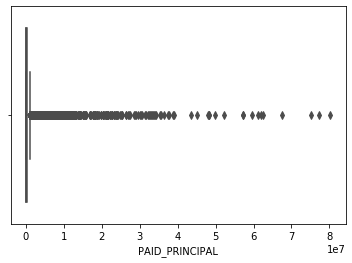

In [156]:
sns.boxplot(df['PAID_PRINCIPAL'], whis = 3, color = 'deepskyblue')

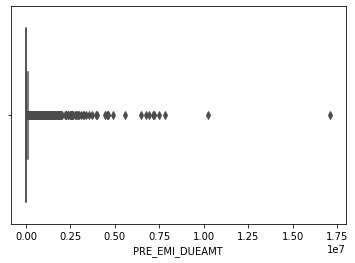

In [157]:
sns.boxplot(df['PRE_EMI_DUEAMT'], whis = 3, color = 'deepskyblue')

In [158]:
df[df['PRE_EMI_DUEAMT'] > 10000000]

,AUTHORIZATIONDATE,BALANCE_EXCESS,BALANCE_TENURE,CITY,COMPLETED_TENURE,CURRENT_INTEREST_RATE,CURRENT_INTEREST_RATE_MAX,CURRENT_INTEREST_RATE_MIN,CURRENT_INTEREST_RATE_CHANGES,CURRENT_TENOR,DIFF_AUTH_INT_DATE,DIFF_CURRENT_INTEREST_RATE_MAX_MIN,DIFF_EMI_AMOUNT_MAX_MIN,DIFF_ORIGINAL_CURRENT_INTEREST_RATE,DIFF_ORIGINAL_CURRENT_TENOR,DPD,DUEDAY,EMI_AMOUNT,EMI_DUEAMT,EMI_OS_AMOUNT,EMI_RECEIVED_AMT,EXCESS_ADJUSTED_AMT,EXCESS_AVAILABLE,FOIR,INTEREST_START_DATE,LAST_RECEIPT_AMOUNT,LAST_RECEIPT_DATE,LATEST_TRANSACTION_MONTH,LOAN_AMT,MAX_EMI_AMOUNT,MIN_EMI_AMOUNT,MONTHOPENING,NET_DISBURSED_AMT,NET_LTV,NET_RECEIVABLE,NUM_EMI_CHANGES,NUM_LOW_FREQ_TRANSACTIONS,ORIGNAL_INTEREST_RATE,ORIGNAL_TENOR,OUTSTANDING_PRINCIPAL,PAID_INTEREST,PAID_PRINCIPAL,PRE_EMI_DUEAMT,PRE_EMI_OS_AMOUNT,PRE_EMI_RECEIVED_AMT,PRODUCT,SCHEMEID,MOB,FORECLOSURE
295,2012-02-17,1.325131,269,MUMBAI,9,14.670486,14.670486,14.670486,0,278,0,0.0,318909.29,-0.936414,-50,0,15,319974.0,6.348942e+06,0.0,6.348942e+06,0.000000e+00,1.325131e+00,0.97,2012-02-17,1064.71,2014-04-22,4.0,4.578026e+07,319974.0,1064.71,4.540993e+07,4.578026e+07,80.00,-1.325131,4,2,13.734072,228,4.540993e+07,1.090605e+07,3.703336e+05,1.023971e+07,0.0,1.023971e+07,HL,10901148.0,26,0
3279,2015-01-02,1.060105,100,MUMBAI,20,15.919038,15.919038,15.919038,0,120,0,0.0,2151865.00,0.000000,0,0,15,2158607.0,9.534792e+07,0.0,9.534792e+07,1.132713e+06,1.132714e+06,0.86,2015-01-02,2158607.00,2017-03-15,3.0,2.192039e+08,2158607.0,6742.00,1.990074e+08,2.192039e+08,36.45,-1.060105,4,4,15.919038,120,1.990074e+08,5.700613e+07,2.019654e+07,1.710689e+07,0.0,1.710689e+07,LAP,10901121.0,26,0


In [159]:
df.drop(df[df['PRE_EMI_DUEAMT'] > 10000000].index, inplace = True)

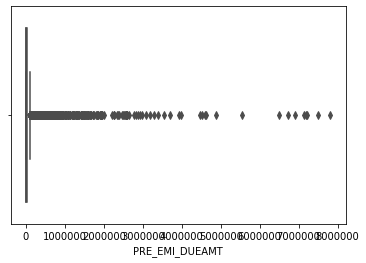

In [160]:
sns.boxplot(df['PRE_EMI_DUEAMT'], whis = 3, color = 'deepskyblue')

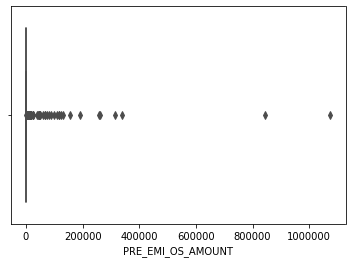

In [161]:
sns.boxplot(df['PRE_EMI_OS_AMOUNT'], whis = 3, color = 'deepskyblue')

In [162]:
df[df['PRE_EMI_OS_AMOUNT'] > 400000]

,AUTHORIZATIONDATE,BALANCE_EXCESS,BALANCE_TENURE,CITY,COMPLETED_TENURE,CURRENT_INTEREST_RATE,CURRENT_INTEREST_RATE_MAX,CURRENT_INTEREST_RATE_MIN,CURRENT_INTEREST_RATE_CHANGES,CURRENT_TENOR,DIFF_AUTH_INT_DATE,DIFF_CURRENT_INTEREST_RATE_MAX_MIN,DIFF_EMI_AMOUNT_MAX_MIN,DIFF_ORIGINAL_CURRENT_INTEREST_RATE,DIFF_ORIGINAL_CURRENT_TENOR,DPD,DUEDAY,EMI_AMOUNT,EMI_DUEAMT,EMI_OS_AMOUNT,EMI_RECEIVED_AMT,EXCESS_ADJUSTED_AMT,EXCESS_AVAILABLE,FOIR,INTEREST_START_DATE,LAST_RECEIPT_AMOUNT,LAST_RECEIPT_DATE,LATEST_TRANSACTION_MONTH,LOAN_AMT,MAX_EMI_AMOUNT,MIN_EMI_AMOUNT,MONTHOPENING,NET_DISBURSED_AMT,NET_LTV,NET_RECEIVABLE,NUM_EMI_CHANGES,NUM_LOW_FREQ_TRANSACTIONS,ORIGNAL_INTEREST_RATE,ORIGNAL_TENOR,OUTSTANDING_PRINCIPAL,PAID_INTEREST,PAID_PRINCIPAL,PRE_EMI_DUEAMT,PRE_EMI_OS_AMOUNT,PRE_EMI_RECEIVED_AMT,PRODUCT,SCHEMEID,MOB,FORECLOSURE
8302,2017-04-07,0.000000,180,THANE,0,14.233493,15.482045,13.734072,2,180,0,1.747973,37183.0,-0.499421,0,391,5,37298.0,0.000000e+00,0.000000e+00,0.0,0.0,0.000000,0.65,2017-04-07,37298.0,2018-08-05,8.0,6.151175e+06,37298.0,115.0,6.108492e+06,6.108492e+06,62.08,1.074264e+06,2,7,13.734072,180,6.108492e+06,1.642523e+05,0.000000,1.315895e+06,1.074264e+06,2.416310e+05,LAP,10901261.0,16,0
13911,2018-02-28,2634.382911,210,CHENNAI,2,14.545631,14.545631,12.797658,2,212,0,1.747973,382870.0,-1.747973,-32,46,15,11020.0,2.191100e+06,1.307679e+06,883420.8,0.0,2634.382911,0.75,2018-02-28,11020.0,2018-10-18,10.0,6.680766e+07,382988.0,118.0,6.678885e+07,6.680766e+07,69.04,2.147638e+06,5,6,12.797658,180,6.678885e+07,3.046704e+06,18808.233782,4.468839e+06,8.425935e+05,3.626246e+06,LAP,10901121.0,8,0


In [163]:
df.drop(df[df['PRE_EMI_OS_AMOUNT'] > 400000].index, inplace = True)

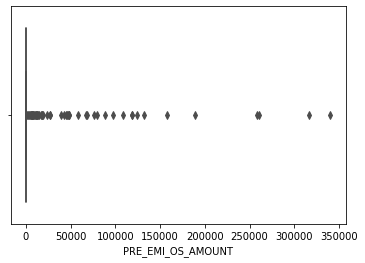

In [164]:
sns.boxplot(df['PRE_EMI_OS_AMOUNT'], whis = 3, color = 'deepskyblue')

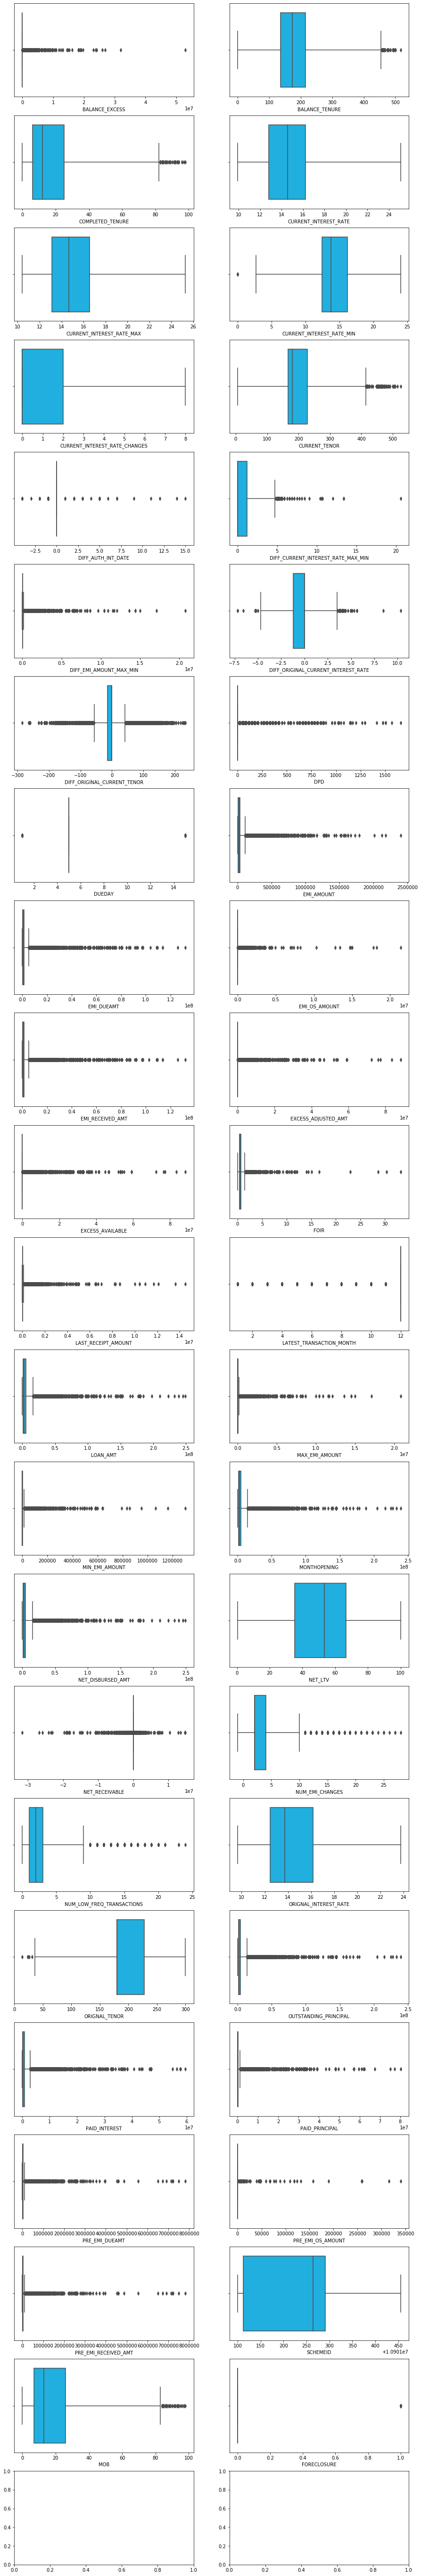

In [165]:
# boxplot of numeric data
df_num = df.select_dtypes(include = 'number')
df_cat = df.select_dtypes(exclude = 'number')

fig, ax = plt.subplots(figsize = (15, 100), nrows = 23, ncols = 2)

for i, col in enumerate(df_num.columns):
    sns.boxplot(df_num[col], ax = ax[i//2, i%2], whis = 3, color = 'deepskyblue')

In [166]:
df.shape  #48 rows dropped in total

(19964, 49)

#### Missing Value treatment

In [167]:
df.isna().sum().nlargest(10)

SCHEMEID                    281
LAST_RECEIPT_AMOUNT         245
DIFF_EMI_AMOUNT_MAX_MIN      89
MAX_EMI_AMOUNT               89
MIN_EMI_AMOUNT               89
LAST_RECEIPT_DATE            75
LATEST_TRANSACTION_MONTH     75
AUTHORIZATIONDATE             0
BALANCE_EXCESS                0
BALANCE_TENURE                0
dtype: int64

In [168]:
pd.pivot_table(df, values = 'FORECLOSURE', index = 'SCHEMEID', aggfunc = 'sum').sort_values(by = 'FORECLOSURE', ascending = False)

,FORECLOSURE
SCHEMEID,
10901104.0,774
10901112.0,462
10901291.0,56
10901142.0,52
10901251.0,50
...,...
10901225.0,0
10901226.0,0
10901227.0,0


In [169]:
df['PRODUCT'].value_counts()

STHL     7268
LAP      6187
HL       3474
STLAP    3035
Name: PRODUCT, dtype: int64

In [170]:
df.groupby(by = 'PRODUCT')['FORECLOSURE'].sum()

PRODUCT
HL       987
LAP        2
STHL     803
STLAP      0
Name: FORECLOSURE, dtype: int64

In [171]:
# Percentage of foreclosures in each product

df.groupby(by = 'PRODUCT')['FORECLOSURE'].sum() / df['PRODUCT'].value_counts()

HL       0.284111
LAP      0.000323
STHL     0.110484
STLAP    0.000000
dtype: float64

In [172]:
df[(df['PRODUCT'] == 'LAP') & (df['FORECLOSURE'] == 1)]

,AUTHORIZATIONDATE,BALANCE_EXCESS,BALANCE_TENURE,CITY,COMPLETED_TENURE,CURRENT_INTEREST_RATE,CURRENT_INTEREST_RATE_MAX,CURRENT_INTEREST_RATE_MIN,CURRENT_INTEREST_RATE_CHANGES,CURRENT_TENOR,DIFF_AUTH_INT_DATE,DIFF_CURRENT_INTEREST_RATE_MAX_MIN,DIFF_EMI_AMOUNT_MAX_MIN,DIFF_ORIGINAL_CURRENT_INTEREST_RATE,DIFF_ORIGINAL_CURRENT_TENOR,DPD,DUEDAY,EMI_AMOUNT,EMI_DUEAMT,EMI_OS_AMOUNT,EMI_RECEIVED_AMT,EXCESS_ADJUSTED_AMT,EXCESS_AVAILABLE,FOIR,INTEREST_START_DATE,LAST_RECEIPT_AMOUNT,LAST_RECEIPT_DATE,LATEST_TRANSACTION_MONTH,LOAN_AMT,MAX_EMI_AMOUNT,MIN_EMI_AMOUNT,MONTHOPENING,NET_DISBURSED_AMT,NET_LTV,NET_RECEIVABLE,NUM_EMI_CHANGES,NUM_LOW_FREQ_TRANSACTIONS,ORIGNAL_INTEREST_RATE,ORIGNAL_TENOR,OUTSTANDING_PRINCIPAL,PAID_INTEREST,PAID_PRINCIPAL,PRE_EMI_DUEAMT,PRE_EMI_OS_AMOUNT,PRE_EMI_RECEIVED_AMT,PRODUCT,SCHEMEID,MOB,FORECLOSURE
651,2012-06-30,0.0,109,PUNE,17,19.040418,19.040418,19.040418,0,126,0,0.000000,0.0,-0.936414,-6,0,5,267505.0,1.004358e+07,0.0,1.004358e+07,0.00000,0.00000,0.00,2012-06-30,267505.0,2013-12-05,12.0,2.537190e+07,267505.0,267505.0,2.362238e+07,2.537190e+07,27.15,0.0,0,0,18.104004,120,2.362238e+07,5.128853e+06,1.749514e+06,75168.067320,0.0,75168.067320,LAP,10901185.0,18,1
1113,2013-03-18,0.0,78,MUMBAI,34,24.034626,25.283178,24.034626,1,112,0,1.248552,130842.4,-1.560690,-4,0,5,131280.0,9.857916e+06,0.0,9.857916e+06,289938.70656,289938.70656,0.74,2013-03-18,131280.0,2016-02-05,2.0,1.050756e+07,131280.0,437.6,9.031941e+06,1.050756e+07,22.43,0.0,2,4,22.473936,108,8.733197e+06,5.320017e+06,1.774359e+06,139118.899032,0.0,139118.899032,LAP,10901185.0,35,1


In [173]:
df.drop(df[(df['PRODUCT'] == 'LAP') & (df['FORECLOSURE'] == 1)].index, inplace = True)

Product LAP has only 2 foreclosures out of 6000+ records. These are considered as outliers and dropped.

Mode imputation was performed for Scheme ID on the basis of the Product code. For each product, the count of scheme IDs were determined and mode imputation was performed on that basis

In [174]:
temp = df[['PRODUCT', 'SCHEMEID']]
prod_hl = temp[temp['PRODUCT'] == 'HL']
prod_hl['SCHEMEID'].value_counts().nlargest(5)

10901104.0    2355
10901337.0     150
10901343.0     140
10901340.0     119
10901376.0     103
Name: SCHEMEID, dtype: int64

In [175]:
temp = df[['PRODUCT', 'SCHEMEID']]
prod_lap = temp[temp['PRODUCT'] == 'LAP']
prod_lap['SCHEMEID'].value_counts().nlargest(5)

10901106.0    1458
10901113.0     740
10901134.0     602
10901147.0     352
10901121.0     255
Name: SCHEMEID, dtype: int64

In [176]:
temp = df[['PRODUCT', 'SCHEMEID']]
prod_sthl = temp[temp['PRODUCT'] == 'STHL']
prod_sthl['SCHEMEID'].value_counts().nlargest(5)

10901295.0    1090
10901112.0    1019
10901300.0     754
10901285.0     738
10901267.0     665
Name: SCHEMEID, dtype: int64

In [177]:
temp = df[['PRODUCT', 'SCHEMEID']]
prod_stlap = temp[temp['PRODUCT'] == 'STLAP']
prod_stlap['SCHEMEID'].value_counts().nlargest(5)

10901287.0    1018
10901289.0     544
10901290.0     432
10901294.0     369
10901154.0     300
Name: SCHEMEID, dtype: int64

In [178]:
# mode imputation for Scheme ID based on Product

df['SCHEMEID'] = np.where((df['SCHEMEID'].isna() == True) & (df['PRODUCT'] == 'HL'), prod_hl['SCHEMEID'].mode()[0], df['SCHEMEID'])
df['SCHEMEID'] = np.where((df['SCHEMEID'].isna() == True) & (df['PRODUCT'] == 'LAP'), prod_lap['SCHEMEID'].mode()[0], df['SCHEMEID'])
df['SCHEMEID'] = np.where((df['SCHEMEID'].isna() == True) & (df['PRODUCT'] == 'STHL'), prod_sthl['SCHEMEID'].mode()[0], df['SCHEMEID'])
df['SCHEMEID'] = np.where((df['SCHEMEID'].isna() == True) & (df['PRODUCT'] == 'STLAP'), prod_stlap['SCHEMEID'].mode()[0], df['SCHEMEID'])

In [179]:
df.isna().sum().nlargest(10)

LAST_RECEIPT_AMOUNT         245
DIFF_EMI_AMOUNT_MAX_MIN      89
MAX_EMI_AMOUNT               89
MIN_EMI_AMOUNT               89
LAST_RECEIPT_DATE            75
LATEST_TRANSACTION_MONTH     75
AUTHORIZATIONDATE             0
BALANCE_EXCESS                0
BALANCE_TENURE                0
CITY                          0
dtype: int64

Missing values in max and min EMI amount were imputed with the EMI Amount with the assumption that the customer has paid the actual EMI amount with no change

In [180]:
temp = df[['MAX_EMI_AMOUNT', 'MIN_EMI_AMOUNT']]

In [181]:
temp[temp['MAX_EMI_AMOUNT'].isna() == True]

,MAX_EMI_AMOUNT,MIN_EMI_AMOUNT
2545,NaN,NaN
2546,NaN,NaN
4658,NaN,NaN
4983,NaN,NaN
5134,NaN,NaN
...,...,...
19840,NaN,NaN
19860,NaN,NaN
19879,NaN,NaN
19880,NaN,NaN


In [182]:
# replacing missing max and min EMI amount with EMI amount

df['MAX_EMI_AMOUNT'] = np.where(df['MAX_EMI_AMOUNT'].isna() == True, df['EMI_AMOUNT'], df['MAX_EMI_AMOUNT'])
df['MIN_EMI_AMOUNT'] = np.where(df['MIN_EMI_AMOUNT'].isna() == True, df['EMI_AMOUNT'], df['MIN_EMI_AMOUNT'])
df['DIFF_EMI_AMOUNT_MAX_MIN'] = df['MAX_EMI_AMOUNT'] - df['MIN_EMI_AMOUNT']

In [183]:
abs(df.corr()['LAST_RECEIPT_AMOUNT']).sort_values().nlargest(2)

LAST_RECEIPT_AMOUNT    1.00000
MAX_EMI_AMOUNT         0.74051
Name: LAST_RECEIPT_AMOUNT, dtype: float64

Missing values in last receipt amount was fixed imputing the max EMI amount. This was done because last receipt amount had the highest correlation with max EMI amount

In [184]:
df['LAST_RECEIPT_AMOUNT'] = np.where(df['LAST_RECEIPT_AMOUNT'].isna() == True, 
                                     df['MAX_EMI_AMOUNT'], 
                                     df['LAST_RECEIPT_AMOUNT'])

For missing values in last receipt date, an average difference in days was determined between the last receipt date and the interest date and that number 557(days) was added to the interest state date and imputed 

In [185]:
temp = df[['LAST_RECEIPT_DATE','COMPLETED_TENURE', 'INTEREST_START_DATE']]
temp = temp[temp['LAST_RECEIPT_DATE'].isna() == True]
temp['COMPLETED_TENURE'].sum()

0

In [186]:
temp = df[['LAST_RECEIPT_DATE','COMPLETED_TENURE', 'INTEREST_START_DATE']]
temp = temp[temp['LAST_RECEIPT_DATE'].isna() == False]
temp['DateDiff'] = df['LAST_RECEIPT_DATE'] - df['INTEREST_START_DATE']
temp['DateDiff'].mean()

Timedelta('557 days 02:38:04.145421224')

In [187]:
# replacing missing Last Receipt Date with 
# interest start date + average of difference between last receipt and interest start date

df['LAST_RECEIPT_DATE'] = np.where(df['LAST_RECEIPT_DATE'].isna() == True, 
                                   df['INTEREST_START_DATE'] + temp['DateDiff'].mean(), 
                                   df['LAST_RECEIPT_DATE'])

Missing values in latest transaction month were fixed extracting the month from the last receipt date using the datetime month function

In [188]:
# replacing missing Latest Transaction Month information extracting the month information from Last Receipt Date   

df['LATEST_TRANSACTION_MONTH'] = np.where(df['LATEST_TRANSACTION_MONTH'].isna() == True,
                                          df['LAST_RECEIPT_DATE'].dt.month,
                                          df['LATEST_TRANSACTION_MONTH'])

In [189]:
df.isna().sum().sum()

0

#### Variable transformation

In [190]:
df_cat_new = df.select_dtypes(exclude = 'number')
df_cat_new.head()

,AUTHORIZATIONDATE,CITY,INTEREST_START_DATE,LAST_RECEIPT_DATE,PRODUCT
0,2010-08-29,MUMBAI,2010-08-30,2014-05-05,HL
1,2010-09-15,MUMBAI,2010-09-15,2013-11-01,HL
2,2010-11-02,MUMBAI,2010-11-01,2017-08-05,HL
3,2010-10-06,THANE,2010-10-06,2018-05-02,HL
4,2010-10-26,MUMBAI,2010-10-26,2018-04-05,HL


In [191]:
# converting categorical columns to numeric

for feature in df_cat_new.columns:
    df[feature] = pd.Categorical(df[feature]).codes

In [192]:
# 5 random rows from the final dataset

df.sample(5)

,AUTHORIZATIONDATE,BALANCE_EXCESS,BALANCE_TENURE,CITY,COMPLETED_TENURE,CURRENT_INTEREST_RATE,CURRENT_INTEREST_RATE_MAX,CURRENT_INTEREST_RATE_MIN,CURRENT_INTEREST_RATE_CHANGES,CURRENT_TENOR,DIFF_AUTH_INT_DATE,DIFF_CURRENT_INTEREST_RATE_MAX_MIN,DIFF_EMI_AMOUNT_MAX_MIN,DIFF_ORIGINAL_CURRENT_INTEREST_RATE,DIFF_ORIGINAL_CURRENT_TENOR,DPD,DUEDAY,EMI_AMOUNT,EMI_DUEAMT,EMI_OS_AMOUNT,EMI_RECEIVED_AMT,EXCESS_ADJUSTED_AMT,EXCESS_AVAILABLE,FOIR,INTEREST_START_DATE,LAST_RECEIPT_AMOUNT,LAST_RECEIPT_DATE,LATEST_TRANSACTION_MONTH,LOAN_AMT,MAX_EMI_AMOUNT,MIN_EMI_AMOUNT,MONTHOPENING,NET_DISBURSED_AMT,NET_LTV,NET_RECEIVABLE,NUM_EMI_CHANGES,NUM_LOW_FREQ_TRANSACTIONS,ORIGNAL_INTEREST_RATE,ORIGNAL_TENOR,OUTSTANDING_PRINCIPAL,PAID_INTEREST,PAID_PRINCIPAL,PRE_EMI_DUEAMT,PRE_EMI_OS_AMOUNT,PRE_EMI_RECEIVED_AMT,PRODUCT,SCHEMEID,MOB,FORECLOSURE
17060,1608,0.000000,207,187,4,14.358348,14.358348,13.109796,1,211,0,1.248552,322894.00,-1.248552,-31,0,5,371967.0,3.286034e+06,0.0,3.286034e+06,1.824264e+03,1.824264e+03,0.90,1614,371967.0,704,12.0,5.051860e+07,371967.0,49073.00,5.013670e+07,5.051860e+07,59.40,0.000000,1,3,13.109796,180,5.013670e+07,1.925500e+06,3.819026e+05,108380.272296,0.0,108380.272296,1,10901103.0,5,0
1969,549,215549.242162,60,47,28,17.479728,17.479728,17.479728,0,88,0,0.000000,31872.15,0.000000,92,0,15,31962.0,1.976513e+06,0.0,1.976513e+06,2.069175e+06,2.284725e+06,0.49,555,32000.0,234,6.0,3.603110e+06,32000.0,127.85,3.361115e+06,3.603110e+06,65.93,-215549.242162,4,3,17.479728,180,2.051186e+06,1.105772e+06,1.551924e+06,6183.945600,0.0,6183.945600,2,10901112.0,28,1
2797,678,0.000000,168,2,12,14.046210,14.046210,14.046210,0,180,0,0.000000,51614.00,0.000000,0,0,5,56186.0,1.489076e+06,0.0,1.489076e+06,0.000000e+00,0.000000e+00,0.95,684,56186.0,135,9.0,7.319999e+06,56186.0,4572.00,7.121248e+06,7.319999e+06,50.74,0.000000,1,1,14.046210,180,7.121248e+06,8.203350e+05,1.987505e+05,10097.499744,0.0,10097.499744,0,10901104.0,12,1
12596,1485,260.609136,217,220,10,15.482045,15.482045,13.734072,2,227,0,1.747973,24815.00,-1.747973,-47,0,5,28669.0,6.331698e+05,0.0,6.331698e+05,0.000000e+00,2.606091e+02,0.54,1491,28669.0,704,12.0,3.786718e+06,28669.0,3854.00,3.713072e+06,3.786718e+06,31.45,-260.609136,2,0,13.734072,180,3.713072e+06,3.625464e+05,7.364607e+04,8511.759408,0.0,8511.759408,1,10901134.0,11,0
6840,1172,4633.343326,154,256,26,18.416142,18.416142,18.416142,0,180,0,0.000000,37260.00,0.000000,0,0,5,34563.0,1.984689e+06,0.0,1.984689e+06,0.000000e+00,4.633343e+03,0.21,1178,34563.0,704,12.0,3.753240e+06,37375.0,115.00,3.578194e+06,3.753240e+06,47.62,-4633.343326,7,10,18.416142,180,3.578194e+06,1.181766e+06,1.750451e+05,11312.203344,0.0,11312.203344,2,10901266.0,27,0


In [193]:
# variable info with new variables

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19962 entries, 0 to 20011
Data columns (total 49 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   AUTHORIZATIONDATE                    19962 non-null  int16  
 1   BALANCE_EXCESS                       19962 non-null  float64
 2   BALANCE_TENURE                       19962 non-null  int64  
 3   CITY                                 19962 non-null  int16  
 4   COMPLETED_TENURE                     19962 non-null  int64  
 5   CURRENT_INTEREST_RATE                19962 non-null  float64
 6   CURRENT_INTEREST_RATE_MAX            19962 non-null  float64
 7   CURRENT_INTEREST_RATE_MIN            19962 non-null  float64
 8   CURRENT_INTEREST_RATE_CHANGES        19962 non-null  int64  
 9   CURRENT_TENOR                        19962 non-null  int64  
 10  DIFF_AUTH_INT_DATE                   19962 non-null  int64  
 11  DIFF_CURRENT_INTEREST_RATE_M

In [194]:
# correlation with target variable

abs(df.corr()['FORECLOSURE']).sort_values(ascending = False)

FORECLOSURE                            1.000000
LAST_RECEIPT_DATE                      0.532206
LATEST_TRANSACTION_MONTH               0.461506
INTEREST_START_DATE                    0.414761
AUTHORIZATIONDATE                      0.414708
SCHEMEID                               0.257158
DUEDAY                                 0.209976
PRODUCT                                0.197252
MOB                                    0.161344
COMPLETED_TENURE                       0.159227
DIFF_ORIGINAL_CURRENT_TENOR            0.145316
DIFF_ORIGINAL_CURRENT_INTEREST_RATE    0.130686
ORIGNAL_TENOR                          0.089279
DIFF_CURRENT_INTEREST_RATE_MAX_MIN     0.078237
MIN_EMI_AMOUNT                         0.065097
BALANCE_TENURE                         0.053690
DIFF_AUTH_INT_DATE                     0.052434
CURRENT_INTEREST_RATE_MIN              0.052194
PAID_INTEREST                          0.049430
ORIGNAL_INTEREST_RATE                  0.047263
EXCESS_AVAILABLE                       0

#### Custom functions

In [195]:
# Creating a function for performance evaluation

def classification_model_eval(model, true_x, true_y, predict):

#import the necessary libraries
    from sklearn import metrics
    from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, roc_auc_score, roc_curve
    
    
#print classification scores    
    print(classification_report(true_y, predict, digits = 4))
    print('\nAccuracy : ', round(metrics.accuracy_score(true_y, predict), 4))
    print('Precision: ', round(metrics.precision_score(true_y, predict), 4))
    print('Recall   : ', round(metrics.recall_score(true_y, predict), 4))
    print('F1 Score : ', round(metrics.f1_score(true_y, predict), 4))
    print('.' * 40)
    
    
#confusion matrix    
    print('\nConfusion Matrix:\n', metrics.confusion_matrix(true_y, predict))
    tn, fp, fn, tp = metrics.confusion_matrix(true_y, predict).ravel()
    print('\nTrue Negative: ' + str(tn), 'False Positive: ' + str(fp), 
          'False Negative: ' + str(fn), 'True Positive: ' + str(tp), sep = '\n')
    print('\nRecords correctly classified:', str(tn + tp))
    print('Records incorrectly classified:', str(fn + fp))
    print('.' * 40, '\n')

    
#roc_auc
    prob = model.predict_proba(true_x)
    prob = prob[:, 1]
    model_auc = roc_auc_score(true_y, prob)
    print('AUC Score:', round(model_auc, 4))
    print('.' * 40, '\n')
    fpr, tpr, threshold = roc_curve(true_y, prob)
    

#plot confusion matrix and roc auc curve
    plt.figure(figsize = (20, 7))
    plt.subplot(121)
    sns.heatmap(confusion_matrix(true_y, predict), annot = True, cmap = 'GnBu', fmt = '.0f')
    plt.title('Confusion Matrix')
    plt.subplot(122)
    plt.plot([0, 1], [0, 1], linestyle = '--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUC curve')

In [196]:
# creating function for the score comparison

def score_df(model, true_x, true_y, predict, index_name):
    score = ({'Accuracy' : [round(metrics.accuracy_score(true_y, predict), 4)],
              'Precision' : [round(metrics.precision_score(true_y, predict), 4)],
              'Recall' : [round(metrics.recall_score(true_y, predict), 4)],
              'F1 Score' : [round(metrics.f1_score(true_y, predict), 4)],
              'AUC Score' : [round(roc_auc_score(true_y, model.predict_proba(true_x)[:, 1]), 4)]
             })
    return pd.DataFrame(score, index = index_name).T

#### Train Test Split

In [197]:
df['FORECLOSURE'].value_counts(normalize = True)

0    0.91033
1    0.08967
Name: FORECLOSURE, dtype: float64

In [198]:
X = df.drop('FORECLOSURE', axis = 1)
y = df['FORECLOSURE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1, stratify = y)

In [199]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

#### Modeling

##### Base Models

In [200]:
logit_model = LogisticRegression(random_state = 1, n_jobs = -1)
lda_model = LinearDiscriminantAnalysis()
dt_model = DecisionTreeClassifier(random_state = 1)
svm_model = SVC(random_state = 1, probability=True)
knn_model = KNeighborsClassifier(n_jobs = -1)
nb_model = GaussianNB()
rf_model = RandomForestClassifier(random_state = 1, n_jobs = -1)
bag_model = BaggingClassifier(random_state = 1, n_jobs = -1)
adab_model = AdaBoostClassifier(random_state = 1)
gb_model = GradientBoostingClassifier(random_state = 1)
xgb_model = XGBClassifier(random_state = 1, n_jobs = -1)
lgbm_model = LGBMClassifier(random_state = 1, n_jobs = -1)


logit_model.fit(X_train_sc, y_train)
lda_model.fit(X_train_sc, y_train)
dt_model.fit(X_train, y_train)
svm_model.fit(X_train_sc, y_train)
knn_model.fit(X_train_sc, y_train)
nb_model.fit(X_train_sc, y_train)
rf_model.fit(X_train, y_train)
bag_model.fit(X_train, y_train)
adab_model.fit(X_train, y_train)
gb_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)
lgbm_model.fit(X_train, y_train)


logit_model_pred_ytrain = logit_model.predict(X_train_sc)
lda_model_pred_ytrain = lda_model.predict(X_train_sc)
dt_model_pred_ytrain = dt_model.predict(X_train)
svm_model_pred_ytrain = svm_model.predict(X_train_sc)
knn_model_pred_ytrain = knn_model.predict(X_train_sc)
nb_model_pred_ytrain = nb_model.predict(X_train_sc)
rf_model_pred_ytrain = rf_model.predict(X_train)
bag_model_pred_ytrain = bag_model.predict(X_train)
adab_model_pred_ytrain = adab_model.predict(X_train)
gb_model_pred_ytrain = gb_model.predict(X_train)
xgb_model_pred_ytrain = xgb_model.predict(X_train)
lgbm_model_pred_ytrain = lgbm_model.predict(X_train)


logit_model_pred_ytest = logit_model.predict(X_test_sc)
lda_model_pred_ytest = lda_model.predict(X_test_sc)
dt_model_pred_ytest = dt_model.predict(X_test)
svm_model_pred_ytest = svm_model.predict(X_test_sc)
knn_model_pred_ytest = knn_model.predict(X_test_sc)
nb_model_pred_ytest = nb_model.predict(X_test_sc)
rf_model_pred_ytest = rf_model.predict(X_test)
bag_model_pred_ytest = bag_model.predict(X_test)
adab_model_pred_ytest = adab_model.predict(X_test)
gb_model_pred_ytest = gb_model.predict(X_test)
xgb_model_pred_ytest = xgb_model.predict(X_test)
lgbm_model_pred_ytest = lgbm_model.predict(X_test)


f1score = pd.Series()
f1score['logit_model'] = metrics.f1_score(y_test, logit_model_pred_ytest)
f1score['lda_model'] = metrics.f1_score(y_test, lda_model_pred_ytest)
f1score['dt_model'] = metrics.f1_score(y_test, dt_model_pred_ytest)
f1score['svm_model'] = metrics.f1_score(y_test, svm_model_pred_ytest)
f1score['knn_model'] = metrics.f1_score(y_test, knn_model_pred_ytest)
f1score['nb_model'] = metrics.f1_score(y_test, nb_model_pred_ytest)
f1score['rf_model'] = metrics.f1_score(y_test, rf_model_pred_ytest)
f1score['bag_model'] = metrics.f1_score(y_test, bag_model_pred_ytest)
f1score['adab_model'] = metrics.f1_score(y_test, adab_model_pred_ytest)
f1score['gb_model'] = metrics.f1_score(y_test, gb_model_pred_ytest)
f1score['xgb_model'] = metrics.f1_score(y_test, xgb_model_pred_ytest)
f1score['lgbm_model'] = metrics.f1_score(y_test, lgbm_model_pred_ytest)
f1score.sort_values(ascending = False) 

lgbm_model     0.979439
xgb_model      0.975564
bag_model      0.969697
gb_model       0.968105
dt_model       0.962406
adab_model     0.954972
rf_model       0.933464
knn_model      0.797895
svm_model      0.778857
logit_model    0.605005
lda_model      0.587276
nb_model       0.473386
dtype: float64

In [201]:
acc_score = pd.Series()
acc_score['logit_model'] = metrics.accuracy_score(y_test, logit_model_pred_ytest)
acc_score['lda_model'] = metrics.accuracy_score(y_test, lda_model_pred_ytest)
acc_score['dt_model'] = metrics.accuracy_score(y_test, dt_model_pred_ytest)
acc_score['svm_model'] = metrics.accuracy_score(y_test, svm_model_pred_ytest)
acc_score['knn_model'] = metrics.accuracy_score(y_test, knn_model_pred_ytest)
acc_score['nb_model'] = metrics.accuracy_score(y_test, nb_model_pred_ytest)
acc_score['rf_model'] = metrics.accuracy_score(y_test, rf_model_pred_ytest)
acc_score['bag_model'] = metrics.accuracy_score(y_test, bag_model_pred_ytest)
acc_score['adab_model'] = metrics.accuracy_score(y_test, adab_model_pred_ytest)
acc_score['gb_model'] = metrics.accuracy_score(y_test, gb_model_pred_ytest)
acc_score['xgb_model'] = metrics.accuracy_score(y_test, xgb_model_pred_ytest)
acc_score['lgbm_model'] = metrics.accuracy_score(y_test, lgbm_model_pred_ytest)
# acc_score['cb_model'] = metrics.accuracy_score(y_test, cb_model_pred_ytest)
acc_score.sort_values(ascending = False)

lgbm_model     0.996327
xgb_model      0.995659
bag_model      0.994657
gb_model       0.994323
dt_model       0.993321
adab_model     0.991985
rf_model       0.988646
knn_model      0.967941
svm_model      0.965771
logit_model    0.939389
lda_model      0.915512
nb_model       0.844715
dtype: float64

#### Non Ensemble Base Model Scores

In [202]:
dt_train_scores = score_df(dt_model, X_train, y_train, dt_model_pred_ytrain, ['dt_Train'])
dt_test_scores = score_df(dt_model, X_test, y_test, dt_model_pred_ytest, ['dt_Test'])
dt_scores = pd.concat([dt_train_scores, dt_test_scores], axis = 1)
dt_scores

,dt_Train,dt_Test
Accuracy,1.0,0.9933
Precision,1.0,0.9715
Recall,1.0,0.9534
F1 Score,1.0,0.9624
AUC Score,1.0,0.9753


In [203]:
svm_train_scores = score_df(svm_model, X_train, y_train, svm_model_pred_ytrain, ['svm_Train'])
svm_test_scores = score_df(svm_model, X_test, y_test, svm_model_pred_ytest, ['svm_Test'])
svm_scores = pd.concat([svm_train_scores, svm_test_scores], axis = 1)
svm_scores

,svm_Train,svm_Test
Accuracy,0.9714,0.9658
Precision,0.9322,0.9256
Recall,0.7350,0.6723
F1 Score,0.8220,0.7789
AUC Score,0.5000,0.5000


In [204]:
knn_train_scores = score_df(knn_model, X_train, y_train, knn_model_pred_ytrain, ['knn_Train'])
knn_test_scores = score_df(knn_model, X_test, y_test, knn_model_pred_ytest, ['knn_Test'])
knn_scores = pd.concat([knn_train_scores, knn_test_scores], axis = 1)
knn_scores

,knn_Train,knn_Test
Accuracy,0.9755,0.9679
Precision,0.9292,0.9177
Recall,0.7861,0.7058
F1 Score,0.8517,0.7979
AUC Score,0.5004,0.4999


In [205]:
logit_train_scores = score_df(logit_model, X_train, y_train, logit_model_pred_ytrain, ['logit_Train'])
logit_test_scores = score_df(logit_model, X_test, y_test, logit_model_pred_ytest, ['logit_Test'])
logit_scores = pd.concat([logit_train_scores, logit_test_scores], axis = 1)
logit_scores

,logit_Train,logit_Test
Accuracy,0.9390,0.9394
Precision,0.7163,0.7277
Recall,0.5299,0.5177
F1 Score,0.6092,0.6050
AUC Score,0.5000,0.5000


In [206]:
lda_train_scores = score_df(lda_model, X_train, y_train, lda_model_pred_ytrain, ['lda_Train'])
lda_test_scores = score_df(lda_model, X_test, y_test, lda_model_pred_ytest, ['lda_Test'])
lda_scores = pd.concat([lda_train_scores, lda_test_scores], axis = 1)
lda_scores

,lda_Train,lda_Test
Accuracy,0.9168,0.9155
Precision,0.5277,0.5225
Recall,0.6919,0.6704
F1 Score,0.5988,0.5873
AUC Score,0.5000,0.4999


In [207]:
nb_train_scores = score_df(nb_model, X_train, y_train, nb_model_pred_ytrain, ['nb_Train'])
nb_test_scores = score_df(nb_model, X_test, y_test, nb_model_pred_ytest, ['nb_Test'])
nb_scores = pd.concat([nb_train_scores, nb_test_scores], axis = 1)
nb_scores

,nb_Train,nb_Test
Accuracy,0.8524,0.8447
Precision,0.3577,0.3401
Recall,0.8125,0.7784
F1 Score,0.4967,0.4734
AUC Score,0.5000,0.4999


In [208]:
base_estimator_scores = pd.concat([dt_scores, svm_scores, knn_scores, logit_scores, lda_scores, nb_scores], axis = 1)
base_estimator_scores

,dt_Train,dt_Test,svm_Train,svm_Test,knn_Train,knn_Test,logit_Train,logit_Test,lda_Train,lda_Test,nb_Train,nb_Test
Accuracy,1.0,0.9933,0.9714,0.9658,0.9755,0.9679,0.9390,0.9394,0.9168,0.9155,0.8524,0.8447
Precision,1.0,0.9715,0.9322,0.9256,0.9292,0.9177,0.7163,0.7277,0.5277,0.5225,0.3577,0.3401
Recall,1.0,0.9534,0.7350,0.6723,0.7861,0.7058,0.5299,0.5177,0.6919,0.6704,0.8125,0.7784
F1 Score,1.0,0.9624,0.8220,0.7789,0.8517,0.7979,0.6092,0.6050,0.5988,0.5873,0.4967,0.4734
AUC Score,1.0,0.9753,0.5000,0.5000,0.5004,0.4999,0.5000,0.5000,0.5000,0.4999,0.5000,0.4999


Among these base non-ensemble classifiers, the Decision Tree Classifier was able to produce the best results on the test set in terms of all the performance metrics considered in this case. Hence, this non-ensemble classifier was taken for further model tuning and interpretation.

Here, F1-score has been taken as one of the major criterions for evaluating model performance along with the accuracy metric since the data is imbalanced.

#### Ensemble Base Model Scores

In [209]:
rf_train_scores = score_df(rf_model, X_train, y_train, rf_model_pred_ytrain, ['rf_Train'])
rf_test_scores = score_df(rf_model, X_test, y_test, rf_model_pred_ytest, ['rf_Test'])
rf_scores = pd.concat([rf_train_scores, rf_test_scores], axis = 1)
rf_scores

,rf_Train,rf_Test
Accuracy,1.0,0.9886
Precision,1.0,0.9835
Recall,1.0,0.8883
F1 Score,1.0,0.9335
AUC Score,1.0,0.9981


In [210]:
bag_train_scores = score_df(bag_model, X_train, y_train, bag_model_pred_ytrain, ['bag_Train'])
bag_test_scores = score_df(bag_model, X_test, y_test, bag_model_pred_ytest, ['bag_Test'])
bag_scores = pd.concat([bag_train_scores, bag_test_scores], axis = 1)
bag_scores

,bag_Train,bag_Test
Accuracy,0.9996,0.9947
Precision,0.9992,0.9865
Recall,0.9968,0.9534
F1 Score,0.9980,0.9697
AUC Score,1.0000,0.9969


In [211]:
adab_train_scores = score_df(adab_model, X_train, y_train, adab_model_pred_ytrain, ['adab_Train'])
adab_test_scores = score_df(adab_model, X_test, y_test, adab_model_pred_ytest, ['adab_Test'])
adab_scores = pd.concat([adab_train_scores, adab_test_scores], axis = 1)
adab_scores

,adab_Train,adab_Test
Accuracy,0.9929,0.9920
Precision,0.9494,0.9622
Recall,0.9729,0.9479
F1 Score,0.9610,0.9550
AUC Score,0.9996,0.9978


In [212]:
gb_train_scores = score_df(gb_model, X_train, y_train, gb_model_pred_ytrain, ['gb_Train'])
gb_test_scores = score_df(gb_model, X_test, y_test, gb_model_pred_ytest, ['gb_Test'])
gb_scores = pd.concat([gb_train_scores, gb_test_scores], axis = 1)
gb_scores

,gb_Train,gb_Test
Accuracy,0.9965,0.9943
Precision,0.9793,0.9754
Recall,0.9816,0.9609
F1 Score,0.9805,0.9681
AUC Score,0.9998,0.9988


In [213]:
xgb_train_scores = score_df(xgb_model, X_train, y_train, xgb_model_pred_ytrain, ['xgb_Train'])
xgb_test_scores = score_df(xgb_model, X_test, y_test, xgb_model_pred_ytest, ['xgb_Test'])
xgb_scores = pd.concat([xgb_train_scores, xgb_test_scores], axis = 1)
xgb_scores

,xgb_Train,xgb_Test
Accuracy,1.0,0.9957
Precision,1.0,0.9848
Recall,1.0,0.9665
F1 Score,1.0,0.9756
AUC Score,1.0,0.9996


In [214]:
lgbm_train_scores = score_df(lgbm_model, X_train, y_train, lgbm_model_pred_ytrain, ['lgbm_Train'])
lgbm_test_scores = score_df(lgbm_model, X_test, y_test, lgbm_model_pred_ytest, ['lgbm_Test'])
lgbm_scores = pd.concat([lgbm_train_scores, lgbm_test_scores], axis = 1)
lgbm_scores

,lgbm_Train,lgbm_Test
Accuracy,1.0,0.9963
Precision,1.0,0.9831
Recall,1.0,0.9758
F1 Score,1.0,0.9794
AUC Score,1.0,0.9995


In [215]:
ensemble_model_scores = pd.concat([rf_scores, bag_scores, adab_scores, gb_scores, xgb_scores, lgbm_scores], axis = 1)
ensemble_model_scores

,rf_Train,rf_Test,bag_Train,bag_Test,adab_Train,adab_Test,gb_Train,gb_Test,xgb_Train,xgb_Test,lgbm_Train,lgbm_Test
Accuracy,1.0,0.9886,0.9996,0.9947,0.9929,0.9920,0.9965,0.9943,1.0,0.9957,1.0,0.9963
Precision,1.0,0.9835,0.9992,0.9865,0.9494,0.9622,0.9793,0.9754,1.0,0.9848,1.0,0.9831
Recall,1.0,0.8883,0.9968,0.9534,0.9729,0.9479,0.9816,0.9609,1.0,0.9665,1.0,0.9758
F1 Score,1.0,0.9335,0.9980,0.9697,0.9610,0.9550,0.9805,0.9681,1.0,0.9756,1.0,0.9794
AUC Score,1.0,0.9981,1.0000,0.9969,0.9996,0.9978,0.9998,0.9988,1.0,0.9996,1.0,0.9995


Among these base ensemble classifiers, the XGBoost and LGBM Classifier was able to produce the best results on the test set in terms of the various performance metrics considered in this case (except for Precision). The performance metrics were very close for the two models; hence, these two ensemble classifiers were taken for further model tuning and interpretation.

### Decision Tree Classifier

In [216]:
dt_model = DecisionTreeClassifier(max_depth = 9,
                                  min_samples_split = 30,
                                  min_samples_leaf = 10,
                                  random_state = 1)

dt_model.fit(X_train, y_train)

dt_model_pred_ytrain = dt_model.predict(X_train)
dt_model_pred_ytest = dt_model.predict(X_test)

print(f1_score(y_test, dt_model_pred_ytest))

0.9620493358633775


In [217]:
pd.DataFrame(dt_model.feature_importances_, index = X.columns, columns = ['Feature Importance']).sort_values('Feature Importance', ascending = False)

,Feature Importance
PRODUCT,0.418634
LAST_RECEIPT_DATE,0.343726
SCHEMEID,0.073530
COMPLETED_TENURE,0.065430
MOB,0.063326
NET_RECEIVABLE,0.018287
DPD,0.011308
NUM_LOW_FREQ_TRANSACTIONS,0.001633
DIFF_EMI_AMOUNT_MAX_MIN,0.001473
CURRENT_TENOR,0.001402


In [218]:
X = df.drop(['FORECLOSURE', 'LAST_RECEIPT_DATE', 'LATEST_TRANSACTION_MONTH', 'MOB', 'CURRENT_INTEREST_RATE_CHANGES',
             'DIFF_CURRENT_INTEREST_RATE_MAX_MIN', 'COMPLETED_TENURE', 'BALANCE_TENURE', 'DIFF_ORIGINAL_CURRENT_INTEREST_RATE',
             'CURRENT_TENOR', 'DUEDAY', 'LOAN_AMT', 'DIFF_AUTH_INT_DATE', 'DPD', 'CITY', 'PRE_EMI_RECEIVED_AMT',
             'PRE_EMI_OS_AMOUNT', 'NET_DISBURSED_AMT', 'EXCESS_ADJUSTED_AMT', 'EMI_OS_AMOUNT', 'EXCESS_AVAILABLE',
             'ORIGNAL_TENOR', 'MIN_EMI_AMOUNT', 'NET_LTV', 'LAST_RECEIPT_AMOUNT'],  #review these variables
    axis = 1)

y = df['FORECLOSURE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1, stratify = y)

In [219]:
dt_model = DecisionTreeClassifier(max_depth = 9,
                                  min_samples_split = 30,
                                  min_samples_leaf = 10,
                                  random_state = 1)

dt_model.fit(X_train, y_train)

dt_model_pred_ytrain = dt_model.predict(X_train)
dt_model_pred_ytest = dt_model.predict(X_test)

print(f1_score(y_test, dt_model_pred_ytest))

0.7775510204081633


#### Hyperparameter Optimization - GridSearchCV

In [220]:
param_grid_dt = {'max_depth': [7, 8, 9, 10], 
                  'min_samples_split': [30, 45, 60],
                  'min_samples_leaf': [10, 15, 20]
                  }

In [221]:
gscv_dt_model = GridSearchCV(estimator = DecisionTreeClassifier(random_state = 1),
                              param_grid = param_grid_dt, cv = 3, verbose = False, n_jobs = -1)

gscv_dt_model.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [7, 8, 9, 10],
                         'min_samples_leaf': [10, 15, 20],
                         'min_samples_split': [30, 45, 60]},
             verbose=False)

In [222]:
gscv_dt_model.best_estimator_

DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, min_samples_split=30,
                       random_state=1)

#### Fitting the best gridsearch parameters on the classifier for interpretation

In [223]:
best_dt_model = DecisionTreeClassifier(max_depth = 7,
                                  min_samples_split = 45,
                                  min_samples_leaf = 10,
                                  random_state = 1)


best_dt_model.fit(X_train, y_train)
best_dt_model_pred_ytrain = best_dt_model.predict(X_train)
best_dt_model_pred_ytest = best_dt_model.predict(X_test)
print(metrics.accuracy_score(y_train, best_dt_model_pred_ytrain))
print(metrics.accuracy_score(y_test, best_dt_model_pred_ytest))
print(metrics.f1_score(y_test, best_dt_model_pred_ytest))

0.9631432047520218
0.9614292870262148
0.7565858798735511


#### Feature Importance

In [224]:
pd.DataFrame(best_dt_model.feature_importances_, index = X.columns, columns = ['Feature Importance']).sort_values('Feature Importance', ascending = False)

,Feature Importance
PRODUCT,0.367049
AUTHORIZATIONDATE,0.258228
CURRENT_INTEREST_RATE_MIN,0.120902
NUM_LOW_FREQ_TRANSACTIONS,0.051789
CURRENT_INTEREST_RATE,0.045109
SCHEMEID,0.039671
MAX_EMI_AMOUNT,0.027253
EMI_DUEAMT,0.020969
EMI_RECEIVED_AMT,0.020819
NET_RECEIVABLE,0.009420


#### Performance Metrics

              precision    recall  f1-score   support

           0     0.9782    0.9909    0.9845     12720
           1     0.8934    0.7757    0.8304      1253

    accuracy                         0.9716     13973
   macro avg     0.9358    0.8833    0.9075     13973
weighted avg     0.9706    0.9716    0.9707     13973


Accuracy :  0.9716
Precision:  0.8934
Recall   :  0.7757
F1 Score :  0.8304
........................................

Confusion Matrix:
 [[12604   116]
 [  281   972]]

True Negative: 12604
False Positive: 116
False Negative: 281
True Positive: 972

Records correctly classified: 13576
Records incorrectly classified: 397
........................................ 

AUC Score: 0.9744
........................................ 



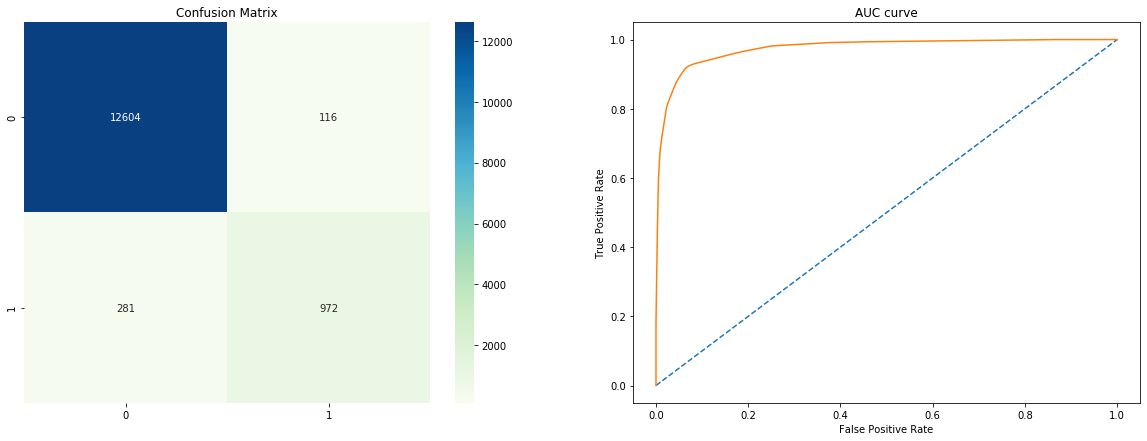

In [225]:
classification_model_eval(best_dt_model, X_train, y_train, dt_model_pred_ytrain)

              precision    recall  f1-score   support

           0     0.9719    0.9886    0.9802      5452
           1     0.8600    0.7095    0.7776       537

    accuracy                         0.9636      5989
   macro avg     0.9160    0.8491    0.8789      5989
weighted avg     0.9618    0.9636    0.9620      5989


Accuracy :  0.9636
Precision:  0.86
Recall   :  0.7095
F1 Score :  0.7776
........................................

Confusion Matrix:
 [[5390   62]
 [ 156  381]]

True Negative: 5390
False Positive: 62
False Negative: 156
True Positive: 381

Records correctly classified: 5771
Records incorrectly classified: 218
........................................ 

AUC Score: 0.9519
........................................ 



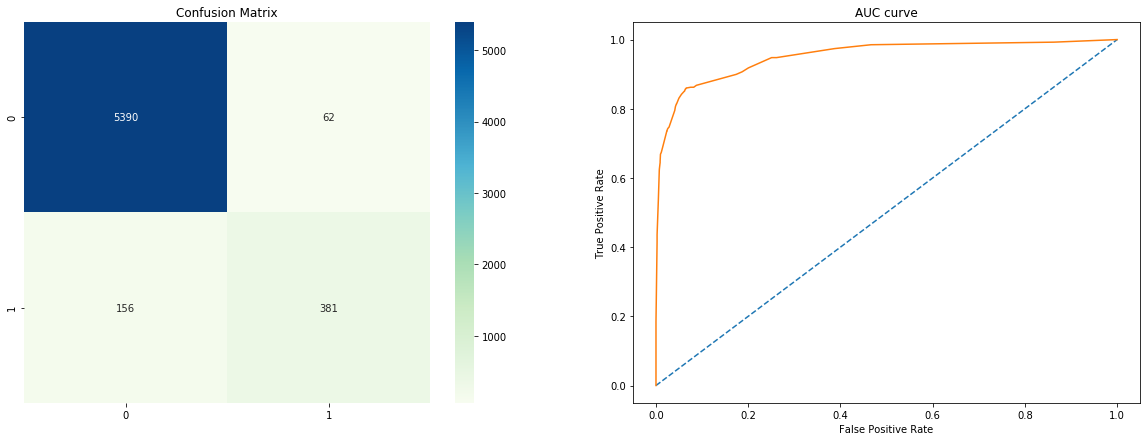

In [226]:
classification_model_eval(best_dt_model, X_test, y_test, dt_model_pred_ytest)

In [227]:
dt_train_scores = score_df(best_dt_model, X_train, y_train, best_dt_model_pred_ytrain, ['Best_DT_Train'])
dt_test_scores = score_df(best_dt_model, X_test, y_test, best_dt_model_pred_ytest, ['Best_DT_Test'])
best_dt_scores = pd.concat([dt_train_scores, dt_test_scores], axis = 1)
best_dt_scores

,Best_DT_Train,Best_DT_Test
Accuracy,0.9631,0.9614
Precision,0.8697,0.8714
Recall,0.6927,0.6685
F1 Score,0.7712,0.7566
AUC Score,0.9744,0.9519


### LGBM Classifier

In [228]:
X = df.drop(['FORECLOSURE'],  #review these variables
    axis = 1)

y = df['FORECLOSURE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1, stratify = y)

In [229]:
lgbm_model = LGBMClassifier(n_estimators = 100,
                            max_depth = 5,  
                            random_state = 1, 
                            n_jobs = -1)
lgbm_model.fit(X_train, y_train)
lgbm_model_pred_ytrain = lgbm_model.predict(X_train)
lgbm_model_pred_ytest = lgbm_model.predict(X_test)
print(metrics.accuracy_score(y_train, lgbm_model_pred_ytrain))
print(metrics.accuracy_score(y_test, lgbm_model_pred_ytest))
print(metrics.f1_score(y_test, lgbm_model_pred_ytest))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
0.9999284334072854
0.9964935715478377
0.9803921568627452


In [230]:
pd.DataFrame(lgbm_model.feature_importances_, index = X.columns, columns = ['Feature Importance']).sort_values('Feature Importance', ascending = False)

,Feature Importance
SCHEMEID,335
LAST_RECEIPT_DATE,260
PRODUCT,210
AUTHORIZATIONDATE,157
NUM_LOW_FREQ_TRANSACTIONS,117
BALANCE_EXCESS,109
NET_LTV,91
PAID_INTEREST,87
MOB,86
PRE_EMI_DUEAMT,53


In [231]:
X = df.drop(['FORECLOSURE', 'LAST_RECEIPT_DATE', 'MOB', 'LATEST_TRANSACTION_MONTH', 'LAST_RECEIPT_AMOUNT',
             'PRE_EMI_OS_AMOUNT', 'DIFF_AUTH_INT_DATE', 'COMPLETED_TENURE', 'INTEREST_START_DATE'], 
    axis = 1)

y = df['FORECLOSURE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1, stratify = y)

In [232]:
lgbm_model = LGBMClassifier(n_estimators = 100,
                            max_depth = 5,  
                            random_state = 1, 
                            n_jobs = -1)
lgbm_model.fit(X_train, y_train)
lgbm_model_pred_ytrain = lgbm_model.predict(X_train)
lgbm_model_pred_ytest = lgbm_model.predict(X_test)
print(metrics.accuracy_score(y_train, lgbm_model_pred_ytrain))
print(metrics.accuracy_score(y_test, lgbm_model_pred_ytest))
print(metrics.f1_score(y_test, lgbm_model_pred_ytest))


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
0.9925570743576898
0.9817999666054433
0.8897876643073812


In [233]:
pd.DataFrame(lgbm_model.feature_importances_, index = X.columns, columns = ['Feature Importance']).sort_values('Feature Importance', ascending = False)

,Feature Importance
AUTHORIZATIONDATE,308
PRODUCT,202
SCHEMEID,149
BALANCE_TENURE,143
PAID_INTEREST,100
BALANCE_EXCESS,96
EMI_AMOUNT,74
NET_RECEIVABLE,67
DIFF_EMI_AMOUNT_MAX_MIN,65
NET_LTV,65


#### Hyperparameter Optimization - GridSearchCV

In [234]:
param_grid_lgbm = {'n_estimators': [100, 105, 110, 115], 
                  'max_depth': [4, 5, 6, 7], 
                  'reg_lambda': [0.4, 0.5, 0.58],
                  'colsample_bytree': [0.6, 0.7, 0.8],
                  'num_leaves' : [11, 21, 31]
                  }

In [235]:
gscv_lgbm_model = GridSearchCV(estimator = LGBMClassifier(random_state = 1, n_jobs = -1),
                              param_grid = param_grid_lgbm, cv = 3, verbose = False, n_jobs = -1)

gscv_lgbm_model.fit(X_train, y_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


GridSearchCV(cv=3, estimator=LGBMClassifier(random_state=1), n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.7, 0.8],
                         'max_depth': [4, 5, 6, 7],
                         'n_estimators': [100, 105, 110, 115],
                         'num_leaves': [11, 21, 31],
                         'reg_lambda': [0.4, 0.5, 0.58]},
             verbose=False)

In [236]:
gscv_lgbm_model.best_estimator_

LGBMClassifier(colsample_bytree=0.7, max_depth=6, n_estimators=115,
               random_state=1, reg_lambda=0.4)

#### Fitting the best gridsearch parameters on the classifier for interpretation

In [237]:
best_lgbm_model = LGBMClassifier(n_estimators = 115,
                            max_depth = 6, 
#                             num_leaves = 31,
                            reg_lambda = 0.4,
                            colsample_bytree = 0.7,
                            random_state = 1, 
                            n_jobs = -1)

best_lgbm_model.fit(X_train, y_train)
best_lgbm_model_pred_ytrain = best_lgbm_model.predict(X_train)
best_lgbm_model_pred_ytest = best_lgbm_model.predict(X_test)
print(metrics.accuracy_score(y_train, best_lgbm_model_pred_ytrain))
print(metrics.accuracy_score(y_test, best_lgbm_model_pred_ytest))
print(metrics.f1_score(y_test, best_lgbm_model_pred_ytest))

0.996421670364274
0.9823008849557522
0.8931451612903226


#### Feature Importance

In [238]:
lgbm_fi = pd.DataFrame(best_lgbm_model.feature_importances_, index = X.columns, columns = ['Feature Importance']).sort_values('Feature Importance', ascending = False)
lgbm_fi

,Feature Importance
AUTHORIZATIONDATE,263
PRODUCT,211
SCHEMEID,183
BALANCE_TENURE,168
PAID_INTEREST,147
EMI_DUEAMT,116
EMI_AMOUNT,114
NET_LTV,97
PRE_EMI_DUEAMT,84
NUM_LOW_FREQ_TRANSACTIONS,77


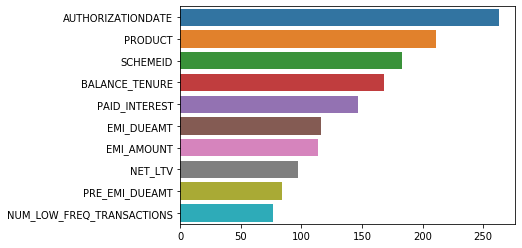

In [239]:
sns.barplot(x = best_lgbm_model.feature_importances_, y = X.columns, order = lgbm_fi.index[:10])

#### Cross Validation on final LGBM parameters

In [240]:
lgbm_cv_model = cross_val_score(LGBMClassifier(n_estimators = 115,
                            max_depth = 6, 
                            reg_lambda = 0.4,
                            colsample_bytree = 0.7,
                            random_state = 1, 
                            n_jobs = -1),
                          X_train, y_train, groups = None, scoring = 'accuracy', 
                          cv = 5, n_jobs = -1, verbose = 0)

lgbm_cv_model.mean()

0.9807489598846495

#### Performance Metrics

              precision    recall  f1-score   support

           0     0.9962    0.9998    0.9980     12720
           1     0.9983    0.9617    0.9797      1253

    accuracy                         0.9964     13973
   macro avg     0.9973    0.9808    0.9889     13973
weighted avg     0.9964    0.9964    0.9964     13973


Accuracy :  0.9964
Precision:  0.9983
Recall   :  0.9617
F1 Score :  0.9797
........................................

Confusion Matrix:
 [[12718     2]
 [   48  1205]]

True Negative: 12718
False Positive: 2
False Negative: 48
True Positive: 1205

Records correctly classified: 13923
Records incorrectly classified: 50
........................................ 

AUC Score: 1.0
........................................ 



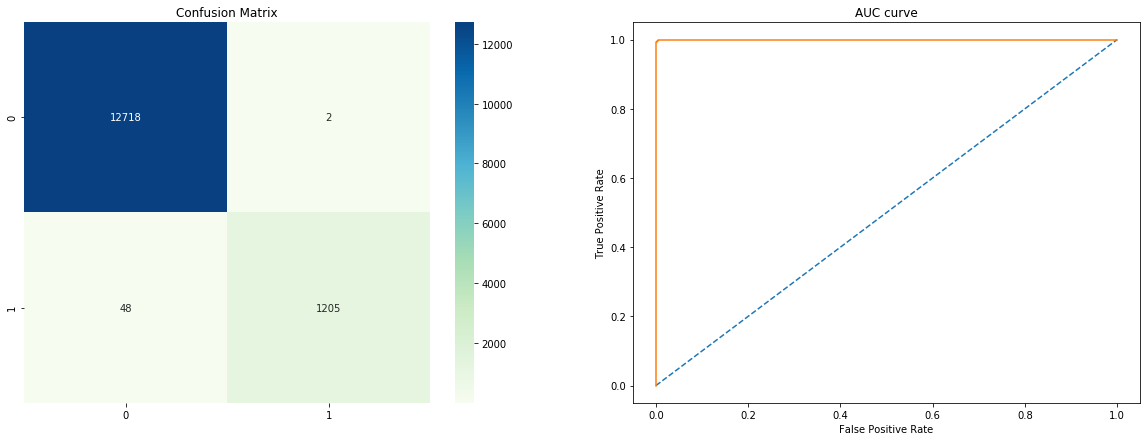

In [241]:
classification_model_eval(best_lgbm_model, X_train, y_train, best_lgbm_model_pred_ytrain)

              precision    recall  f1-score   support

           0     0.9830    0.9978    0.9904      5452
           1     0.9736    0.8250    0.8931       537

    accuracy                         0.9823      5989
   macro avg     0.9783    0.9114    0.9417      5989
weighted avg     0.9822    0.9823    0.9816      5989


Accuracy :  0.9823
Precision:  0.9736
Recall   :  0.825
F1 Score :  0.8931
........................................

Confusion Matrix:
 [[5440   12]
 [  94  443]]

True Negative: 5440
False Positive: 12
False Negative: 94
True Positive: 443

Records correctly classified: 5883
Records incorrectly classified: 106
........................................ 

AUC Score: 0.9923
........................................ 



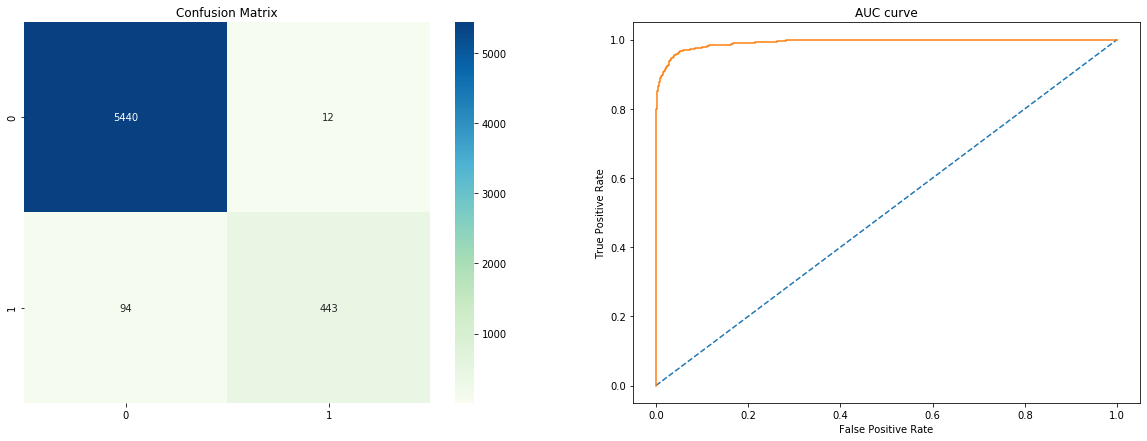

In [242]:
classification_model_eval(best_lgbm_model, X_test, y_test, best_lgbm_model_pred_ytest)

In [243]:
lgbm_train_scores = score_df(best_lgbm_model, X_train, y_train, best_lgbm_model_pred_ytrain, ['Best_LGBM_Train'])
lgbm_test_scores = score_df(best_lgbm_model, X_test, y_test, best_lgbm_model_pred_ytest, ['Best_LGBM_Test'])
best_lgbm_scores = pd.concat([lgbm_train_scores, lgbm_test_scores], axis = 1)
best_lgbm_scores

,Best_LGBM_Train,Best_LGBM_Test
Accuracy,0.9964,0.9823
Precision,0.9983,0.9736
Recall,0.9617,0.8250
F1 Score,0.9797,0.8931
AUC Score,1.0000,0.9923


### XGBoost Classifier

In [244]:
X = df.drop('FORECLOSURE', axis = 1)
y = df['FORECLOSURE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1, stratify = y)

In [245]:
xgb_model = XGBClassifier(n_estimators = 40, 
                          max_depth = 5, 
                          reg_lambda = 0.58,
#                           learning_rate = 0.8, 
                          colsample_bytree = 0.8,
                          random_state = 98,
                          n_jobs = -1)

xgb_model.fit(X_train, y_train)
xgb_model_pred_ytrain = xgb_model.predict(X_train)
xgb_model_pred_ytest = xgb_model.predict(X_test)
print(metrics.accuracy_score(y_train, xgb_model_pred_ytrain))
print(metrics.accuracy_score(y_test, xgb_model_pred_ytest))
print(metrics.f1_score(y_test, xgb_model_pred_ytest))

0.9999284334072854
0.9961596259809651
0.9783631232361243


In [246]:
pd.DataFrame(xgb_model.feature_importances_, index = X.columns, columns = ['Feature Importance']).sort_values('Feature Importance', ascending = False)

,Feature Importance
LAST_RECEIPT_DATE,0.216237
PRODUCT,0.177711
COMPLETED_TENURE,0.117090
MOB,0.086142
SCHEMEID,0.060114
LATEST_TRANSACTION_MONTH,0.035554
PAID_INTEREST,0.030215
PAID_PRINCIPAL,0.029393
DPD,0.028328
NET_RECEIVABLE,0.024275


In [247]:
X = df.drop(['FORECLOSURE', 'LAST_RECEIPT_DATE', 'LATEST_TRANSACTION_MONTH', 'CURRENT_INTEREST_RATE_CHANGES',
            'DIFF_CURRENT_INTEREST_RATE_MAX_MIN', 'INTEREST_START_DATE', 'MOB',
             'DIFF_AUTH_INT_DATE', 'PRE_EMI_OS_AMOUNT', 'CURRENT_INTEREST_RATE_MIN', 
             'DIFF_ORIGINAL_CURRENT_INTEREST_RATE'],  #review these variables
    axis = 1)

y = df['FORECLOSURE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1, stratify = y)

In [248]:
xgb_model = XGBClassifier(n_estimators = 108, 
                          max_depth = 4, 
                          reg_lambda = 0.58,
#                           learning_rate = 0.8, 
                          colsample_bytree = 0.7,
                          random_state = 98,
                          n_jobs = -1)

xgb_model.fit(X_train, y_train)
xgb_model_pred_ytrain = xgb_model.predict(X_train)
xgb_model_pred_ytest = xgb_model.predict(X_test)
print(metrics.accuracy_score(y_train, xgb_model_pred_ytrain))
print(metrics.accuracy_score(y_test, xgb_model_pred_ytest))
print(metrics.f1_score(y_test, xgb_model_pred_ytest))

0.9977098690331353
0.9848054767072967
0.9092721834496511


In [249]:
pd.DataFrame(xgb_model.feature_importances_, index = X.columns, columns = ['Feature Importance']).sort_values('Feature Importance', ascending = False)

,Feature Importance
PRODUCT,0.150812
AUTHORIZATIONDATE,0.085363
DUEDAY,0.079959
DIFF_ORIGINAL_CURRENT_TENOR,0.077228
SCHEMEID,0.065492
COMPLETED_TENURE,0.061824
CURRENT_INTEREST_RATE,0.036274
NUM_LOW_FREQ_TRANSACTIONS,0.035636
BALANCE_TENURE,0.029210
DIFF_EMI_AMOUNT_MAX_MIN,0.025456


#### Hyperparameter Optimization - Gridsearch CV

In [250]:
param_grid_xgb = {'n_estimators': [100, 105, 110, 115], 
                   'max_depth': [3, 4, 5, 6], 
                  'reg_lambda': [0.5, 0.58, 0.6, 0.67],
                  'colsample_bytree': [0.6, 0.7, 0.8, 0.9]}

In [251]:
gscv_xgb_model = GridSearchCV(estimator = XGBClassifier(random_state = 98, n_jobs = -1),
                              param_grid = param_grid_xgb, cv = 3, n_jobs = -1)

gscv_xgb_model.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=-1,
                                     num_parallel_tree=None, random_state=98,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, val

In [252]:
gscv_xgb_model.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=110, n_jobs=-1, num_parallel_tree=1, random_state=98,
              reg_alpha=0, reg_lambda=0.6, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

#### Fitting the best gridsearch parameters (with slight tweaks) on the classifier for interpretation

In [253]:
best_xgb_model = XGBClassifier(n_estimators=110, 
                          max_depth = 3, 
                          colsample_bytree = 0.7,
                          reg_lambda=0.6,
                          learning_rate = 0.300000012, 
                          n_jobs=-1, 
                          random_state=98)

best_xgb_model.fit(X_train, y_train)
best_xgb_model_pred_ytrain = best_xgb_model.predict(X_train)
best_xgb_model_pred_ytest = best_xgb_model.predict(X_test)
print(metrics.accuracy_score(y_train, best_xgb_model_pred_ytrain))
print(metrics.accuracy_score(y_test, best_xgb_model_pred_ytest))
print(metrics.f1_score(y_test, best_xgb_model_pred_ytest))

0.993272740284835
0.9853063950576056
0.9123505976095617


#### Feature Importance

In [254]:
xgb_fi = pd.DataFrame(best_xgb_model.feature_importances_, index = X.columns, columns = ['Feature Importance']).sort_values('Feature Importance', ascending = False)
xgb_fi

,Feature Importance
PRODUCT,0.137307
AUTHORIZATIONDATE,0.095018
SCHEMEID,0.090018
DIFF_ORIGINAL_CURRENT_TENOR,0.076826
COMPLETED_TENURE,0.062125
DIFF_EMI_AMOUNT_MAX_MIN,0.057897
NUM_LOW_FREQ_TRANSACTIONS,0.036681
BALANCE_TENURE,0.029551
ORIGNAL_INTEREST_RATE,0.028924
PAID_INTEREST,0.025385


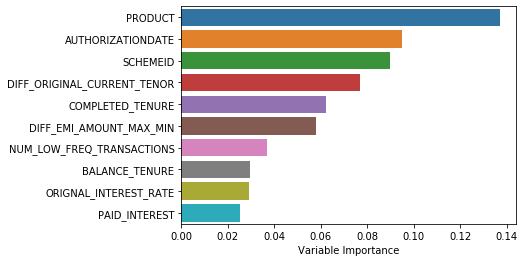

In [255]:
sns.barplot(x = best_xgb_model.feature_importances_, y = X.columns, order = xgb_fi.index[:10])
plt.xlabel('Variable Importance')
plt.show()

#### Cross Validation on XGB parameters

In [256]:
xgb_cv_model = cross_val_score(XGBClassifier(n_estimators=110, 
                          max_depth = 3, 
                          colsample_bytree = 0.7,
                          reg_lambda=0.6,
                          learning_rate = 0.300000012, 
                          n_jobs=-1, 
                          random_state=98),
                          X_train, y_train, groups = None, scoring = 'accuracy', 
                          cv = 5, n_jobs = -1, verbose = 0)

xgb_cv_model.mean()

0.9832537907066381

#### Performance Metrics

              precision    recall  f1-score   support

           0     0.9934    0.9992    0.9963     12720
           1     0.9915    0.9330    0.9613      1253

    accuracy                         0.9933     13973
   macro avg     0.9925    0.9661    0.9788     13973
weighted avg     0.9933    0.9933    0.9932     13973


Accuracy :  0.9933
Precision:  0.9915
Recall   :  0.933
F1 Score :  0.9613
........................................

Confusion Matrix:
 [[12710    10]
 [   84  1169]]

True Negative: 12710
False Positive: 10
False Negative: 84
True Positive: 1169

Records correctly classified: 13879
Records incorrectly classified: 94
........................................ 

AUC Score: 0.999
........................................ 



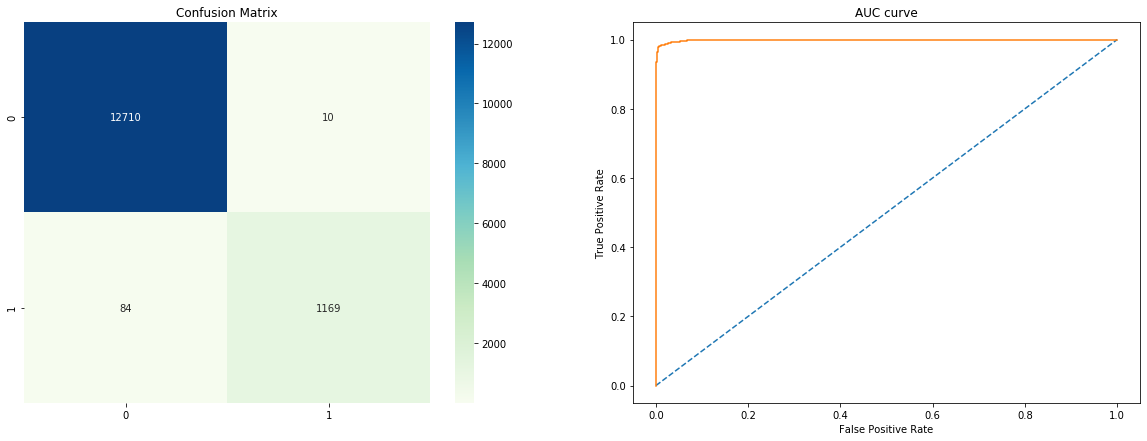

In [257]:
classification_model_eval(best_xgb_model, X_train, y_train, best_xgb_model_pred_ytrain)

              precision    recall  f1-score   support

           0     0.9857    0.9983    0.9920      5452
           1     0.9807    0.8529    0.9124       537

    accuracy                         0.9853      5989
   macro avg     0.9832    0.9256    0.9522      5989
weighted avg     0.9852    0.9853    0.9848      5989


Accuracy :  0.9853
Precision:  0.9807
Recall   :  0.8529
F1 Score :  0.9124
........................................

Confusion Matrix:
 [[5443    9]
 [  79  458]]

True Negative: 5443
False Positive: 9
False Negative: 79
True Positive: 458

Records correctly classified: 5901
Records incorrectly classified: 88
........................................ 

AUC Score: 0.9939
........................................ 



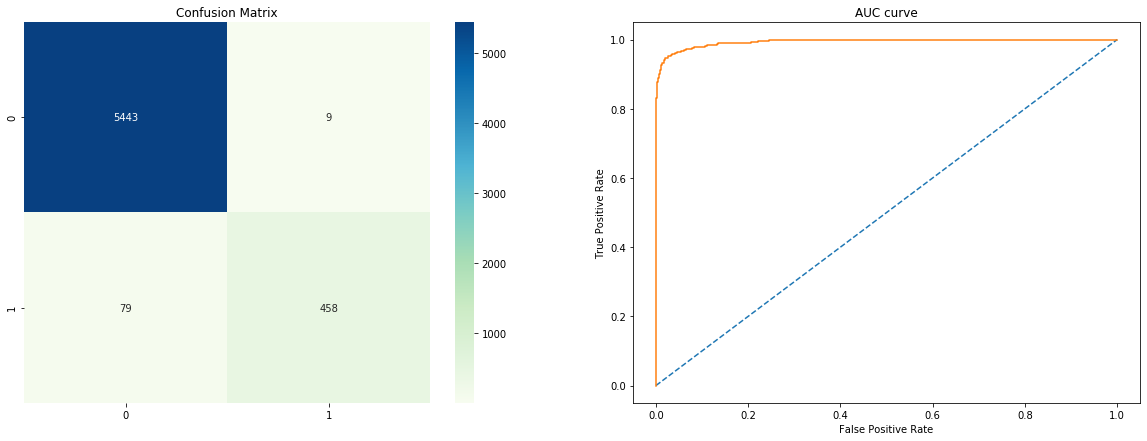

In [258]:
classification_model_eval(best_xgb_model, X_test, y_test, best_xgb_model_pred_ytest)

In [259]:
xgb_train_scores = score_df(best_xgb_model, X_train, y_train, best_xgb_model_pred_ytrain, ['Best_XGB_Train'])
xgb_test_scores = score_df(best_xgb_model, X_test, y_test, best_xgb_model_pred_ytest, ['Best_XGB_Test'])
best_xgb_scores = pd.concat([xgb_train_scores, xgb_test_scores], axis = 1)
best_xgb_scores

,Best_XGB_Train,Best_XGB_Test
Accuracy,0.9933,0.9853
Precision,0.9915,0.9807
Recall,0.9330,0.8529
F1 Score,0.9613,0.9124
AUC Score,0.9990,0.9939


#### Best/Final Model Comparison and Selection

In [260]:
best_model_scores = pd.concat([best_dt_scores, best_lgbm_scores, best_xgb_scores], axis = 1)
best_model_scores

,Best_DT_Train,Best_DT_Test,Best_LGBM_Train,Best_LGBM_Test,Best_XGB_Train,Best_XGB_Test
Accuracy,0.9631,0.9614,0.9964,0.9823,0.9933,0.9853
Precision,0.8697,0.8714,0.9983,0.9736,0.9915,0.9807
Recall,0.6927,0.6685,0.9617,0.8250,0.9330,0.8529
F1 Score,0.7712,0.7566,0.9797,0.8931,0.9613,0.9124
AUC Score,0.9744,0.9519,1.0000,0.9923,0.9990,0.9939


As the XGB Classifier has the best scores among the three fine tuned classifiers, this will be considered as the final model. 

###### ===================== END =====================